In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install nltk

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import pprint
import string
import re

import nltk
nltk.download('stopwords')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

from IPython.display import clear_output

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, make_scorer, accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split, KFold, RepeatedStratifiedKFold, StratifiedKFold, RandomizedSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /wynton/protected/home/ichs/msushil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def ohe_df(df, column_name, multi_label=False):
    
    dfa = df.copy()
    
    if multi_label:
    
        dfa['label'] = dfa['label'].replace(r"\[+|\]+|\'+|\{+|\}+", '',regex=True)
        dfa['label'] = dfa['label'].replace(r"\s+", '',regex=True)
        dfa['label'] = dfa['label'].str.split(',')
        enc = MultiLabelBinarizer()
        labels_enc = enc.fit_transform(dfa['label'].values)
        labels = list(enc.classes_)
    else: 
        enc = OneHotEncoder(handle_unknown = 'ignore',drop=None)
        labels_enc = enc.fit_transform(dfa[['label']]).toarray()
        labels = list(enc.categories_[0])
        
    labels_enc = pd.DataFrame(labels_enc, columns=labels)
    dfa = pd.concat([dfa, labels_enc], axis=1)
    dfa.dropna(inplace=True)
    dfa.reset_index(inplace=True)
    dfa = dfa.loc[:, [column_name] + labels]
    
    return dfa, enc, labels


def ohe_transform(df, column_name, enc, multi_label=False):
    
    dfa = df.copy()
    
    if multi_label:
        
        dfa['label'] = dfa['label'].replace(r"\[+|\]+|\'+|\{+|\}+", '',regex=True)
        dfa['label'] = dfa['label'].replace(r"\s+", '',regex=True)
        dfa['label'] = dfa['label'].str.split(',')
        labels_enc = enc.transform(dfa['label'].values)
        labels = list(enc.classes_)
    else:
        labels_enc = enc.transform(dfa[['label']]).toarray()
        labels = list(enc.categories_[0])
        
    labels_enc = pd.DataFrame(labels_enc, columns=labels)
    dfa = pd.concat([dfa, labels_enc], axis=1)
    dfa.dropna(inplace=True)
    dfa.reset_index(inplace=True)
    dfa = dfa.loc[:, [column_name] + labels]
    
    return dfa

def balanced(df):
    
    analysis = df.iloc[:,1:].sum()
    sums_indicies = analysis.index
    max_index = analysis.index[np.where(analysis == max(analysis))[0][0]]
    balanced_df = df
    for ind in sums_indicies:
        sums_indicies = analysis.index
        while analysis[ind] < analysis[max_index]:
            balanced_df = pd.concat([balanced_df, df[df[ind]==1]], axis=0)
            analysis = balanced_df.iloc[:,1:].sum()
    return balanced_df

def preprocess(sentences):
    
    preprocessed = []
    for sentence in sentences:
        sentence = sentence.lower()

        sentence = re.sub(r'\*+\-\*+|\(\*+\)|\(\*+-\*+\)', '', sentence)
        sentence = re.sub(r'\*+', '', sentence)
        sentence = re.sub(r'\s+', ' ', sentence)
        sentence = re.sub(r'\(\s+\)', '', sentence)
        
        sentence = sentence.replace('<', 'lessthan')
        sentence = sentence.replace('>', 'greaterthan')
        sentence = sentence.replace('+', 'plus')
        sentence = sentence.replace('=', 'equal')

        
        preprocessed.append(sentence)
    return preprocessed


def sample_df_train_nosw(df, max_f, column_name, N, stop_w):
    
    np.random.seed(42)
    df = df.sample(n=len(df))
    full_texts_processed = preprocess(df[column_name].values)
    Y_train = df.iloc[:,1:].values
    
    if N>3:
        vectorizer = TfidfVectorizer(max_features = max_f, ngram_range=(1, N), stop_words=stop_w)
    else:
        vectorizer = TfidfVectorizer(max_features = max_f, ngram_range=(1, N), stop_words=stop_w)
        
    X_train = vectorizer.fit_transform(full_texts_processed).toarray()
    return X_train, Y_train, vectorizer

def sample_df_test(df, vect, column_name):
    
    np.random.seed(42)
    full_texts_list = df[column_name].values
    full_texts_processed = preprocess(full_texts_list)
    X_val = vect.transform(full_texts_processed).toarray()
    Y_val = df.iloc[:,1:].values
    return X_val, Y_val

def max_features(df, column_name, N, stop_w):
    
    full_texts_list = df[column_name].values
    full_texts_processed = preprocess(full_texts_list)
    if N>3:
        vectorizer = TfidfVectorizer(ngram_range=(1, N), stop_words=stop_w)
    else:
        vectorizer = TfidfVectorizer(ngram_range=(1, N), stop_words=stop_w)
        
    vectorizer.fit_transform(full_texts_processed).toarray()
#     range_max = vectorizer.get_feature_names_out().shape[0]
    range_max = len(vectorizer.get_feature_names())
    range_min = int(range_max - 0.96*range_max)
    steps = (range_max - range_min)//8
    return range_max, range_min, steps

In [4]:
def Random_search(df, dev_set, column, stop_w, multi_label = False, all_labels=None):
    
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df.drop(columns='index', inplace=True)
    dev_set.dropna(inplace=True)
    dev_set.reset_index(inplace=True)
    dev_set.drop(columns='index', inplace=True)
    
    f1 = make_scorer(f1_score , average='macro')
    seed = np.random.seed(42)
    column_name = column
    

    min_n_grams = 1
    max_n_grams = 4
    max_score = 0
    ohe_dfa, enc, labels = ohe_df(df, column_name, multi_label)

    df_test_ohe = ohe_transform(dev_set, column_name, enc, multi_label)

    best_params_L = []
    scores_L = []
    results_ = []
    val_scores = []
    
    
#     min_absolute = max_features(ohe_dfa, column_name, 1)[1]
    

    for i in range(min_n_grams, max_n_grams):

        max_f, min_f, steps = max_features(ohe_dfa, column_name, i, stop_w=stop_w)
        
#         steps_ = (max_f - min_absolute)//10

        if i > 1:
            z_list = [int(min_f//5), int(min_f//2), int(min_f//1.2)] + list(range(min_f, max_f, steps))
        else:
            z_list = list(range(min_f, max_f, steps))
        
        for j in z_list:
            
            X_train, Y_train, vectorizer = sample_df_train_nosw(ohe_dfa, j, column_name, i, stop_w)
            X_val, Y_val = sample_df_test(df_test_ohe, vectorizer, column_name)


    #         n_estimators = [int(x) for x in np.linspace(start = 100, stop = 400, num = 20)] 
    #         max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] 
    #         min_samples_split = [2, 5, 10] 
    #         min_samples_leaf = [2, 10, 20]  

            
            n_estimators = [100, 150, 200, 300]
            max_depth = [5, 8, 15, 25, 50]
            min_samples_split = [2, 5, 10, 15, 100]
            min_samples_leaf = [1, 2, 5, 10] 

            random_grid = {'n_estimators': n_estimators,
                           'max_depth': [None] + max_depth,
                           'min_samples_split': min_samples_split,
                           'min_samples_leaf': min_samples_leaf,
                           'max_leaf_nodes': [None] + list(np.linspace(10, 40, 20).astype(int))}


            rf = RandomForestClassifier(oob_score=True)
            rf_random = RandomizedSearchCV(
                                    estimator = rf,
                                    param_distributions = random_grid,
                                    n_iter = 15, cv=3,
                                    verbose=2, random_state=seed, 
                                    scoring=f1, n_jobs=-1)
            
            print(f'features: {j}, ngrams: {i}')


            rf_random.fit(X_train, Y_train)

            best_params_L.append(rf_random.best_params_)
            
            val_scores.append(rf_random.score(X_val, Y_val))

            y_predic = rf_random.predict(X_val)
            y_predic_train = rf_random.predict(X_train)
            
            
            print(f'training f1-score: {f1_score(Y_train, y_predic_train, average="macro", labels=all_labels)}, training accuracy: {accuracy_score(Y_train, y_predic_train)}')
            print(f'validation f1-score: {f1_score(Y_val, y_predic, average="macro", labels=all_labels)}, validation accuracy: {accuracy_score(Y_val, y_predic)}')
            
            results_.append((i,j,f1_score(Y_train, y_predic_train, average="macro", labels=all_labels), f1_score(Y_val, y_predic, average="macro", labels=all_labels)))

            if f1_score(Y_val, y_predic, average='macro', labels=all_labels) > max_score:
                best_ngram = i
                best_features = j
                max_score = f1_score(Y_val, y_predic, average='macro', labels=all_labels)
                best_params_ = rf_random.best_params_
                
            print('----------------------------------------------------------------------------------------------------')
            
    

#         if rf_random.score(X_val, Y_val)> max_score:

#             best_ngram = i
#             max_score = rf_random.score(X_val, Y_val)
#             best_params_ = rf_random.best_params_
    scores_L.append((best_ngram, best_features, best_params_, max_score))
    print('Best Score: ', max_score)
    print('Best ngram:', best_ngram)
    print('Best feature:', best_features)
    print('Best Hyperparameters: %s' % best_params_)
    return best_params_, best_ngram, best_features, scores_L, results_

In [5]:
def Train_test(df, dev_set, column, best_params_, best_ngram, best_features, stop_w, enable_balance = False, multi_label=False, 
               all_labels=None):
    
    seed = np.random.seed(42)
    column_name = column

    #training set
    ohe_dfa, enc, labels = ohe_df(df, column_name, multi_label)
    ohe_dfa.dropna(inplace=True)
    if enable_balance:
        balanced_df = balanced(ohe_dfa)

    #validation set
    df_test_ohe = ohe_transform(dev_set, column_name, enc, multi_label)
    df_test_ohe.dropna(inplace=True)

    models = []
    reports = []
    vects = []
    scores = []
    ngrams_features = []


    max_score = 0

    if enable_balance == True:
        X_train, Y_train, vectorizer = sample_df_train_nosw(balanced_df, best_features, column_name, best_ngram, stop_w)
    else:
        X_train, Y_train, vectorizer = sample_df_train_nosw(ohe_dfa, best_features, column_name, best_ngram, stop_w)

    X_val, Y_val = sample_df_test(df_test_ohe, vectorizer, column_name)

    model = RandomForestClassifier(
                                  min_samples_split=best_params_['min_samples_split'],
                                  min_samples_leaf=best_params_['min_samples_leaf'],
                                  max_leaf_nodes=best_params_['max_leaf_nodes'],
                                  max_depth=best_params_['max_depth'])

    model.fit(X_train, Y_train)
    predictions = model.predict(X_val)

    reports.append(classification_report(Y_val, predictions, labels=all_labels, zero_division=0))
    models.append(model)
    vects.append(vectorizer)

    score = f1_score(Y_val, predictions, labels=all_labels, average='macro')
    scores.append(score)
    
    max_score = score
    best_ngrams_features = [best_ngram,best_features]
    best_model = model
    best_report = classification_report(Y_val, predictions, labels=all_labels, zero_division=0)
    best_vect = vectorizer
    accuracy1 = accuracy_score(Y_val, predictions)
            
    print('best accuracy score:', np.round(accuracy1,2))
    print('best f1 score: ', np.round(max_score,2))
    print('best n_grams / number of features: ', best_ngrams_features)
    print('------------------------------------------------------')
    print(best_report)
    print(labels)
    
    return np.round(max_score,2), best_report #, predictions, X_val, Y_val

In [6]:
dict_results = {}
dict_params = {}

In [7]:
data_dir = "../../data/"

## Pathology type

'TRAINING SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  570
Labels:  ["{'Cytology'}" "{'Histopathology'}" "{'Irrelevant note'}" "{'Unknown'}"]
------------------------------------------------------------
'VALIDATION SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  99
Labels:  ["{'Cytology'}" "{'Histopathology'}" "{'Irrelevant note'}" "{'Unknown'}"]


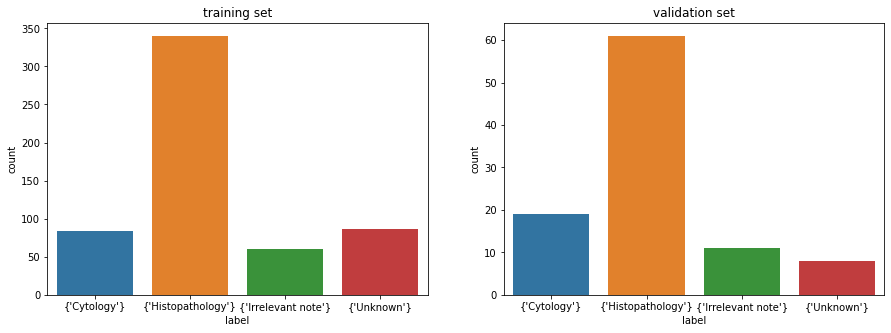

In [9]:
task_name = 'path_type'
pprint.pprint('TRAINING SET')
df = pd.read_csv(os.path.join(data_dir, 'train_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
df = df.rename(columns={'label_' + task_name: 'label'})
print('Columns: ', df.columns)
print('Size: ', len(df))
print('Labels: ', df['label'].sort_values().unique())

print('------------------------------------------------------------')

pprint.pprint('VALIDATION SET')
dev_set = pd.read_csv(os.path.join(data_dir, 'dev_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
dev_set = dev_set.rename(columns={'label_' + task_name: 'label'})
print('Columns: ', dev_set.columns)
print('Size: ', len(dev_set))
print('Labels: ', dev_set['label'].sort_values().unique())


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.countplot(data = df.sort_values('label'), x='label', ax=axes[0])
axes[0].set_title('training set')
sns.countplot(data = dev_set.sort_values('label'), x='label', ax=axes[1])
axes[1].set_title('validation set')
plt.show()

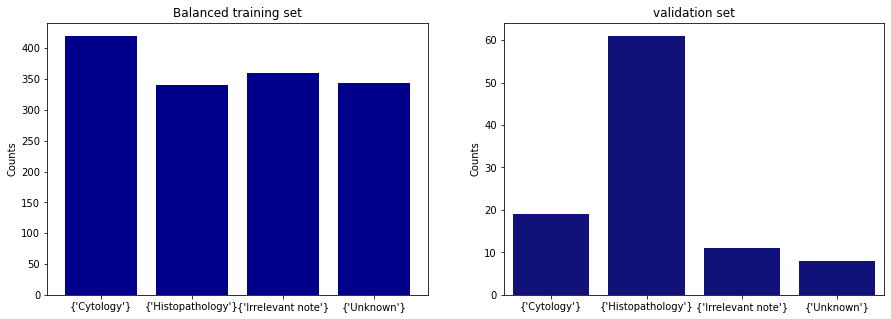

In [10]:
balanced_df = balanced(ohe_df(df, 'full_text', multi_label=False)[0])

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.bar(balanced_df.iloc[:,1:].sum().index, balanced_df.iloc[:,1:].sum(), color='darkblue')
plt.ylabel('Counts')
plt.title('Balanced training set')

plt.subplot(1,2,2)
sns.countplot(data = dev_set.sort_values('label'), x='label', color='darkblue')
plt.title('validation set')
plt.xlabel('')
plt.ylabel('Counts')
plt.show()

plt.show()

In [11]:
best_params_, best_ngram, best_features, scores_L, results_ = Random_search(df, dev_set, 'full_text', stop_w = 'english')
dict_results['pathtype_SW'] = results_
dict_params['pathtype_SW'] = scores_L

features: 192, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    2.2s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.8s finished


training f1-score: 0.9595192283093863, training accuracy: 0.968421052631579
validation f1-score: 0.8444629014396456, validation accuracy: 0.8888888888888888
----------------------------------------------------------------------------------------------------
features: 770, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished


training f1-score: 0.9586844966657804, training accuracy: 0.9666666666666667
validation f1-score: 0.9111785013359817, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 1348, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.9577410951586808, training accuracy: 0.9614035087719298
validation f1-score: 0.8430809339239572, validation accuracy: 0.898989898989899
----------------------------------------------------------------------------------------------------
features: 1926, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.9543473757039764, training accuracy: 0.9614035087719298
validation f1-score: 0.8841962826797385, validation accuracy: 0.9191919191919192
----------------------------------------------------------------------------------------------------
features: 2504, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.9297152184817884, training accuracy: 0.9403508771929825
validation f1-score: 0.9027391796613657, validation accuracy: 0.9292929292929293
----------------------------------------------------------------------------------------------------
features: 3082, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9407689234215915, training accuracy: 0.9491228070175438
validation f1-score: 0.8130214101144333, validation accuracy: 0.8888888888888888
----------------------------------------------------------------------------------------------------
features: 3660, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9425847373611513, training accuracy: 0.9508771929824561
validation f1-score: 0.9008629493464052, validation accuracy: 0.9292929292929293
----------------------------------------------------------------------------------------------------
features: 4238, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9464275085297744, training accuracy: 0.9543859649122807
validation f1-score: 0.8577256944444445, validation accuracy: 0.9090909090909091
----------------------------------------------------------------------------------------------------
features: 4816, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished


training f1-score: 0.9394791472990395, training accuracy: 0.9491228070175438
validation f1-score: 0.854059829059829, validation accuracy: 0.9090909090909091
----------------------------------------------------------------------------------------------------
features: 412, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.898162754574617, training accuracy: 0.9210526315789473
validation f1-score: 0.8048213048213049, validation accuracy: 0.8888888888888888
----------------------------------------------------------------------------------------------------
features: 1030, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.9562225081374128, training accuracy: 0.9649122807017544
validation f1-score: 0.8672015765765766, validation accuracy: 0.9090909090909091
----------------------------------------------------------------------------------------------------
features: 1717, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.9609715015263653, training accuracy: 0.9701754385964912
validation f1-score: 0.8692606851037084, validation accuracy: 0.9191919191919192
----------------------------------------------------------------------------------------------------
features: 2061, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.9311734108416531, training accuracy: 0.9456140350877194
validation f1-score: 0.8463440184370417, validation accuracy: 0.9090909090909091
----------------------------------------------------------------------------------------------------
features: 8246, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.6s finished


training f1-score: 0.9256578140941288, training accuracy: 0.9368421052631579
validation f1-score: 0.8764880952380952, validation accuracy: 0.898989898989899
----------------------------------------------------------------------------------------------------
features: 14431, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    2.5s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    3.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.5s finished


training f1-score: 0.9427618375618415, training accuracy: 0.9491228070175438
validation f1-score: 0.9027391796613657, validation accuracy: 0.9292929292929293
----------------------------------------------------------------------------------------------------
features: 20616, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.5s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    4.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.5s finished


training f1-score: 0.9460558529893687, training accuracy: 0.956140350877193
validation f1-score: 0.8787952196382429, validation accuracy: 0.9191919191919192
----------------------------------------------------------------------------------------------------
features: 26801, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.5s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.9s finished


training f1-score: 0.9441962171683133, training accuracy: 0.9526315789473684
validation f1-score: 0.8806423611111112, validation accuracy: 0.9191919191919192
----------------------------------------------------------------------------------------------------
features: 32986, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.2s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.8s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.0s finished


training f1-score: 0.9360472092675994, training accuracy: 0.9508771929824561
validation f1-score: 0.8806423611111112, validation accuracy: 0.9191919191919192
----------------------------------------------------------------------------------------------------
features: 39171, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.0s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.0s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.0s finished


training f1-score: 0.9383439506481719, training accuracy: 0.9491228070175438
validation f1-score: 0.7992546604751329, validation accuracy: 0.8787878787878788
----------------------------------------------------------------------------------------------------
features: 45356, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.6s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.6s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.9s finished


training f1-score: 0.9301621544963168, training accuracy: 0.9438596491228071
validation f1-score: 0.8710419010123734, validation accuracy: 0.898989898989899
----------------------------------------------------------------------------------------------------
features: 1119, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.9549809546559709, training accuracy: 0.9614035087719298
validation f1-score: 0.7791919488484373, validation accuracy: 0.8787878787878788
----------------------------------------------------------------------------------------------------
features: 2797, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9675820197841701, training accuracy: 0.9701754385964912
validation f1-score: 0.7825072870874399, validation accuracy: 0.8787878787878788
----------------------------------------------------------------------------------------------------
features: 4662, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.0s finished


training f1-score: 0.971054374921382, training accuracy: 0.9719298245614035
validation f1-score: 0.8406791406791407, validation accuracy: 0.898989898989899
----------------------------------------------------------------------------------------------------
features: 5595, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.4s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.3s finished


training f1-score: 0.964806038516841, training accuracy: 0.9701754385964912
validation f1-score: 0.8335470085470085, validation accuracy: 0.8888888888888888
----------------------------------------------------------------------------------------------------
features: 22383, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.4s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.7s finished


training f1-score: 0.9625053186052537, training accuracy: 0.9631578947368421
validation f1-score: 0.8833333333333333, validation accuracy: 0.9090909090909091
----------------------------------------------------------------------------------------------------
features: 39171, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.8s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.6s finished


training f1-score: 0.9594695250142624, training accuracy: 0.9614035087719298
validation f1-score: 0.9063216374269005, validation accuracy: 0.9191919191919192
----------------------------------------------------------------------------------------------------
features: 55959, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    7.8s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   11.3s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.0s finished


training f1-score: 0.9459995516573309, training accuracy: 0.9526315789473684
validation f1-score: 0.8710419010123734, validation accuracy: 0.898989898989899
----------------------------------------------------------------------------------------------------
features: 72747, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   12.8s remaining:   21.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   17.2s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   19.8s finished


training f1-score: 0.9435757045340706, training accuracy: 0.9526315789473684
validation f1-score: 0.8579137166677695, validation accuracy: 0.8888888888888888
----------------------------------------------------------------------------------------------------
features: 89535, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   15.2s remaining:   25.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   18.6s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   23.7s finished


training f1-score: 0.9349453803915213, training accuracy: 0.9456140350877194
validation f1-score: 0.8576302521008403, validation accuracy: 0.8787878787878788
----------------------------------------------------------------------------------------------------
features: 106323, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   20.8s remaining:   34.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   28.2s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   31.9s finished


training f1-score: 0.9376255119414454, training accuracy: 0.9508771929824561
validation f1-score: 0.8689484126984127, validation accuracy: 0.8888888888888888
----------------------------------------------------------------------------------------------------
features: 123111, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   25.0s remaining:   41.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   32.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   35.6s finished


training f1-score: 0.9366552860518986, training accuracy: 0.9473684210526315
validation f1-score: 0.8433945756780402, validation accuracy: 0.8888888888888888
----------------------------------------------------------------------------------------------------
Best Score:  0.9111785013359817
Best ngram: 1
Best feature: 770
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': 40, 'max_depth': 25}


In [12]:
max_score_1, best_report_1 = Train_test(df=df, 
                                        dev_set=dev_set, 
                                        column='full_text', 
                                        best_params_=best_params_, 
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w='english',
                                        enable_balance=True)

best accuracy score: 0.93
best f1 score:  0.91
best n_grams / number of features:  [1, 770]
------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.97      0.95      0.96        61
           2       0.75      0.82      0.78        11
           3       1.00      0.88      0.93         8

   micro avg       0.95      0.93      0.94        99
   macro avg       0.93      0.90      0.91        99
weighted avg       0.95      0.93      0.94        99
 samples avg       0.93      0.93      0.93        99

["{'Cytology'}", "{'Histopathology'}", "{'Irrelevant note'}", "{'Unknown'}"]


In [13]:
best_params_, best_ngram, best_features, scores_L, results_ = Random_search(df, dev_set, 'full_text', stop_w = None)
dict_results['pathtype_'] = results_
dict_params['pathtype_'] = scores_L

features: 201, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.9740192932115079, training accuracy: 0.9736842105263158
validation f1-score: 0.8382965686274509, validation accuracy: 0.8787878787878788
----------------------------------------------------------------------------------------------------
features: 805, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.963274173134177, training accuracy: 0.968421052631579
validation f1-score: 0.8711078265765766, validation accuracy: 0.9191919191919192
----------------------------------------------------------------------------------------------------
features: 1409, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.9618946600840069, training accuracy: 0.9666666666666667
validation f1-score: 0.8373931623931623, validation accuracy: 0.898989898989899
----------------------------------------------------------------------------------------------------
features: 2013, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.9501130997798061, training accuracy: 0.956140350877193
validation f1-score: 0.8392118863049096, validation accuracy: 0.898989898989899
----------------------------------------------------------------------------------------------------
features: 2617, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.9430453272938234, training accuracy: 0.9508771929824561
validation f1-score: 0.8109623015873015, validation accuracy: 0.8787878787878788
----------------------------------------------------------------------------------------------------
features: 3221, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9478159388320331, training accuracy: 0.9543859649122807
validation f1-score: 0.8094117290682177, validation accuracy: 0.8888888888888888
----------------------------------------------------------------------------------------------------
features: 3825, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9415712706900498, training accuracy: 0.9508771929824561
validation f1-score: 0.8094117290682177, validation accuracy: 0.8888888888888888
----------------------------------------------------------------------------------------------------
features: 4429, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.9406781409306143, training accuracy: 0.9473684210526315
validation f1-score: 0.8298534798534798, validation accuracy: 0.8888888888888888
----------------------------------------------------------------------------------------------------
features: 438, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.9630963003337737, training accuracy: 0.9631578947368421
validation f1-score: 0.7936225653051918, validation accuracy: 0.8585858585858586
----------------------------------------------------------------------------------------------------
features: 1096, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.9624513542345541, training accuracy: 0.9666666666666667
validation f1-score: 0.799516369047619, validation accuracy: 0.8585858585858586
----------------------------------------------------------------------------------------------------
features: 1827, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.9616072013209964, training accuracy: 0.9649122807017544
validation f1-score: 0.8387147651853535, validation accuracy: 0.8888888888888888
----------------------------------------------------------------------------------------------------
features: 2193, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.9646979989191142, training accuracy: 0.9701754385964912
validation f1-score: 0.8692606851037084, validation accuracy: 0.9191919191919192
----------------------------------------------------------------------------------------------------
features: 8774, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.7s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.6s finished


training f1-score: 0.9648466799686312, training accuracy: 0.9649122807017544
validation f1-score: 0.9207130358705161, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 15355, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    2.1s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    3.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.5s finished


training f1-score: 0.9278233840883715, training accuracy: 0.9368421052631579
validation f1-score: 0.8564360119047618, validation accuracy: 0.898989898989899
----------------------------------------------------------------------------------------------------
features: 21936, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.7s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.1s finished


training f1-score: 0.9507866485770976, training accuracy: 0.9578947368421052
validation f1-score: 0.854059829059829, validation accuracy: 0.9090909090909091
----------------------------------------------------------------------------------------------------
features: 28517, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.5s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    7.1s finished


training f1-score: 0.944776697782785, training accuracy: 0.9543859649122807
validation f1-score: 0.8731026785714285, validation accuracy: 0.9090909090909091
----------------------------------------------------------------------------------------------------
features: 35098, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.2s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    7.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.8s finished


training f1-score: 0.9452247076644018, training accuracy: 0.956140350877193
validation f1-score: 0.8558785529715762, validation accuracy: 0.9090909090909091
----------------------------------------------------------------------------------------------------
features: 41679, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.8s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.4s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.1s finished


training f1-score: 0.9001832392466511, training accuracy: 0.9192982456140351
validation f1-score: 0.8465201465201465, validation accuracy: 0.898989898989899
----------------------------------------------------------------------------------------------------
features: 48260, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.9s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.9s finished


training f1-score: 0.8925852847342411, training accuracy: 0.9140350877192982
validation f1-score: 0.8016057585825027, validation accuracy: 0.8686868686868687
----------------------------------------------------------------------------------------------------
features: 54841, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.1s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   11.4s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.5s finished


training f1-score: 0.9377479002604188, training accuracy: 0.9508771929824561
validation f1-score: 0.8054817275747508, validation accuracy: 0.8787878787878788
----------------------------------------------------------------------------------------------------
features: 1268, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.9594643189126575, training accuracy: 0.9649122807017544
validation f1-score: 0.8144886644886644, validation accuracy: 0.8888888888888888
----------------------------------------------------------------------------------------------------
features: 3171, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.0s finished


training f1-score: 0.9750023319298369, training accuracy: 0.9736842105263158
validation f1-score: 0.7865365911167438, validation accuracy: 0.8787878787878788
----------------------------------------------------------------------------------------------------
features: 5285, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.4s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.2s finished


training f1-score: 0.9620406552337092, training accuracy: 0.9666666666666667
validation f1-score: 0.7997846747846749, validation accuracy: 0.8787878787878788
----------------------------------------------------------------------------------------------------
features: 6343, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.4s finished


training f1-score: 0.9684422588881367, training accuracy: 0.968421052631579
validation f1-score: 0.817250233426704, validation accuracy: 0.8686868686868687
----------------------------------------------------------------------------------------------------
features: 25372, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.0s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.5s finished


training f1-score: 0.9276056907158707, training accuracy: 0.9368421052631579
validation f1-score: 0.8712555370985604, validation accuracy: 0.9090909090909091
----------------------------------------------------------------------------------------------------
features: 44401, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.7s remaining:   11.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.8s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.9s finished


training f1-score: 0.9545726529570673, training accuracy: 0.9596491228070175
validation f1-score: 0.878581583552056, validation accuracy: 0.9090909090909091
----------------------------------------------------------------------------------------------------
features: 63430, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.6s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   12.7s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   15.4s finished


training f1-score: 0.948475128037485, training accuracy: 0.956140350877193
validation f1-score: 0.8749789088863892, validation accuracy: 0.9090909090909091
----------------------------------------------------------------------------------------------------
features: 82459, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   13.2s remaining:   21.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   18.0s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   21.3s finished


training f1-score: 0.9460118038566007, training accuracy: 0.9543859649122807
validation f1-score: 0.8481252343457067, validation accuracy: 0.8888888888888888
----------------------------------------------------------------------------------------------------
features: 101488, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   17.1s remaining:   28.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   22.1s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   26.3s finished


training f1-score: 0.9421091169787734, training accuracy: 0.9508771929824561
validation f1-score: 0.8064484126984127, validation accuracy: 0.8686868686868687
----------------------------------------------------------------------------------------------------
features: 120517, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   24.1s remaining:   39.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   31.0s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   36.8s finished


training f1-score: 0.9391969690232597, training accuracy: 0.9491228070175438
validation f1-score: 0.8517279090113735, validation accuracy: 0.8888888888888888
----------------------------------------------------------------------------------------------------
features: 139546, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   28.2s remaining:   46.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   37.2s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   40.9s finished


training f1-score: 0.9373106969551538, training accuracy: 0.9526315789473684
validation f1-score: 0.8143964562569214, validation accuracy: 0.8686868686868687
----------------------------------------------------------------------------------------------------
Best Score:  0.9207130358705161
Best ngram: 2
Best feature: 8774
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': 40, 'max_depth': 25}


In [14]:
max_score_1b, best_report_1b = Train_test(df=df, 
                                         dev_set=dev_set, 
                                         column='full_text', 
                                         best_params_=best_params_, 
                                         best_ngram = best_ngram,
                                         best_features= best_features,
                                         stop_w=None,
                                         enable_balance=False)

best accuracy score: 0.94
best f1 score:  0.93
best n_grams / number of features:  [2, 8774]
------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.92      0.98      0.95        61
           2       1.00      0.64      0.78        11
           3       1.00      1.00      1.00         8

   micro avg       0.95      0.94      0.94        99
   macro avg       0.98      0.89      0.93        99
weighted avg       0.95      0.94      0.94        99
 samples avg       0.94      0.94      0.94        99

["{'Cytology'}", "{'Histopathology'}", "{'Irrelevant note'}", "{'Unknown'}"]


In [15]:
pprint.pprint('TEST SET')
test_set = pd.read_csv(os.path.join(data_dir, 'test_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
test_set = test_set.rename(columns={'label_' + task_name: 'label'})
print('Columns: ', test_set.columns)
print('Size: ', len(test_set))
print('Labels: ', test_set['label'].sort_values().unique())

test_score_1b, test_report_1b = Train_test(df=df, 
                                         dev_set=test_set, 
                                         column='full_text', 
                                         best_params_=best_params_, 
                                         best_ngram = best_ngram,
                                         best_features= best_features,
                                         stop_w=None,
                                         enable_balance=False)

'TEST SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  100
Labels:  ["{'Cytology'}" "{'Histopathology'}" "{'Irrelevant note'}" "{'Unknown'}"]
best accuracy score: 0.91
best f1 score:  0.89
best n_grams / number of features:  [2, 8774]
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        17
           1       0.94      0.97      0.95        60
           2       0.80      0.62      0.70        13
           3       1.00      1.00      1.00        10

   micro avg       0.93      0.91      0.92       100
   macro avg       0.92      0.87      0.89       100
weighted avg       0.92      0.91      0.92       100
 samples avg       0.91      0.91      0.91       100

["{'Cytology'}", "{'Histopathology'}", "{'Irrelevant note'}", "{'Unknown'}"]


## grade

'TRAINING SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  570
Labels:  ["{'1 (Low)'}" "{'2 (Intermediate)'}" "{'3 (High)'}" "{'Unknown'}"]
------------------------------------------------------------
'VALIDATION SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  99
Labels:  ["{'1 (Low)'}" "{'2 (Intermediate)'}" "{'3 (High)'}" "{'Unknown'}"]


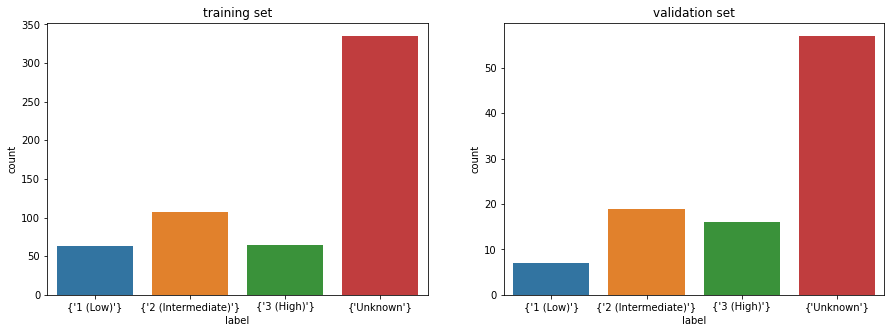

In [19]:
pprint.pprint('TRAINING SET')
task_name = 'grade'
df = pd.read_csv(os.path.join(data_dir, 'train_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
df = df.rename(columns={'label_' + task_name: 'label'})
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.drop(columns='index', inplace=True)
print('Columns: ', df.columns)
print('Size: ', len(df))
print('Labels: ', df['label'].sort_values().unique())

print('------------------------------------------------------------')

pprint.pprint('VALIDATION SET')
dev_set = pd.read_csv(os.path.join(data_dir, 'dev_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
dev_set = dev_set.rename(columns={'label_' + task_name: 'label'})
print('Columns: ', dev_set.columns)
print('Size: ', len(dev_set))
print('Labels: ', dev_set['label'].sort_values().unique())


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.countplot(data = df.sort_values('label'), x='label', ax=axes[0])
axes[0].set_title('training set')
sns.countplot(data = dev_set.sort_values('label'), x='label', ax=axes[1])
axes[1].set_title('validation set')
plt.show()

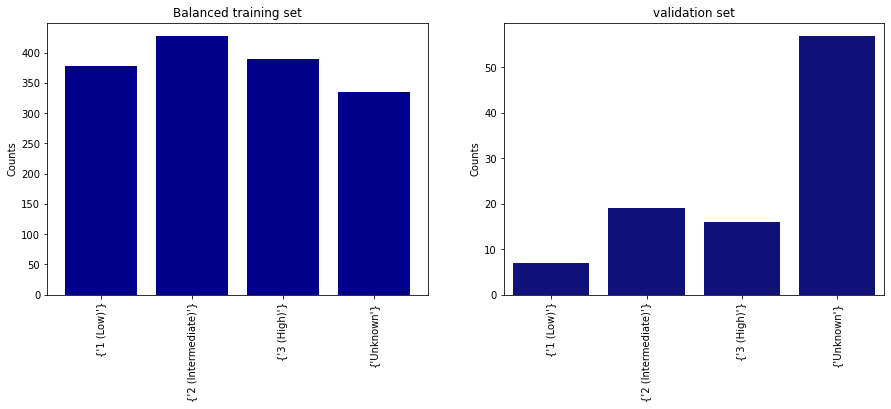

In [20]:
balanced_df = balanced(ohe_df(df, 'full_text')[0])

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.bar(balanced_df.iloc[:,1:].sum().index, balanced_df.iloc[:,1:].sum(), color='darkblue')
plt.xticks(rotation='vertical')
plt.ylabel('Counts')
plt.title('Balanced training set')

plt.subplot(1,2,2)
sns.countplot(data = dev_set.sort_values('label'), x='label', color='darkblue')
plt.title('validation set')
plt.xticks(rotation='vertical')
plt.xlabel('')
plt.ylabel('Counts')
plt.show()

plt.show()

In [21]:
best_params_, best_ngram, best_features, scores_L, results_ = Random_search(df, dev_set, 'full_text', stop_w = None)
dict_results['grade_'] = results_
dict_params['grade_'] = scores_L

features: 201, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    2.2s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.9s finished


training f1-score: 0.9412288172871116, training accuracy: 0.9315789473684211
validation f1-score: 0.2838669950738916, validation accuracy: 0.5555555555555556
----------------------------------------------------------------------------------------------------
features: 805, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.0s finished


training f1-score: 0.8347106297473944, training accuracy: 0.8596491228070176
validation f1-score: 0.31378446115288217, validation accuracy: 0.5858585858585859
----------------------------------------------------------------------------------------------------
features: 1409, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.7677707743968725, training accuracy: 0.8210526315789474
validation f1-score: 0.3134218289085546, validation accuracy: 0.5757575757575758
----------------------------------------------------------------------------------------------------
features: 2013, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.937485971279296, training accuracy: 0.9333333333333333
validation f1-score: 0.33539731682146545, validation accuracy: 0.6060606060606061
----------------------------------------------------------------------------------------------------
features: 2617, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.8499694043707129, training accuracy: 0.8666666666666667
validation f1-score: 0.3262061403508772, validation accuracy: 0.5959595959595959
----------------------------------------------------------------------------------------------------
features: 3221, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9134206564583256, training accuracy: 0.9122807017543859
validation f1-score: 0.3238384955752212, validation accuracy: 0.5858585858585859
----------------------------------------------------------------------------------------------------
features: 3825, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.8256160661406686, training accuracy: 0.8526315789473684
validation f1-score: 0.3262061403508772, validation accuracy: 0.5959595959595959
----------------------------------------------------------------------------------------------------
features: 4429, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.8880258974242536, training accuracy: 0.8964912280701754
validation f1-score: 0.3262061403508772, validation accuracy: 0.5959595959595959
----------------------------------------------------------------------------------------------------
features: 438, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.9030778846935227, training accuracy: 0.9017543859649123
validation f1-score: 0.28084323712507075, validation accuracy: 0.5656565656565656
----------------------------------------------------------------------------------------------------
features: 1096, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.9641671093071772, training accuracy: 0.9543859649122807
validation f1-score: 0.33337595907928386, validation accuracy: 0.6060606060606061
----------------------------------------------------------------------------------------------------
features: 1827, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9683273755642177, training accuracy: 0.9578947368421052
validation f1-score: 0.33980978260869565, validation accuracy: 0.6060606060606061
----------------------------------------------------------------------------------------------------
features: 2193, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.9200941679238497, training accuracy: 0.9140350877192982
validation f1-score: 0.34808184143222504, validation accuracy: 0.6161616161616161
----------------------------------------------------------------------------------------------------
features: 8774, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.6s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.9s finished


training f1-score: 0.9504309289309976, training accuracy: 0.9403508771929825
validation f1-score: 0.3262061403508772, validation accuracy: 0.5959595959595959
----------------------------------------------------------------------------------------------------
features: 15355, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    2.5s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    3.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.9s finished


training f1-score: 0.9209654023182776, training accuracy: 0.9175438596491228
validation f1-score: 0.31866303690260134, validation accuracy: 0.5858585858585859
----------------------------------------------------------------------------------------------------
features: 21936, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.5s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.7s finished


training f1-score: 0.9141316052013181, training accuracy: 0.9140350877192982
validation f1-score: 0.31310130164119976, validation accuracy: 0.5858585858585859
----------------------------------------------------------------------------------------------------
features: 28517, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.3s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    7.2s finished


training f1-score: 0.8029901256870693, training accuracy: 0.8385964912280702
validation f1-score: 0.3045088566827697, validation accuracy: 0.5757575757575758
----------------------------------------------------------------------------------------------------
features: 35098, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.4s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    7.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.4s finished


training f1-score: 0.8963699846292469, training accuracy: 0.9
validation f1-score: 0.3186700767263427, validation accuracy: 0.5959595959595959
----------------------------------------------------------------------------------------------------
features: 41679, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.7s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.2s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.4s finished


training f1-score: 0.8756644195994983, training accuracy: 0.8859649122807017
validation f1-score: 0.31664167916041974, validation accuracy: 0.5858585858585859
----------------------------------------------------------------------------------------------------
features: 48260, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.9s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.5s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   11.6s finished


training f1-score: 0.8744523244966521, training accuracy: 0.887719298245614
validation f1-score: 0.3197204968944099, validation accuracy: 0.5858585858585859
----------------------------------------------------------------------------------------------------
features: 54841, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.1s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   11.0s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   11.6s finished


training f1-score: 0.8483593651251956, training accuracy: 0.8701754385964913
validation f1-score: 0.3186700767263427, validation accuracy: 0.5959595959595959
----------------------------------------------------------------------------------------------------
features: 1268, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.8832116389182323, training accuracy: 0.8859649122807017
validation f1-score: 0.3447204968944099, validation accuracy: 0.6161616161616161
----------------------------------------------------------------------------------------------------
features: 3171, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished


training f1-score: 0.9229320905980853, training accuracy: 0.9157894736842105
validation f1-score: 0.3447204968944099, validation accuracy: 0.6161616161616161
----------------------------------------------------------------------------------------------------
features: 5285, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.3s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.3s finished


training f1-score: 0.5539712594972266, training accuracy: 0.7368421052631579
validation f1-score: 0.3045088566827697, validation accuracy: 0.5757575757575758
----------------------------------------------------------------------------------------------------
features: 6343, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.4s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.4s finished


training f1-score: 0.912541741361735, training accuracy: 0.9070175438596492
validation f1-score: 0.3241847826086956, validation accuracy: 0.5959595959595959
----------------------------------------------------------------------------------------------------
features: 25372, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.7s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.0s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.3s finished


training f1-score: 0.7335673373132808, training accuracy: 0.8087719298245614
validation f1-score: 0.2881270903010033, validation accuracy: 0.5656565656565656
----------------------------------------------------------------------------------------------------
features: 44401, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.3s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.8s finished


training f1-score: 0.9200210901978559, training accuracy: 0.9140350877192982
validation f1-score: 0.3488558352402746, validation accuracy: 0.6262626262626263
----------------------------------------------------------------------------------------------------
features: 63430, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.5s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   12.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   14.0s finished


training f1-score: 0.8933836996336997, training accuracy: 0.9
validation f1-score: 0.3272089761570827, validation accuracy: 0.5959595959595959
----------------------------------------------------------------------------------------------------
features: 82459, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   12.4s remaining:   20.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   16.4s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   20.6s finished


training f1-score: 0.8842734629179643, training accuracy: 0.8929824561403509
validation f1-score: 0.3447204968944099, validation accuracy: 0.6161616161616161
----------------------------------------------------------------------------------------------------
features: 101488, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   15.2s remaining:   25.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   24.7s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   26.9s finished


training f1-score: 0.8666533380618633, training accuracy: 0.8807017543859649
validation f1-score: 0.33980978260869565, validation accuracy: 0.6060606060606061
----------------------------------------------------------------------------------------------------
features: 120517, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   24.0s remaining:   39.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   30.1s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   36.0s finished


training f1-score: 0.8504068637246447, training accuracy: 0.8719298245614036
validation f1-score: 0.3110799438990182, validation accuracy: 0.5858585858585859
----------------------------------------------------------------------------------------------------
features: 139546, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   26.2s remaining:   43.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   38.0s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   40.0s finished


training f1-score: 0.841819170574016, training accuracy: 0.868421052631579
validation f1-score: 0.3045088566827697, validation accuracy: 0.5757575757575758
----------------------------------------------------------------------------------------------------
Best Score:  0.3488558352402746
Best ngram: 3
Best feature: 44401
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': 40, 'max_depth': 25}


In [22]:
max_score_2b, best_report_2b = Train_test(df=df,
                                         dev_set=dev_set,
                                         column='full_text',
                                         best_params_= best_params_,
                                         best_ngram = best_ngram,
                                         best_features = 2600,
                                         stop_w = None,
                                         enable_balance = True)

best accuracy score: 0.64
best f1 score:  0.45
best n_grams / number of features:  [3, 2600]
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.59      0.53      0.56        19
           2       1.00      0.19      0.32        16
           3       0.96      0.88      0.92        57

   micro avg       0.86      0.64      0.73        99
   macro avg       0.64      0.40      0.45        99
weighted avg       0.83      0.64      0.69        99
 samples avg       0.64      0.64      0.64        99

["{'1 (Low)'}", "{'2 (Intermediate)'}", "{'3 (High)'}", "{'Unknown'}"]


In [ ]:
# score, best_report, predictions, X_val, Y_val = Train_test(df=df,
#                                          dev_set=dev_set,
#                                          column='full_text',
#                                          best_params_= best_params_,
#                                          best_ngram = best_ngram,
#                                          best_features = 2600,
#                                          stop_w = None,
#                                          enable_balance = True)

In [ ]:
# L_predictions = []
# for i in np.argmax(predictions, axis=1):
#     if i == 0:
#         L_predictions.append("{'1 (Low)'}")
#     if i == 1:
#         L_predictions.append("{'2 (Intermediate)'}")
#     if i == 2:
#         L_predictions.append("{'3 (High)'}")
#     if i == 3:
#         L_predictions.append("{'Unknown'}")

In [ ]:
# L_true = []
# for i in np.argmax(Y_val, axis=1):
#     if i == 0:
#         L_true.append("{'1 (Low)'}")
#     if i == 1:
#         L_true.append("{'2 (Intermediate)'}")
#     if i == 2:
#         L_true.append("{'3 (High)'}")
#     if i == 3:
#         L_true.append("{'Unknown'}")

In [ ]:
# new_df = pd.concat([dev_set, pd.Series(L_true), pd.Series(L_predictions)], axis=1)
# new_df.rename(columns={0: 'true_label', 1: 'predictions'}, inplace=True)
# new_df.to_csv('RFModel_predictions_Grade_task.csv')

In [23]:
best_params_, best_ngram, best_features, scores_L, results_ = Random_search(df, dev_set, 'full_text', stop_w = 'english')
dict_results['grade_SW'] = results_
dict_params['grade_SW'] = scores_L

features: 192, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.2s finished


training f1-score: 0.8740106958553561, training accuracy: 0.8859649122807017
validation f1-score: 0.2845132743362832, validation accuracy: 0.5656565656565656
----------------------------------------------------------------------------------------------------
features: 770, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.8764743729575873, training accuracy: 0.887719298245614
validation f1-score: 0.3429917213816729, validation accuracy: 0.5959595959595959
----------------------------------------------------------------------------------------------------
features: 1348, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.9446242681406016, training accuracy: 0.9350877192982456
validation f1-score: 0.29697226938313526, validation accuracy: 0.5757575757575758
----------------------------------------------------------------------------------------------------
features: 1926, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.9252418896583186, training accuracy: 0.9192982456140351
validation f1-score: 0.3186700767263427, validation accuracy: 0.5959595959595959
----------------------------------------------------------------------------------------------------
features: 2504, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.8957746730305151, training accuracy: 0.9
validation f1-score: 0.3501031991744066, validation accuracy: 0.6161616161616161
----------------------------------------------------------------------------------------------------
features: 3082, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.8949768231058295, training accuracy: 0.9
validation f1-score: 0.3385167464114832, validation accuracy: 0.6060606060606061
----------------------------------------------------------------------------------------------------
features: 3660, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.8957921142325167, training accuracy: 0.9017543859649123
validation f1-score: 0.31614906832298134, validation accuracy: 0.5959595959595959
----------------------------------------------------------------------------------------------------
features: 4238, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.8919955472654356, training accuracy: 0.9
validation f1-score: 0.3385167464114832, validation accuracy: 0.6060606060606061
----------------------------------------------------------------------------------------------------
features: 4816, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.8749579273389874, training accuracy: 0.8859649122807017
validation f1-score: 0.30855978260869565, validation accuracy: 0.5858585858585859
----------------------------------------------------------------------------------------------------
features: 412, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.9000456115708958, training accuracy: 0.9
validation f1-score: 0.30186335403726705, validation accuracy: 0.5858585858585859
----------------------------------------------------------------------------------------------------
features: 1030, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.9535779622853926, training accuracy: 0.9438596491228071
validation f1-score: 0.3447204968944099, validation accuracy: 0.6161616161616161
----------------------------------------------------------------------------------------------------
features: 1717, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.9635645068963636, training accuracy: 0.9526315789473684
validation f1-score: 0.3488558352402746, validation accuracy: 0.6262626262626263
----------------------------------------------------------------------------------------------------
features: 2061, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.9613212367069319, training accuracy: 0.9508771929824561
validation f1-score: 0.3039641943734015, validation accuracy: 0.5858585858585859
----------------------------------------------------------------------------------------------------
features: 8246, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.5s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.5s finished


training f1-score: 0.7332514357604425, training accuracy: 0.8087719298245614
validation f1-score: 0.32765700483091786, validation accuracy: 0.6060606060606061
----------------------------------------------------------------------------------------------------
features: 14431, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    2.0s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    3.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.6s finished


training f1-score: 0.9142902637822744, training accuracy: 0.9122807017543859
validation f1-score: 0.35543478260869565, validation accuracy: 0.6262626262626263
----------------------------------------------------------------------------------------------------
features: 20616, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.4s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    4.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.2s finished


training f1-score: 0.9012309223149454, training accuracy: 0.9035087719298246
validation f1-score: 0.3488558352402746, validation accuracy: 0.6262626262626263
----------------------------------------------------------------------------------------------------
features: 26801, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.9s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.4s finished


training f1-score: 0.8846407874890847, training accuracy: 0.8947368421052632
validation f1-score: 0.3447204968944099, validation accuracy: 0.6161616161616161
----------------------------------------------------------------------------------------------------
features: 32986, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.0s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    7.1s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.5s finished


training f1-score: 0.870232122265027, training accuracy: 0.8842105263157894
validation f1-score: 0.3364953886693017, validation accuracy: 0.6060606060606061
----------------------------------------------------------------------------------------------------
features: 39171, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.5s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    7.9s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.4s finished


training f1-score: 0.8485502610039931, training accuracy: 0.8701754385964913
validation f1-score: 0.3241847826086956, validation accuracy: 0.5959595959595959
----------------------------------------------------------------------------------------------------
features: 45356, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.6s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.2s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.4s finished


training f1-score: 0.8433821064265987, training accuracy: 0.8649122807017544
validation f1-score: 0.2949509116409537, validation accuracy: 0.5757575757575758
----------------------------------------------------------------------------------------------------
features: 1119, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.9578308405235555, training accuracy: 0.9456140350877194
validation f1-score: 0.33854289071680377, validation accuracy: 0.6161616161616161
----------------------------------------------------------------------------------------------------
features: 2797, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9579403831528716, training accuracy: 0.9473684210526315
validation f1-score: 0.34808184143222504, validation accuracy: 0.6161616161616161
----------------------------------------------------------------------------------------------------
features: 4662, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.3s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.0s finished


training f1-score: 0.9640262473395955, training accuracy: 0.9508771929824561
validation f1-score: 0.40270369017172086, validation accuracy: 0.6666666666666666
----------------------------------------------------------------------------------------------------
features: 5595, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.3s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.2s finished


training f1-score: 0.9213387278608912, training accuracy: 0.9140350877192982
validation f1-score: 0.38321256038647344, validation accuracy: 0.6464646464646465
----------------------------------------------------------------------------------------------------
features: 22383, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.6s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.1s finished


training f1-score: 0.9278308894129134, training accuracy: 0.9228070175438596
validation f1-score: 0.33337595907928386, validation accuracy: 0.6060606060606061
----------------------------------------------------------------------------------------------------
features: 39171, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.9s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    7.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.3s finished


training f1-score: 0.8114595985814489, training accuracy: 0.843859649122807
validation f1-score: 0.3272089761570827, validation accuracy: 0.5959595959595959
----------------------------------------------------------------------------------------------------
features: 55959, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.5s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   11.5s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.6s finished


training f1-score: 0.880456624439839, training accuracy: 0.8894736842105263
validation f1-score: 0.33043478260869563, validation accuracy: 0.6060606060606061
----------------------------------------------------------------------------------------------------
features: 72747, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   11.7s remaining:   19.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   16.9s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   20.3s finished


training f1-score: 0.8646128500965755, training accuracy: 0.8771929824561403
validation f1-score: 0.3110799438990182, validation accuracy: 0.5858585858585859
----------------------------------------------------------------------------------------------------
features: 89535, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   13.8s remaining:   22.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   18.7s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   23.8s finished


training f1-score: 0.8389213464899392, training accuracy: 0.8649122807017544
validation f1-score: 0.2971014492753623, validation accuracy: 0.5757575757575758
----------------------------------------------------------------------------------------------------
features: 106323, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   20.3s remaining:   33.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   28.6s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   29.5s finished


training f1-score: 0.8389213464899392, training accuracy: 0.8649122807017544
validation f1-score: 0.2971014492753623, validation accuracy: 0.5757575757575758
----------------------------------------------------------------------------------------------------
features: 123111, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   25.3s remaining:   41.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   34.1s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   37.6s finished


training f1-score: 0.8135993561819393, training accuracy: 0.8491228070175438
validation f1-score: 0.30186335403726705, validation accuracy: 0.5757575757575758
----------------------------------------------------------------------------------------------------
Best Score:  0.40270369017172086
Best ngram: 3
Best feature: 4662
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': 40, 'max_depth': 25}


In [24]:
max_score_2, best_report_2 = Train_test(df=df,
                                         dev_set=dev_set,
                                         column='full_text',
                                         best_params_= best_params_,
                                         best_ngram = best_ngram,
                                         best_features = best_features,
                                         stop_w = 'english',
                                         enable_balance = True)

best accuracy score: 0.63
best f1 score:  0.45
best n_grams / number of features:  [3, 4662]
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.64      0.37      0.47        19
           2       1.00      0.25      0.40        16
           3       0.96      0.89      0.93        57

   micro avg       0.90      0.63      0.74        99
   macro avg       0.65      0.38      0.45        99
weighted avg       0.84      0.63      0.69        99
 samples avg       0.63      0.63      0.63        99

["{'1 (Low)'}", "{'2 (Intermediate)'}", "{'3 (High)'}", "{'Unknown'}"]


In [25]:
pprint.pprint('TEST SET')
test_set = pd.read_csv(os.path.join(data_dir, 'test_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
test_set = test_set.rename(columns={'label_' + task_name: 'label'})
print('Columns: ', test_set.columns)
print('Size: ', len(test_set))
print('Labels: ', test_set['label'].sort_values().unique())

test_score_2, test_report_2 = Train_test(df=df,
                                         dev_set=test_set,
                                         column='full_text',
                                         best_params_= best_params_,
                                         best_ngram = best_ngram,
                                         best_features = best_features,
                                         stop_w = 'english',
                                         enable_balance = True)

'TEST SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  100
Labels:  ["{'1 (Low)'}" "{'2 (Intermediate)'}" "{'3 (High)'}" "{'Unknown'}"]
best accuracy score: 0.62
best f1 score:  0.53
best n_grams / number of features:  [3, 4662]
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.30      0.43        10
           1       0.75      0.15      0.25        20
           2       0.83      0.38      0.53        13
           3       0.94      0.89      0.92        57

   micro avg       0.91      0.62      0.74       100
   macro avg       0.82      0.43      0.53       100
weighted avg       0.87      0.62      0.69       100
 samples avg       0.62      0.62      0.62       100

["{'1 (Low)'}", "{'2 (Intermediate)'}", "{'3 (High)'}", "{'Unknown'}"]


## PR

'TRAINING SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  570
Labels:  ["{'Negative'}" "{'Positive'}" "{'Unknown'}"]
------------------------------------------------------------
'VALIDATION SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  99
Labels:  ["{'Negative'}" "{'Positive'}" "{'Unknown'}"]


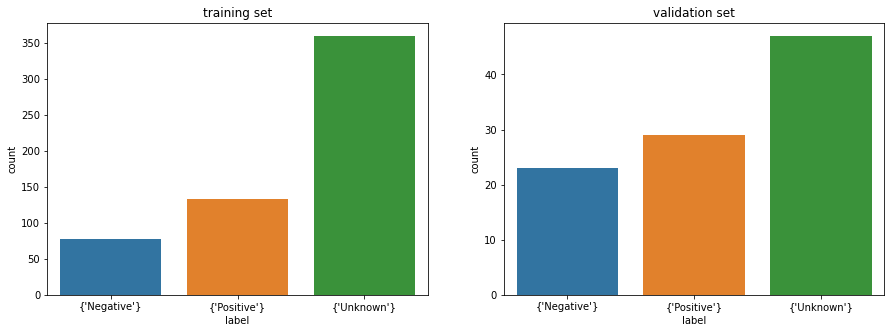

In [26]:
task_name = 'pr'
pprint.pprint('TRAINING SET')
df = pd.read_csv(os.path.join(data_dir, 'train_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
df = df.rename(columns={'label_' + task_name: 'label'})

df.dropna(inplace=True)
print('Columns: ', df.columns)
print('Size: ', len(df))
print('Labels: ', df['label'].sort_values().unique())

print('------------------------------------------------------------')

pprint.pprint('VALIDATION SET')
dev_set = pd.read_csv(os.path.join(data_dir, 'dev_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
dev_set = dev_set.rename(columns={'label_' + task_name: 'label'})
print('Columns: ', dev_set.columns)
print('Size: ', len(dev_set))
print('Labels: ', dev_set['label'].sort_values().unique())


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.countplot(data = df.sort_values('label'), x='label', ax=axes[0])
axes[0].set_title('training set')
sns.countplot(data = dev_set.sort_values('label'), x='label', ax=axes[1])
axes[1].set_title('validation set')
plt.show()

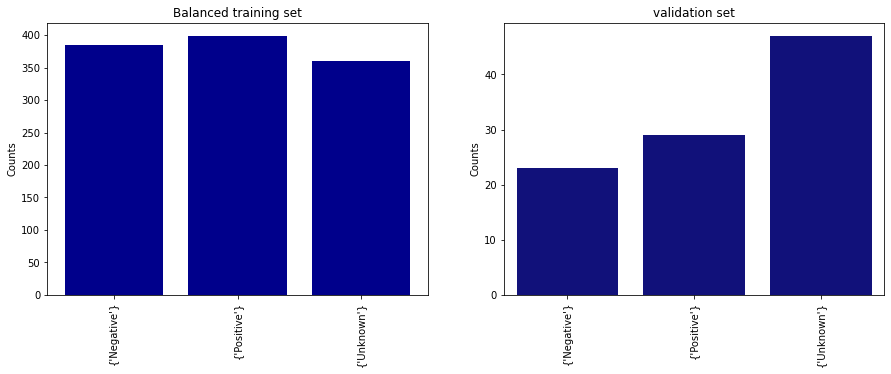

In [27]:
balanced_df = balanced(ohe_df(df, 'full_text')[0])

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.bar(balanced_df.iloc[:,1:].sum().index, balanced_df.iloc[:,1:].sum(), color='darkblue')
plt.xticks(rotation='vertical')
plt.ylabel('Counts')
plt.title('Balanced training set')

plt.subplot(1,2,2)
sns.countplot(data = dev_set.sort_values('label'), x='label', color='darkblue')
plt.title('validation set')
plt.xticks(rotation='vertical')
plt.xlabel('')
plt.ylabel('Counts')
plt.show()

plt.show()

In [28]:
best_params_, best_ngram, best_features, scores_L, results_ = Random_search(df, dev_set, 'full_text', stop_w = 'english')
dict_results['PR_SW'] = results_
dict_params['PR_SW'] = scores_L

features: 192, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.2s finished


training f1-score: 0.9921654215283023, training accuracy: 0.9929824561403509
validation f1-score: 0.6311379928315413, validation accuracy: 0.696969696969697
----------------------------------------------------------------------------------------------------
features: 770, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.885603686144496, training accuracy: 0.9175438596491228
validation f1-score: 0.5655576182889845, validation accuracy: 0.6565656565656566
----------------------------------------------------------------------------------------------------
features: 1348, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.9554278645489648, training accuracy: 0.9649122807017544
validation f1-score: 0.5993055555555555, validation accuracy: 0.6868686868686869
----------------------------------------------------------------------------------------------------
features: 1926, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.9532737340312435, training accuracy: 0.9631578947368421
validation f1-score: 0.5682484900776531, validation accuracy: 0.6565656565656566
----------------------------------------------------------------------------------------------------
features: 2504, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.9294345495707766, training accuracy: 0.9473684210526315
validation f1-score: 0.5814655172413793, validation accuracy: 0.6666666666666666
----------------------------------------------------------------------------------------------------
features: 3082, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.9491119154555815, training accuracy: 0.9596491228070175
validation f1-score: 0.5958661020367009, validation accuracy: 0.6767676767676768
----------------------------------------------------------------------------------------------------
features: 3660, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.9075890404029954, training accuracy: 0.9368421052631579
validation f1-score: 0.5424421009098429, validation accuracy: 0.6565656565656566
----------------------------------------------------------------------------------------------------
features: 4238, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9084166534776555, training accuracy: 0.9368421052631579
validation f1-score: 0.5661837913182, validation accuracy: 0.6666666666666666
----------------------------------------------------------------------------------------------------
features: 4816, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.9876624975516942, training accuracy: 0.9894736842105263
validation f1-score: 0.5677693208430914, validation accuracy: 0.6666666666666666
----------------------------------------------------------------------------------------------------
features: 412, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.9763063959739858, training accuracy: 0.9789473684210527
validation f1-score: 0.7356138272113751, validation accuracy: 0.7575757575757576
----------------------------------------------------------------------------------------------------
features: 1030, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.9721707305189242, training accuracy: 0.9754385964912281
validation f1-score: 0.6944904662248575, validation accuracy: 0.7373737373737373
----------------------------------------------------------------------------------------------------
features: 1717, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.9788316484992384, training accuracy: 0.980701754385965
validation f1-score: 0.7358156028368795, validation accuracy: 0.7474747474747475
----------------------------------------------------------------------------------------------------
features: 2061, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.9973590299118569, training accuracy: 0.9982456140350877
validation f1-score: 0.7638149381642307, validation accuracy: 0.7777777777777778
----------------------------------------------------------------------------------------------------
features: 8246, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.4s finished


training f1-score: 0.9706331551899418, training accuracy: 0.9736842105263158
validation f1-score: 0.641371158392435, validation accuracy: 0.696969696969697
----------------------------------------------------------------------------------------------------
features: 14431, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    2.1s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.3s finished


training f1-score: 0.9404531909129611, training accuracy: 0.9543859649122807
validation f1-score: 0.6602339181286548, validation accuracy: 0.7171717171717171
----------------------------------------------------------------------------------------------------
features: 20616, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.3s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    4.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.3s finished


training f1-score: 0.9924515575177827, training accuracy: 0.9929824561403509
validation f1-score: 0.6160768300060496, validation accuracy: 0.696969696969697
----------------------------------------------------------------------------------------------------
features: 26801, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.3s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.6s finished


training f1-score: 0.9417396403126178, training accuracy: 0.956140350877193
validation f1-score: 0.5948785828676014, validation accuracy: 0.6767676767676768
----------------------------------------------------------------------------------------------------
features: 32986, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.1s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    7.0s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.2s finished


training f1-score: 0.9924515575177827, training accuracy: 0.9929824561403509
validation f1-score: 0.5955513784461153, validation accuracy: 0.6868686868686869
----------------------------------------------------------------------------------------------------
features: 39171, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.8s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.0s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.2s finished


training f1-score: 0.9866399522967656, training accuracy: 0.9894736842105263
validation f1-score: 0.6187532323827623, validation accuracy: 0.6868686868686869
----------------------------------------------------------------------------------------------------
features: 45356, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.2s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.8s finished


training f1-score: 0.922299897341655, training accuracy: 0.9421052631578948
validation f1-score: 0.5765719815861059, validation accuracy: 0.6666666666666666
----------------------------------------------------------------------------------------------------
features: 1119, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.9273090645582648, training accuracy: 0.9473684210526315
validation f1-score: 0.6673387096774194, validation accuracy: 0.7272727272727273
----------------------------------------------------------------------------------------------------
features: 2797, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9973590299118569, training accuracy: 0.9982456140350877
validation f1-score: 0.8259466429679195, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 4662, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished


training f1-score: 0.9973590299118569, training accuracy: 0.9982456140350877
validation f1-score: 0.8237720571384921, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 5595, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.3s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.1s finished


training f1-score: 0.9973590299118569, training accuracy: 0.9982456140350877
validation f1-score: 0.7924479503426872, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 22383, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.8s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.6s finished


training f1-score: 0.9437884682315388, training accuracy: 0.9543859649122807
validation f1-score: 0.7187849456451998, validation accuracy: 0.7474747474747475
----------------------------------------------------------------------------------------------------
features: 39171, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.8s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    7.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.3s finished


training f1-score: 0.9367853981305906, training accuracy: 0.9526315789473684
validation f1-score: 0.6531193078324226, validation accuracy: 0.7171717171717171
----------------------------------------------------------------------------------------------------
features: 55959, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.6s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   10.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.1s finished


training f1-score: 0.9451741114980599, training accuracy: 0.9578947368421052
validation f1-score: 0.6333251813809407, validation accuracy: 0.696969696969697
----------------------------------------------------------------------------------------------------
features: 72747, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   12.4s remaining:   20.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   15.8s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   20.6s finished


training f1-score: 0.9420423692899488, training accuracy: 0.9526315789473684
validation f1-score: 0.674329928470038, validation accuracy: 0.7272727272727273
----------------------------------------------------------------------------------------------------
features: 89535, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   13.7s remaining:   22.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   19.3s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   23.6s finished


training f1-score: 0.991203118067096, training accuracy: 0.9929824561403509
validation f1-score: 0.6559010729223496, validation accuracy: 0.7272727272727273
----------------------------------------------------------------------------------------------------
features: 106323, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   21.3s remaining:   35.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   27.0s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   30.5s finished


training f1-score: 0.986175057638547, training accuracy: 0.987719298245614
validation f1-score: 0.6470003950561544, validation accuracy: 0.7272727272727273
----------------------------------------------------------------------------------------------------
features: 123111, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   23.7s remaining:   39.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   31.7s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   35.3s finished


training f1-score: 0.986175057638547, training accuracy: 0.987719298245614
validation f1-score: 0.6367439847997441, validation accuracy: 0.7171717171717171
----------------------------------------------------------------------------------------------------
Best Score:  0.8259466429679195
Best ngram: 3
Best feature: 2797
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': 40, 'max_depth': 25}


In [29]:
max_score_3, best_report_3 = Train_test(df=df,
                                        dev_set=dev_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w='english',
                                        enable_balance=True)

best accuracy score: 0.89
best f1 score:  0.88
best n_grams / number of features:  [3, 2797]
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.74      0.83        23
           1       0.81      0.90      0.85        29
           2       0.96      0.96      0.96        47

   micro avg       0.91      0.89      0.90        99
   macro avg       0.90      0.86      0.88        99
weighted avg       0.91      0.89      0.90        99
 samples avg       0.89      0.89      0.89        99

["{'Negative'}", "{'Positive'}", "{'Unknown'}"]


In [30]:
best_params_, best_ngram, best_features, scores_L, results_ = Random_search(df, dev_set, 'full_text', stop_w=None)
dict_results['PR_'] = results_
dict_params['PR_'] = scores_L

features: 201, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.9808610497289743, training accuracy: 0.9824561403508771
validation f1-score: 0.6167464743770305, validation accuracy: 0.696969696969697
----------------------------------------------------------------------------------------------------
features: 805, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.9756499706583394, training accuracy: 0.9789473684210527
validation f1-score: 0.6352513227513228, validation accuracy: 0.7070707070707071
----------------------------------------------------------------------------------------------------
features: 1409, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.9480997385103626, training accuracy: 0.9614035087719298
validation f1-score: 0.5924052641496335, validation accuracy: 0.6767676767676768
----------------------------------------------------------------------------------------------------
features: 2013, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.9415772604957868, training accuracy: 0.9578947368421052
validation f1-score: 0.6111333271811908, validation accuracy: 0.6767676767676768
----------------------------------------------------------------------------------------------------
features: 2617, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.9926264617117964, training accuracy: 0.9929824561403509
validation f1-score: 0.6337971365194596, validation accuracy: 0.6868686868686869
----------------------------------------------------------------------------------------------------
features: 3221, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9299666677147106, training accuracy: 0.9508771929824561
validation f1-score: 0.5459631501855706, validation accuracy: 0.6363636363636364
----------------------------------------------------------------------------------------------------
features: 3825, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.9540285214231584, training accuracy: 0.9649122807017544
validation f1-score: 0.5424421009098429, validation accuracy: 0.6565656565656566
----------------------------------------------------------------------------------------------------
features: 4429, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9866330950039935, training accuracy: 0.9894736842105263
validation f1-score: 0.5661837913182, validation accuracy: 0.6666666666666666
----------------------------------------------------------------------------------------------------
features: 438, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.995151714237049, training accuracy: 0.9964912280701754
validation f1-score: 0.6925458311299137, validation accuracy: 0.7373737373737373
----------------------------------------------------------------------------------------------------
features: 1096, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.9792901273483797, training accuracy: 0.980701754385965
validation f1-score: 0.753960764127202, validation accuracy: 0.7777777777777778
----------------------------------------------------------------------------------------------------
features: 1827, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.9973590299118569, training accuracy: 0.9982456140350877
validation f1-score: 0.8062567336228378, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 2193, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.9973590299118569, training accuracy: 0.9982456140350877
validation f1-score: 0.8233082706766917, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------
features: 8774, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.7s finished


training f1-score: 0.9973590299118569, training accuracy: 0.9982456140350877
validation f1-score: 0.6824561403508772, validation accuracy: 0.7272727272727273
----------------------------------------------------------------------------------------------------
features: 15355, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    2.2s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    3.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.7s finished


training f1-score: 0.9500936581767713, training accuracy: 0.9614035087719298
validation f1-score: 0.6501268540202966, validation accuracy: 0.7070707070707071
----------------------------------------------------------------------------------------------------
features: 21936, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.4s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    4.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.6s finished


training f1-score: 0.995151714237049, training accuracy: 0.9964912280701754
validation f1-score: 0.6494820024198428, validation accuracy: 0.7171717171717171
----------------------------------------------------------------------------------------------------
features: 28517, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.5s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.9s finished


training f1-score: 0.9929151625930382, training accuracy: 0.9947368421052631
validation f1-score: 0.6332989836535937, validation accuracy: 0.7070707070707071
----------------------------------------------------------------------------------------------------
features: 35098, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.2s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    7.0s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.3s finished


training f1-score: 0.9924515575177827, training accuracy: 0.9929824561403509
validation f1-score: 0.6299657188949385, validation accuracy: 0.7070707070707071
----------------------------------------------------------------------------------------------------
features: 41679, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.9s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.5s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.3s finished


training f1-score: 0.9303340019740823, training accuracy: 0.9421052631578948
validation f1-score: 0.6154040344275358, validation accuracy: 0.6868686868686869
----------------------------------------------------------------------------------------------------
features: 48260, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    7.0s remaining:   11.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.4s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.4s finished


training f1-score: 0.9929151625930382, training accuracy: 0.9947368421052631
validation f1-score: 0.6232040229885057, validation accuracy: 0.7070707070707071
----------------------------------------------------------------------------------------------------
features: 54841, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    7.7s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   10.7s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   11.6s finished


training f1-score: 0.9924515575177827, training accuracy: 0.9929824561403509
validation f1-score: 0.6500273308639993, validation accuracy: 0.7171717171717171
----------------------------------------------------------------------------------------------------
features: 1268, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.995151714237049, training accuracy: 0.9964912280701754
validation f1-score: 0.7470860946401582, validation accuracy: 0.7676767676767676
----------------------------------------------------------------------------------------------------
features: 3171, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.976439824189606, training accuracy: 0.9789473684210527
validation f1-score: 0.8524822695035462, validation accuracy: 0.8383838383838383
----------------------------------------------------------------------------------------------------
features: 5285, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.1s finished


training f1-score: 0.9257901753477508, training accuracy: 0.9421052631578948
validation f1-score: 0.8094378401486377, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 6343, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.4s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.3s finished


training f1-score: 0.9727379803562718, training accuracy: 0.9754385964912281
validation f1-score: 0.8341044919992289, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------
features: 25372, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.9s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.6s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.2s finished


training f1-score: 0.9973590299118569, training accuracy: 0.9982456140350877
validation f1-score: 0.8235824337071586, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------
features: 44401, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.2s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.4s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.5s finished


training f1-score: 0.9693848228095341, training accuracy: 0.9736842105263158
validation f1-score: 0.7454307865930142, validation accuracy: 0.7676767676767676
----------------------------------------------------------------------------------------------------
features: 63430, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    9.5s remaining:   15.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   12.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   14.1s finished


training f1-score: 0.995151714237049, training accuracy: 0.9964912280701754
validation f1-score: 0.6788823056104162, validation accuracy: 0.7272727272727273
----------------------------------------------------------------------------------------------------
features: 82459, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   13.3s remaining:   21.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   17.2s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   21.9s finished


training f1-score: 0.9414855012021404, training accuracy: 0.9526315789473684
validation f1-score: 0.622905643738977, validation accuracy: 0.696969696969697
----------------------------------------------------------------------------------------------------
features: 101488, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   16.6s remaining:   27.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   21.1s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   26.9s finished


training f1-score: 0.995151714237049, training accuracy: 0.9964912280701754
validation f1-score: 0.6193717444795961, validation accuracy: 0.696969696969697
----------------------------------------------------------------------------------------------------
features: 120517, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   24.4s remaining:   40.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   31.1s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   35.0s finished


training f1-score: 0.995151714237049, training accuracy: 0.9964912280701754
validation f1-score: 0.6419543482361818, validation accuracy: 0.7070707070707071
----------------------------------------------------------------------------------------------------
features: 139546, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   27.4s remaining:   45.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   36.9s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   41.4s finished


training f1-score: 0.9929151625930382, training accuracy: 0.9947368421052631
validation f1-score: 0.6809181354617005, validation accuracy: 0.7373737373737373
----------------------------------------------------------------------------------------------------
Best Score:  0.8524822695035462
Best ngram: 3
Best feature: 3171
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_leaf_nodes': 28, 'max_depth': 8}


In [31]:
max_score_3b, best_report_3b = Train_test(df=df,
                                        dev_set=dev_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w=None,
                                        enable_balance=True)

best accuracy score: 0.84
best f1 score:  0.86
best n_grams / number of features:  [3, 3171]
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.70      0.80        23
           1       0.88      0.76      0.81        29
           2       0.96      0.96      0.96        47

   micro avg       0.93      0.84      0.88        99
   macro avg       0.93      0.80      0.86        99
weighted avg       0.93      0.84      0.88        99
 samples avg       0.84      0.84      0.84        99

["{'Negative'}", "{'Positive'}", "{'Unknown'}"]


In [32]:
pprint.pprint('TEST SET')
test_set = pd.read_csv(os.path.join(data_dir, 'test_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
test_set = test_set.rename(columns={'label_' + task_name: 'label'})
print('Columns: ', test_set.columns)
print('Size: ', len(test_set))
print('Labels: ', test_set['label'].sort_values().unique())

test_score_3b, test_report_3b = Train_test(df=df,
                                        dev_set=test_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w=None,
                                        enable_balance=True)

'TEST SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  100
Labels:  ["{'Negative'}" "{'Positive'}" "{'Unknown'}"]
best accuracy score: 0.76
best f1 score:  0.79
best n_grams / number of features:  [3, 3171]
------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.94      0.48      0.64        31
           2       0.98      0.92      0.95        61

   micro avg       0.97      0.76      0.85       100
   macro avg       0.97      0.68      0.79       100
weighted avg       0.97      0.76      0.84       100
 samples avg       0.76      0.76      0.76       100

["{'Negative'}", "{'Positive'}", "{'Unknown'}"]


## HER2

'TRAINING SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  570
Labels:  ["{'Equivocal'}" "{'FISH_Negative'}" "{'FISH_Positive'}" "{'Negative'}"
 "{'Positive'}" "{'Unknown'}"]
------------------------------------------------------------
'VALIDATION SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  99
Labels:  ["{'Equivocal'}" "{'FISH_Negative'}" "{'FISH_Positive'}" "{'Negative'}"
 "{'Positive'}" "{'Unknown'}"]


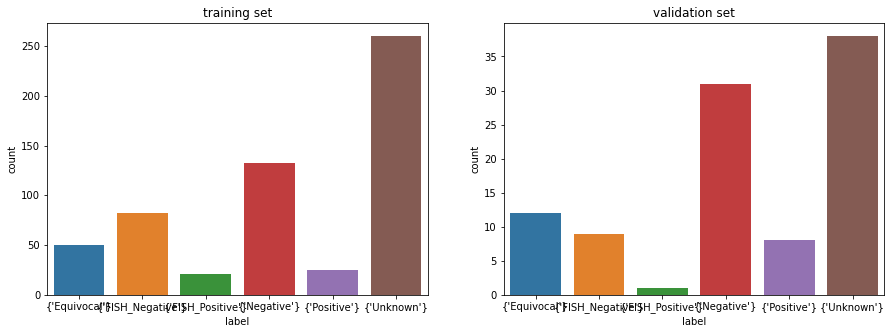

In [33]:
task_name = 'her2'
pprint.pprint('TRAINING SET')
df = pd.read_csv(os.path.join(data_dir, 'train_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
df = df.rename(columns={'label_' + task_name: 'label'})
print('Columns: ', df.columns)
print('Size: ', len(df))
print('Labels: ', df['label'].sort_values().unique())

print('------------------------------------------------------------')

pprint.pprint('VALIDATION SET')
dev_set = pd.read_csv(os.path.join(data_dir, 'dev_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
dev_set = dev_set.rename(columns={'label_' + task_name: 'label'})

print('Columns: ', dev_set.columns)
print('Size: ', len(dev_set))
print('Labels: ', dev_set['label'].sort_values().unique())


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.countplot(data = df.sort_values('label'), x='label', ax=axes[0])
axes[0].set_title('training set')
sns.countplot(data = dev_set.sort_values('label'), x='label', ax=axes[1])
axes[1].set_title('validation set')
plt.show()

In [34]:
# pprint.pprint('TRAINING SET')
# df = pd.read_csv(os.path.join(data_dir, 'train_her2.csv'))
# df = df[(df['label']!= "{'FISH_Negative'}")& (df['label']!= "{'FISH_Positive'}")]
# print('Columns: ', df.columns)
# print('Size: ', len(df))
# print('Labels: ', df['label'].sort_values().unique())

# print('------------------------------------------------------------')

# pprint.pprint('VALIDATION SET')
# dev_set = pd.read_csv(os.path.join(data_dir, 'dev_her2.csv'))
# dev_set = dev_set[(dev_set['label']!= "{'FISH_Negative'}")& (dev_set['label']!= "{'FISH_Positive'}")]


# print('Columns: ', dev_set.columns)
# print('Size: ', len(dev_set))
# print('Labels: ', dev_set['label'].sort_values().unique())


# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
# sns.countplot(data = df.sort_values('label'), x='label', ax=axes[0])
# axes[0].set_title('training set')
# sns.countplot(data = dev_set.sort_values('label'), x='label', ax=axes[1])
# axes[1].set_title('validation set')
# plt.show()

In [35]:
# df = pd.read_csv(os.path.join(data_dir, 'dev_her2.csv'))
# df['label'].unique()

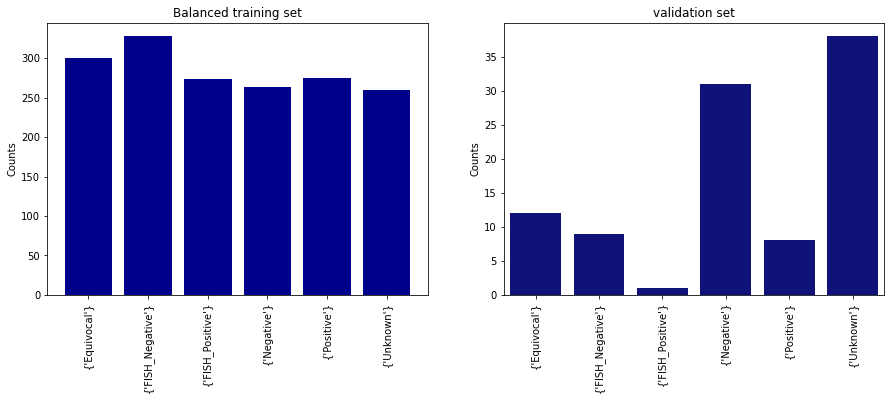

In [36]:
balanced_df = balanced(ohe_df(df, 'full_text')[0])

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.bar(balanced_df.iloc[:,1:].sum().index, balanced_df.iloc[:,1:].sum(), color='darkblue')
plt.xticks(rotation='vertical')
plt.ylabel('Counts')
plt.title('Balanced training set')

plt.subplot(1,2,2)
sns.countplot(data = dev_set.sort_values('label'), x='label', color='darkblue')
plt.title('validation set')
plt.xticks(rotation='vertical')
plt.xlabel('')
plt.ylabel('Counts')
plt.show()

plt.show()

In [37]:
best_params_, best_ngram, best_features, scores_L, results_ = Random_search(df, dev_set, 'full_text', stop_w = 'english')
dict_results['HER2_SW'] = results_
dict_params['HER2_SW'] = scores_L

features: 192, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.8156617582542927, training accuracy: 0.9052631578947369
validation f1-score: 0.4064290887335475, validation accuracy: 0.6565656565656566
----------------------------------------------------------------------------------------------------
features: 770, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.8466939208775522, training accuracy: 0.9175438596491228
validation f1-score: 0.38511323209759546, validation accuracy: 0.6262626262626263
----------------------------------------------------------------------------------------------------
features: 1348, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.7867069642843446, training accuracy: 0.9052631578947369
validation f1-score: 0.39579846968309607, validation accuracy: 0.6666666666666666
----------------------------------------------------------------------------------------------------
features: 1926, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.7608791425747524, training accuracy: 0.8894736842105263
validation f1-score: 0.3825674188222345, validation accuracy: 0.6464646464646465
----------------------------------------------------------------------------------------------------
features: 2504, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.7187667151764239, training accuracy: 0.8789473684210526
validation f1-score: 0.38338772472231764, validation accuracy: 0.6666666666666666
----------------------------------------------------------------------------------------------------
features: 3082, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.6950344475784576, training accuracy: 0.8701754385964913
validation f1-score: 0.38061594202898547, validation accuracy: 0.6464646464646465
----------------------------------------------------------------------------------------------------
features: 3660, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.6901177330646168, training accuracy: 0.8666666666666667
validation f1-score: 0.37707773941951156, validation accuracy: 0.6262626262626263
----------------------------------------------------------------------------------------------------
features: 4238, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.6900678579177565, training accuracy: 0.8666666666666667
validation f1-score: 0.38061594202898547, validation accuracy: 0.6464646464646465
----------------------------------------------------------------------------------------------------
features: 4816, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished


training f1-score: 0.6838841442889919, training accuracy: 0.8649122807017544
validation f1-score: 0.3756455066439952, validation accuracy: 0.6262626262626263
----------------------------------------------------------------------------------------------------
features: 412, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.8644358025637958, training accuracy: 0.9192982456140351
validation f1-score: 0.6229377104377104, validation accuracy: 0.6767676767676768
----------------------------------------------------------------------------------------------------
features: 1030, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.7890916860755598, training accuracy: 0.8982456140350877
validation f1-score: 0.41165261531317315, validation accuracy: 0.6666666666666666
----------------------------------------------------------------------------------------------------
features: 1717, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9005295423247777, training accuracy: 0.9421052631578948
validation f1-score: 0.4188955201886237, validation accuracy: 0.6464646464646465
----------------------------------------------------------------------------------------------------
features: 2061, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.9199579872529106, training accuracy: 0.9438596491228071
validation f1-score: 0.4183535931953654, validation accuracy: 0.6666666666666666
----------------------------------------------------------------------------------------------------
features: 8246, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.6s finished


training f1-score: 0.8635108073848793, training accuracy: 0.9263157894736842
validation f1-score: 0.3939386562804284, validation accuracy: 0.6565656565656566
----------------------------------------------------------------------------------------------------
features: 14431, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    2.1s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    3.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.4s finished


training f1-score: 0.8132189860770356, training accuracy: 0.9105263157894737
validation f1-score: 0.3955460041564331, validation accuracy: 0.6666666666666666
----------------------------------------------------------------------------------------------------
features: 20616, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.5s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.2s finished


training f1-score: 0.7606828344633628, training accuracy: 0.8929824561403509
validation f1-score: 0.39359452736318407, validation accuracy: 0.6666666666666666
----------------------------------------------------------------------------------------------------
features: 26801, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.9s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.6s finished


training f1-score: 0.7134705504628877, training accuracy: 0.8771929824561403
validation f1-score: 0.38759727005995664, validation accuracy: 0.6464646464646465
----------------------------------------------------------------------------------------------------
features: 32986, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.7s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    7.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.1s finished


training f1-score: 0.7036455385193109, training accuracy: 0.8736842105263158
validation f1-score: 0.3856837606837607, validation accuracy: 0.6363636363636364
----------------------------------------------------------------------------------------------------
features: 39171, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.6s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.0s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.1s finished


training f1-score: 0.5930108449766763, training accuracy: 0.8210526315789474
validation f1-score: 0.3836822460240182, validation accuracy: 0.6363636363636364
----------------------------------------------------------------------------------------------------
features: 45356, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.4s remaining:   10.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   11.1s finished


training f1-score: 0.6706399263170063, training accuracy: 0.8596491228070176
validation f1-score: 0.3806206310221047, validation accuracy: 0.6363636363636364
----------------------------------------------------------------------------------------------------
features: 1119, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.877012702934521, training accuracy: 0.9280701754385965
validation f1-score: 0.4026248509944163, validation accuracy: 0.6464646464646465
----------------------------------------------------------------------------------------------------
features: 2797, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.0s finished


training f1-score: 0.8023774767132238, training accuracy: 0.8947368421052632
validation f1-score: 0.5747863247863249, validation accuracy: 0.6565656565656566
----------------------------------------------------------------------------------------------------
features: 4662, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.3s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.2s finished


training f1-score: 0.9369360768964281, training accuracy: 0.9526315789473684
validation f1-score: 0.6724715099715101, validation accuracy: 0.7272727272727273
----------------------------------------------------------------------------------------------------
features: 5595, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.3s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.3s finished


training f1-score: 0.9258364291712785, training accuracy: 0.9473684210526315
validation f1-score: 0.7024204244031832, validation accuracy: 0.7373737373737373
----------------------------------------------------------------------------------------------------
features: 22383, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.8s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.8s finished


training f1-score: 0.8648961899991711, training accuracy: 0.9263157894736842
validation f1-score: 0.4498563218390805, validation accuracy: 0.6666666666666666
----------------------------------------------------------------------------------------------------
features: 39171, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.8s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.3s finished


training f1-score: 0.7860069151438352, training accuracy: 0.9035087719298246
validation f1-score: 0.4064097193129452, validation accuracy: 0.6464646464646465
----------------------------------------------------------------------------------------------------
features: 55959, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.5s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   11.1s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.1s finished


training f1-score: 0.7464348432038772, training accuracy: 0.8912280701754386
validation f1-score: 0.4044841565318111, validation accuracy: 0.6565656565656566
----------------------------------------------------------------------------------------------------
features: 72747, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   11.7s remaining:   19.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   16.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   19.7s finished


training f1-score: 0.7292045908469174, training accuracy: 0.887719298245614
validation f1-score: 0.39182807269249165, validation accuracy: 0.6464646464646465
----------------------------------------------------------------------------------------------------
features: 89535, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   15.1s remaining:   24.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   20.1s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   24.6s finished


training f1-score: 0.6990866221900705, training accuracy: 0.8666666666666667
validation f1-score: 0.4011946659005483, validation accuracy: 0.6464646464646465
----------------------------------------------------------------------------------------------------
features: 106323, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   20.7s remaining:   34.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   27.2s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   30.5s finished


training f1-score: 0.698919437355138, training accuracy: 0.8736842105263158
validation f1-score: 0.4014351661410485, validation accuracy: 0.6565656565656566
----------------------------------------------------------------------------------------------------
features: 123111, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   25.0s remaining:   41.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   32.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   36.6s finished


training f1-score: 0.6942825823631086, training accuracy: 0.8736842105263158
validation f1-score: 0.39753971208736666, validation accuracy: 0.6464646464646465
----------------------------------------------------------------------------------------------------
Best Score:  0.7024204244031832
Best ngram: 3
Best feature: 5595
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': 40, 'max_depth': 25}


In [38]:
max_score_4, best_report_4 = Train_test(df=df,
                                        dev_set=dev_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w='english',
                                        enable_balance=True)

#remove fish cases

best accuracy score: 0.72
best f1 score:  0.74
best n_grams / number of features:  [3, 5595]
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        12
           1       1.00      0.78      0.88         9
           2       1.00      1.00      1.00         1
           3       0.90      0.58      0.71        31
           4       1.00      0.12      0.22         8
           5       0.95      0.95      0.95        38

   micro avg       0.90      0.72      0.80        99
   macro avg       0.92      0.68      0.74        99
weighted avg       0.91      0.72      0.77        99
 samples avg       0.72      0.72      0.72        99

["{'Equivocal'}", "{'FISH_Negative'}", "{'FISH_Positive'}", "{'Negative'}", "{'Positive'}", "{'Unknown'}"]


In [39]:
pprint.pprint('TEST SET')
test_set = pd.read_csv(os.path.join(data_dir, 'test_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
test_set = test_set.rename(columns={'label_' + task_name: 'label'})
print('Columns: ', test_set.columns)
print('Size: ', len(test_set))
print('Labels: ', test_set['label'].sort_values().unique())

test_score_4, test_report_4 = Train_test(df=df,
                                        dev_set=test_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w='english',
                                        enable_balance=True)

'TEST SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  100
Labels:  ["{'Equivocal'}" "{'FISH_Negative'}" "{'FISH_Positive'}" "{'Negative'}"
 "{'Positive'}" "{'Unknown'}"]
best accuracy score: 0.69
best f1 score:  0.69
best n_grams / number of features:  [3, 5595]
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       1.00      0.60      0.75        10
           2       1.00      1.00      1.00         3
           3       1.00      0.30      0.46        20
           4       1.00      0.25      0.40         4
           5       0.94      0.91      0.92        53

   micro avg       0.93      0.69      0.79       100
   macro avg       0.94      0.59      0.69       100
weighted avg       0.94      0.69      0.76       100
 samples avg       0.69      0.69      0.69       100

["{'Equivocal'}", "{'FISH_Negative'}", "{'FISH_Positive'}"

In [40]:
best_params_, best_ngram, best_features, scores_L, results_ = Random_search(df, dev_set, 'full_text', stop_w = None)
dict_results['HER2_'] = results_
dict_params['HER2_'] = scores_L

features: 201, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.8522234512658531, training accuracy: 0.9210526315789473
validation f1-score: 0.5672292545710268, validation accuracy: 0.6767676767676768
----------------------------------------------------------------------------------------------------
features: 805, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.7692184677345919, training accuracy: 0.8859649122807017
validation f1-score: 0.36952736318407964, validation accuracy: 0.6161616161616161
----------------------------------------------------------------------------------------------------
features: 1409, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.8264103743645624, training accuracy: 0.9157894736842105
validation f1-score: 0.3922292545710267, validation accuracy: 0.6666666666666666
----------------------------------------------------------------------------------------------------
features: 2013, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.7525811346079032, training accuracy: 0.887719298245614
validation f1-score: 0.38354356772231174, validation accuracy: 0.6565656565656566
----------------------------------------------------------------------------------------------------
features: 2617, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.7448318570141891, training accuracy: 0.8842105263157894
validation f1-score: 0.38405931993050385, validation accuracy: 0.6464646464646465
----------------------------------------------------------------------------------------------------
features: 3221, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.61897849495728, training accuracy: 0.8315789473684211
validation f1-score: 0.3771129293292573, validation accuracy: 0.6464646464646465
----------------------------------------------------------------------------------------------------
features: 3825, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.6983991727439448, training accuracy: 0.8824561403508772
validation f1-score: 0.3817409864258952, validation accuracy: 0.6464646464646465
----------------------------------------------------------------------------------------------------
features: 4429, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.0s finished


training f1-score: 0.6274791204963619, training accuracy: 0.8368421052631579
validation f1-score: 0.37827347549569773, validation accuracy: 0.6363636363636364
----------------------------------------------------------------------------------------------------
features: 438, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.8952260888411457, training accuracy: 0.9403508771929825
validation f1-score: 0.5744341563786008, validation accuracy: 0.6565656565656566
----------------------------------------------------------------------------------------------------
features: 1096, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9037171294108552, training accuracy: 0.9421052631578948
validation f1-score: 0.43021924312246895, validation accuracy: 0.6565656565656566
----------------------------------------------------------------------------------------------------
features: 1827, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9245206448572278, training accuracy: 0.9456140350877194
validation f1-score: 0.5669787991976205, validation accuracy: 0.6363636363636364
----------------------------------------------------------------------------------------------------
features: 2193, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.0s finished


training f1-score: 0.921663125880858, training accuracy: 0.9491228070175438
validation f1-score: 0.5781465398400882, validation accuracy: 0.6565656565656566
----------------------------------------------------------------------------------------------------
features: 8774, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.7s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.9s finished


training f1-score: 0.8752232153744389, training accuracy: 0.9315789473684211
validation f1-score: 0.39356060606060606, validation accuracy: 0.6464646464646465
----------------------------------------------------------------------------------------------------
features: 15355, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    2.3s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    3.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.8s finished


training f1-score: 0.7474125906792907, training accuracy: 0.8824561403508772
validation f1-score: 0.39751359751359755, validation accuracy: 0.6464646464646465
----------------------------------------------------------------------------------------------------
features: 21936, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.6s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.8s finished


training f1-score: 0.7817122285372031, training accuracy: 0.8964912280701754
validation f1-score: 0.39226190476190476, validation accuracy: 0.6565656565656566
----------------------------------------------------------------------------------------------------
features: 28517, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.3s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    7.1s finished


training f1-score: 0.6599030744217398, training accuracy: 0.8508771929824561
validation f1-score: 0.3902777777777778, validation accuracy: 0.6565656565656566
----------------------------------------------------------------------------------------------------
features: 35098, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.2s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    7.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.8s finished


training f1-score: 0.7480743467578838, training accuracy: 0.8842105263157894
validation f1-score: 0.38392857142857145, validation accuracy: 0.6565656565656566
----------------------------------------------------------------------------------------------------
features: 41679, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.0s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.4s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.6s finished


training f1-score: 0.6947825684804246, training accuracy: 0.8701754385964913
validation f1-score: 0.3806206310221047, validation accuracy: 0.6363636363636364
----------------------------------------------------------------------------------------------------
features: 48260, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    7.2s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.9s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.0s finished


training f1-score: 0.6808833673730761, training accuracy: 0.868421052631579
validation f1-score: 0.38759727005995664, validation accuracy: 0.6464646464646465
----------------------------------------------------------------------------------------------------
features: 54841, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.4s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   11.4s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   13.2s finished


training f1-score: 0.5993523884299327, training accuracy: 0.8315789473684211
validation f1-score: 0.3653535940121306, validation accuracy: 0.6060606060606061
----------------------------------------------------------------------------------------------------
features: 1268, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.0s finished


training f1-score: 0.898806099315096, training accuracy: 0.9385964912280702
validation f1-score: 0.4008279914529915, validation accuracy: 0.6464646464646465
----------------------------------------------------------------------------------------------------
features: 3171, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.2s finished


training f1-score: 0.9460198105739507, training accuracy: 0.9596491228070175
validation f1-score: 0.583201476793249, validation accuracy: 0.6767676767676768
----------------------------------------------------------------------------------------------------
features: 5285, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.5s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.4s finished


training f1-score: 0.94891620051353, training accuracy: 0.9596491228070175
validation f1-score: 0.6039529914529916, validation accuracy: 0.6666666666666666
----------------------------------------------------------------------------------------------------
features: 6343, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.5s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.4s finished


training f1-score: 0.9613114267817705, training accuracy: 0.968421052631579
validation f1-score: 0.6663481315124844, validation accuracy: 0.7272727272727273
----------------------------------------------------------------------------------------------------
features: 25372, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.9s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.6s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.5s finished


training f1-score: 0.9234217123909345, training accuracy: 0.9473684210526315
validation f1-score: 0.5547766019988243, validation accuracy: 0.6868686868686869
----------------------------------------------------------------------------------------------------
features: 44401, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    7.0s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.2s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.9s finished


training f1-score: 0.8595171490099726, training accuracy: 0.9245614035087719
validation f1-score: 0.4165348101265823, validation accuracy: 0.6666666666666666
----------------------------------------------------------------------------------------------------
features: 63430, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.8s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   13.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   15.1s finished


training f1-score: 0.8230199776022519, training accuracy: 0.9122807017543859
validation f1-score: 0.3989042131116569, validation accuracy: 0.6565656565656566
----------------------------------------------------------------------------------------------------
features: 82459, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   13.8s remaining:   22.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   18.1s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   22.3s finished


training f1-score: 0.7724317092133185, training accuracy: 0.8964912280701754
validation f1-score: 0.38332398054620276, validation accuracy: 0.6464646464646465
----------------------------------------------------------------------------------------------------
features: 101488, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   17.3s remaining:   28.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   21.3s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   26.7s finished


training f1-score: 0.748289381530693, training accuracy: 0.8912280701754386
validation f1-score: 0.38332398054620276, validation accuracy: 0.6464646464646465
----------------------------------------------------------------------------------------------------
features: 120517, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   25.0s remaining:   41.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   32.0s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   35.4s finished


training f1-score: 0.7177855947359041, training accuracy: 0.8807017543859649
validation f1-score: 0.3958991805677495, validation accuracy: 0.6565656565656566
----------------------------------------------------------------------------------------------------
features: 139546, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   26.4s remaining:   43.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   38.0s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   39.6s finished


training f1-score: 0.5543253968253968, training accuracy: 0.8017543859649123
validation f1-score: 0.39398567119155353, validation accuracy: 0.6464646464646465
----------------------------------------------------------------------------------------------------
Best Score:  0.6663481315124844
Best ngram: 3
Best feature: 6343
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': 40, 'max_depth': 25}


In [41]:
max_score_4b, best_report_4b = Train_test(df=df,
                                        dev_set=dev_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w=None,
                                        enable_balance=True)

best accuracy score: 0.69
best f1 score:  0.69
best n_grams / number of features:  [3, 6343]
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.50      0.60        12
           1       1.00      0.78      0.88         9
           2       1.00      1.00      1.00         1
           3       0.86      0.58      0.69        31
           4       0.00      0.00      0.00         8
           5       0.95      0.95      0.95        38

   micro avg       0.91      0.69      0.78        99
   macro avg       0.76      0.63      0.69        99
weighted avg       0.82      0.69      0.74        99
 samples avg       0.69      0.69      0.69        99

["{'Equivocal'}", "{'FISH_Negative'}", "{'FISH_Positive'}", "{'Negative'}", "{'Positive'}", "{'Unknown'}"]


## Biopsy

'TRAINING SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  570
Labels:  ["{'Biopsy'}" "{'Lumpectomy'}" "{'Mastectomy'}" "{'Unknown'}"]
------------------------------------------------------------
'VALIDATION SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  99
Labels:  ["{'Biopsy'}" "{'Lumpectomy'}" "{'Mastectomy'}" "{'Unknown'}"]


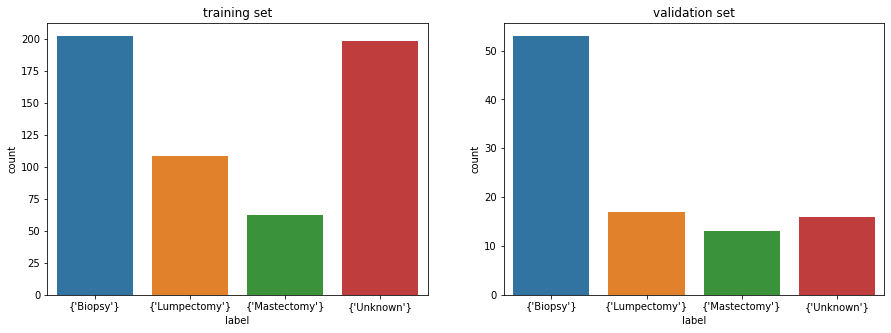

In [42]:
task_name = 'biopsy'
pprint.pprint('TRAINING SET')
df = pd.read_csv(os.path.join(data_dir, 'train_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
df = df.rename(columns={'label_' + task_name: 'label'})
print('Columns: ', df.columns)
print('Size: ', len(df))
print('Labels: ', df['label'].sort_values().unique())

print('------------------------------------------------------------')

pprint.pprint('VALIDATION SET')
dev_set = pd.read_csv(os.path.join(data_dir, 'dev_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
dev_set = dev_set.rename(columns={'label_' + task_name: 'label'})

print('Columns: ', dev_set.columns)
print('Size: ', len(dev_set))
print('Labels: ', dev_set['label'].sort_values().unique())


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.countplot(data = df.sort_values('label'), x='label', ax=axes[0])
axes[0].set_title('training set')
sns.countplot(data = dev_set.sort_values('label'), x='label', ax=axes[1])
axes[1].set_title('validation set')
plt.show()

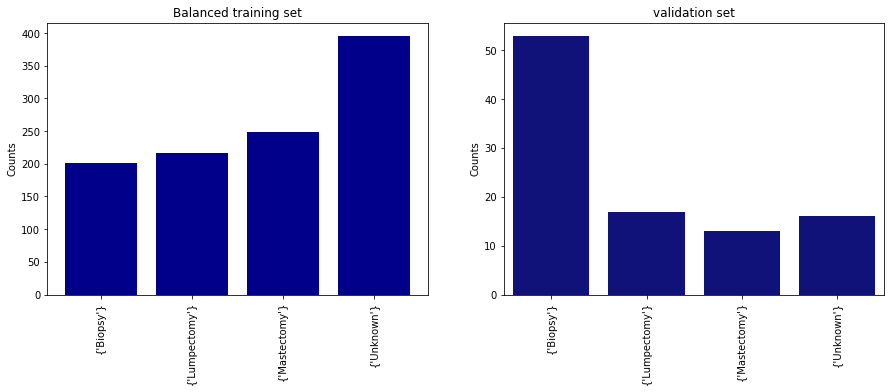

In [43]:
balanced_df = balanced(ohe_df(df, 'full_text')[0])

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.bar(balanced_df.iloc[:,1:].sum().index, balanced_df.iloc[:,1:].sum(), color='darkblue')
plt.xticks(rotation='vertical')
plt.ylabel('Counts')
plt.title('Balanced training set')

plt.subplot(1,2,2)
sns.countplot(data = dev_set.sort_values('label'), x='label', color='darkblue')
plt.title('validation set')
plt.xticks(rotation='vertical')
plt.xlabel('')
plt.ylabel('Counts')
plt.show()

plt.show()

In [44]:
best_params_, best_ngram, best_features, scores_L, results_ = Random_search(df, dev_set, 'full_text', stop_w='english')
dict_results['BIOPSY_SW'] = results_
dict_params['BIOPSY_SW'] = scores_L

features: 192, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.8673544766948754, training accuracy: 0.8350877192982457
validation f1-score: 0.7610561056105611, validation accuracy: 0.7777777777777778
----------------------------------------------------------------------------------------------------
features: 770, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.910273501527374, training accuracy: 0.875438596491228
validation f1-score: 0.7481725146198831, validation accuracy: 0.7575757575757576
----------------------------------------------------------------------------------------------------
features: 1348, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.8409488113086313, training accuracy: 0.7929824561403509
validation f1-score: 0.7432759497109348, validation accuracy: 0.7474747474747475
----------------------------------------------------------------------------------------------------
features: 1926, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.8864167962897582, training accuracy: 0.8526315789473684
validation f1-score: 0.727188758820833, validation accuracy: 0.7474747474747475
----------------------------------------------------------------------------------------------------
features: 2504, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.8874255035107204, training accuracy: 0.8543859649122807
validation f1-score: 0.7328216374269007, validation accuracy: 0.7575757575757576
----------------------------------------------------------------------------------------------------
features: 3082, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.8851350886103041, training accuracy: 0.843859649122807
validation f1-score: 0.74113759821982, validation accuracy: 0.7575757575757576
----------------------------------------------------------------------------------------------------
features: 3660, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.8728976391320069, training accuracy: 0.8368421052631579
validation f1-score: 0.7138473810576863, validation accuracy: 0.7474747474747475
----------------------------------------------------------------------------------------------------
features: 4238, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.8425547093680843, training accuracy: 0.8035087719298246
validation f1-score: 0.6630412300055157, validation accuracy: 0.696969696969697
----------------------------------------------------------------------------------------------------
features: 4816, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.8189772079522661, training accuracy: 0.7719298245614035
validation f1-score: 0.7193831699346406, validation accuracy: 0.7272727272727273
----------------------------------------------------------------------------------------------------
features: 412, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.89388853832994, training accuracy: 0.8578947368421053
validation f1-score: 0.7500477750477751, validation accuracy: 0.7777777777777778
----------------------------------------------------------------------------------------------------
features: 1030, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.8793623043623044, training accuracy: 0.8421052631578947
validation f1-score: 0.7521895940235603, validation accuracy: 0.7575757575757576
----------------------------------------------------------------------------------------------------
features: 1717, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.8446787674507632, training accuracy: 0.7947368421052632
validation f1-score: 0.7668797476939772, validation accuracy: 0.7676767676767676
----------------------------------------------------------------------------------------------------
features: 2061, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.90503981135375, training accuracy: 0.875438596491228
validation f1-score: 0.7614486584107327, validation accuracy: 0.7474747474747475
----------------------------------------------------------------------------------------------------
features: 8246, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.4s finished


training f1-score: 0.8962089466459158, training accuracy: 0.8614035087719298
validation f1-score: 0.725139392100693, validation accuracy: 0.7373737373737373
----------------------------------------------------------------------------------------------------
features: 14431, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    2.2s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    3.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.3s finished


training f1-score: 0.8802679914858794, training accuracy: 0.8403508771929824
validation f1-score: 0.7047810678325385, validation accuracy: 0.7272727272727273
----------------------------------------------------------------------------------------------------
features: 20616, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.6s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    4.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.2s finished


training f1-score: 0.8746532117618931, training accuracy: 0.8350877192982457
validation f1-score: 0.6634889533152064, validation accuracy: 0.696969696969697
----------------------------------------------------------------------------------------------------
features: 26801, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.2s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.6s finished


training f1-score: 0.83500607969901, training accuracy: 0.787719298245614
validation f1-score: 0.6823139888609657, validation accuracy: 0.6868686868686869
----------------------------------------------------------------------------------------------------
features: 32986, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.2s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    7.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    7.6s finished


training f1-score: 0.866200653999506, training accuracy: 0.8228070175438597
validation f1-score: 0.6815260012868639, validation accuracy: 0.6868686868686869
----------------------------------------------------------------------------------------------------
features: 39171, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.5s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.3s finished


training f1-score: 0.8640046794820665, training accuracy: 0.8210526315789474
validation f1-score: 0.6786794834685049, validation accuracy: 0.7070707070707071
----------------------------------------------------------------------------------------------------
features: 45356, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.7s remaining:   11.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   10.1s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.8s finished


training f1-score: 0.8526669003945184, training accuracy: 0.8035087719298246
validation f1-score: 0.6548423423423424, validation accuracy: 0.6767676767676768
----------------------------------------------------------------------------------------------------
features: 1119, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.8667700422826997, training accuracy: 0.8228070175438597
validation f1-score: 0.7854846792668958, validation accuracy: 0.7777777777777778
----------------------------------------------------------------------------------------------------
features: 2797, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.0s finished


training f1-score: 0.9037368875692628, training accuracy: 0.8736842105263158
validation f1-score: 0.7835654690974733, validation accuracy: 0.7777777777777778
----------------------------------------------------------------------------------------------------
features: 4662, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.1s finished


training f1-score: 0.8852817715786968, training accuracy: 0.8491228070175438
validation f1-score: 0.7551614114114115, validation accuracy: 0.7575757575757576
----------------------------------------------------------------------------------------------------
features: 5595, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.4s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.1s finished


training f1-score: 0.9062774412807527, training accuracy: 0.8771929824561403
validation f1-score: 0.7499086257309941, validation accuracy: 0.7474747474747475
----------------------------------------------------------------------------------------------------
features: 22383, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.5s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.5s finished


training f1-score: 0.895097259379883, training accuracy: 0.8578947368421053
validation f1-score: 0.7045906478492854, validation accuracy: 0.7070707070707071
----------------------------------------------------------------------------------------------------
features: 39171, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.0s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.4s finished


training f1-score: 0.875635940751622, training accuracy: 0.8385964912280702
validation f1-score: 0.6704598991242656, validation accuracy: 0.7070707070707071
----------------------------------------------------------------------------------------------------
features: 55959, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.0s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   11.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   13.2s finished


training f1-score: 0.873003682259232, training accuracy: 0.8298245614035088
validation f1-score: 0.6732078039927405, validation accuracy: 0.696969696969697
----------------------------------------------------------------------------------------------------
features: 72747, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   10.8s remaining:   17.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   15.9s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   18.6s finished


training f1-score: 0.8672277963245758, training accuracy: 0.8298245614035088
validation f1-score: 0.6741404923599321, validation accuracy: 0.696969696969697
----------------------------------------------------------------------------------------------------
features: 89535, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   13.8s remaining:   22.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   19.1s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   24.5s finished


training f1-score: 0.8496582638244512, training accuracy: 0.8105263157894737
validation f1-score: 0.6530058983666063, validation accuracy: 0.6767676767676768
----------------------------------------------------------------------------------------------------
features: 106323, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   20.5s remaining:   33.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   27.8s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   32.6s finished


training f1-score: 0.8496825427783845, training accuracy: 0.8105263157894737
validation f1-score: 0.6413063909774437, validation accuracy: 0.6666666666666666
----------------------------------------------------------------------------------------------------
features: 123111, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   25.5s remaining:   42.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   32.1s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   34.9s finished


training f1-score: 0.8443255614605478, training accuracy: 0.8017543859649123
validation f1-score: 0.643681628056628, validation accuracy: 0.6666666666666666
----------------------------------------------------------------------------------------------------
Best Score:  0.7854846792668958
Best ngram: 3
Best feature: 1119
Best Hyperparameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_leaf_nodes': 32, 'max_depth': 15}


In [45]:
max_score_5, best_report_5 = Train_test(df=df,
                                        dev_set=dev_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w='english',
                                        enable_balance=True)

best accuracy score: 0.62
best f1 score:  0.7
best n_grams / number of features:  [3, 1119]
------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.51      0.67        53
           1       0.87      0.76      0.81        17
           2       1.00      0.54      0.70        13
           3       0.45      0.88      0.60        16

   micro avg       0.76      0.62      0.68        99
   macro avg       0.83      0.67      0.70        99
weighted avg       0.89      0.62      0.69        99
 samples avg       0.62      0.62      0.62        99

["{'Biopsy'}", "{'Lumpectomy'}", "{'Mastectomy'}", "{'Unknown'}"]


In [46]:
pprint.pprint('TEST SET')
test_set = pd.read_csv(os.path.join(data_dir, 'test_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
test_set = test_set.rename(columns={'label_' + task_name: 'label'})
print('Columns: ', test_set.columns)
print('Size: ', len(test_set))
print('Labels: ', test_set['label'].sort_values().unique())

test_score_5, test_report_5 = Train_test(df=df,
                                        dev_set=test_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w='english',
                                        enable_balance=True)

'TEST SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  100
Labels:  ["{'Biopsy'}" "{'Lumpectomy'}" "{'Mastectomy'}" "{'Unknown'}"]
best accuracy score: 0.68
best f1 score:  0.75
best n_grams / number of features:  [3, 1119]
------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.52      0.68        33
           1       0.88      0.74      0.80        19
           2       1.00      0.59      0.74        22
           3       0.65      0.92      0.76        26

   micro avg       0.82      0.68      0.74       100
   macro avg       0.88      0.69      0.75       100
weighted avg       0.88      0.68      0.74       100
 samples avg       0.68      0.68      0.68       100

["{'Biopsy'}", "{'Lumpectomy'}", "{'Mastectomy'}", "{'Unknown'}"]


In [47]:
best_params_, best_ngram, best_features, scores_L, results_ = Random_search(df, dev_set, 'full_text', stop_w=None)
dict_results['BIOPSY_'] = results_
dict_params['BIOPSY_'] = scores_L

features: 201, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.7986319810130007, training accuracy: 0.7596491228070176
validation f1-score: 0.7525678739964455, validation accuracy: 0.7575757575757576
----------------------------------------------------------------------------------------------------
features: 805, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.8664396173436995, training accuracy: 0.8245614035087719
validation f1-score: 0.762281797664151, validation accuracy: 0.7575757575757576
----------------------------------------------------------------------------------------------------
features: 1409, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.8636132131354811, training accuracy: 0.8245614035087719
validation f1-score: 0.768909386869235, validation accuracy: 0.7676767676767676
----------------------------------------------------------------------------------------------------
features: 2013, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.8971686355473378, training accuracy: 0.8614035087719298
validation f1-score: 0.7136334039393567, validation accuracy: 0.7272727272727273
----------------------------------------------------------------------------------------------------
features: 2617, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.8856197197529976, training accuracy: 0.8491228070175438
validation f1-score: 0.7146212651727357, validation accuracy: 0.7171717171717171
----------------------------------------------------------------------------------------------------
features: 3221, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.8875159946467289, training accuracy: 0.8508771929824561
validation f1-score: 0.700926424514111, validation accuracy: 0.7272727272727273
----------------------------------------------------------------------------------------------------
features: 3825, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.8807811059481989, training accuracy: 0.8421052631578947
validation f1-score: 0.6857836555674902, validation accuracy: 0.7272727272727273
----------------------------------------------------------------------------------------------------
features: 4429, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.8290152123562325, training accuracy: 0.7771929824561403
validation f1-score: 0.7113094200827623, validation accuracy: 0.7272727272727273
----------------------------------------------------------------------------------------------------
features: 438, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.9030271469262282, training accuracy: 0.8701754385964913
validation f1-score: 0.7355994152046784, validation accuracy: 0.7676767676767676
----------------------------------------------------------------------------------------------------
features: 1096, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.8956939155567321, training accuracy: 0.8578947368421053
validation f1-score: 0.7455602084361483, validation accuracy: 0.7575757575757576
----------------------------------------------------------------------------------------------------
features: 1827, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.8433497368822871, training accuracy: 0.8052631578947368
validation f1-score: 0.7668797476939772, validation accuracy: 0.7676767676767676
----------------------------------------------------------------------------------------------------
features: 2193, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.8836013503206231, training accuracy: 0.8403508771929824
validation f1-score: 0.7540977928067591, validation accuracy: 0.7474747474747475
----------------------------------------------------------------------------------------------------
features: 8774, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.7s finished


training f1-score: 0.8993208399836489, training accuracy: 0.868421052631579
validation f1-score: 0.7176281944583154, validation accuracy: 0.7474747474747475
----------------------------------------------------------------------------------------------------
features: 15355, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    2.1s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    3.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.7s finished


training f1-score: 0.8883307078918843, training accuracy: 0.8491228070175438
validation f1-score: 0.6666666666666667, validation accuracy: 0.7070707070707071
----------------------------------------------------------------------------------------------------
features: 21936, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.3s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.6s finished


training f1-score: 0.8692948922296077, training accuracy: 0.8333333333333334
validation f1-score: 0.6577418268784249, validation accuracy: 0.696969696969697
----------------------------------------------------------------------------------------------------
features: 28517, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.2s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.8s finished


training f1-score: 0.8741627441255434, training accuracy: 0.8315789473684211
validation f1-score: 0.6749812312312312, validation accuracy: 0.7171717171717171
----------------------------------------------------------------------------------------------------
features: 35098, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.0s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    7.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.1s finished


training f1-score: 0.8682465629908255, training accuracy: 0.8245614035087719
validation f1-score: 0.6744084935450915, validation accuracy: 0.7070707070707071
----------------------------------------------------------------------------------------------------
features: 41679, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.3s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.3s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.0s finished


training f1-score: 0.8642354851451772, training accuracy: 0.8210526315789474
validation f1-score: 0.6692538543698338, validation accuracy: 0.696969696969697
----------------------------------------------------------------------------------------------------
features: 48260, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    7.1s remaining:   11.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   10.4s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   11.9s finished


training f1-score: 0.8529796091425068, training accuracy: 0.8157894736842105
validation f1-score: 0.6392173423423424, validation accuracy: 0.6767676767676768
----------------------------------------------------------------------------------------------------
features: 54841, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.0s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   10.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.3s finished


training f1-score: 0.8628712101248422, training accuracy: 0.8157894736842105
validation f1-score: 0.6603805253574839, validation accuracy: 0.7171717171717171
----------------------------------------------------------------------------------------------------
features: 1268, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.8923436572984343, training accuracy: 0.8614035087719298
validation f1-score: 0.7396162068614477, validation accuracy: 0.7272727272727273
----------------------------------------------------------------------------------------------------
features: 3171, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.0s finished


training f1-score: 0.8775281517791857, training accuracy: 0.843859649122807
validation f1-score: 0.761684944707016, validation accuracy: 0.7474747474747475
----------------------------------------------------------------------------------------------------
features: 5285, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.5s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.4s finished


training f1-score: 0.8463810191721306, training accuracy: 0.7982456140350878
validation f1-score: 0.7630332934609251, validation accuracy: 0.7676767676767676
----------------------------------------------------------------------------------------------------
features: 6343, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.5s finished


training f1-score: 0.8718219227490327, training accuracy: 0.8456140350877193
validation f1-score: 0.7207153694811258, validation accuracy: 0.7373737373737373
----------------------------------------------------------------------------------------------------
features: 25372, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.3s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.6s finished


training f1-score: 0.8660455319917401, training accuracy: 0.8333333333333334
validation f1-score: 0.7164622161402943, validation accuracy: 0.7171717171717171
----------------------------------------------------------------------------------------------------
features: 44401, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.5s remaining:   10.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.0s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   11.3s finished


training f1-score: 0.8758505117136345, training accuracy: 0.8368421052631579
validation f1-score: 0.6777387737777625, validation accuracy: 0.7171717171717171
----------------------------------------------------------------------------------------------------
features: 63430, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.6s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   13.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   16.2s finished


training f1-score: 0.8697701501235312, training accuracy: 0.8350877192982457
validation f1-score: 0.6616776315789474, validation accuracy: 0.6868686868686869
----------------------------------------------------------------------------------------------------
features: 82459, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   12.9s remaining:   21.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   19.5s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   24.3s finished


training f1-score: 0.8581071959126048, training accuracy: 0.8175438596491228
validation f1-score: 0.6364056199818731, validation accuracy: 0.6868686868686869
----------------------------------------------------------------------------------------------------
features: 101488, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   15.9s remaining:   26.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   25.4s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   27.1s finished


training f1-score: 0.8599737223760532, training accuracy: 0.8192982456140351
validation f1-score: 0.6405706807340934, validation accuracy: 0.6565656565656566
----------------------------------------------------------------------------------------------------
features: 120517, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   26.5s remaining:   43.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   32.3s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   37.6s finished


training f1-score: 0.8561309137710255, training accuracy: 0.8192982456140351
validation f1-score: 0.6236747580157291, validation accuracy: 0.6666666666666666
----------------------------------------------------------------------------------------------------
features: 139546, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   28.8s remaining:   47.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   37.9s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   39.2s finished


training f1-score: 0.8157251646081705, training accuracy: 0.7719298245614035
validation f1-score: 0.6119752506265665, validation accuracy: 0.6565656565656566
----------------------------------------------------------------------------------------------------
Best Score:  0.768909386869235
Best ngram: 1
Best feature: 1409
Best Hyperparameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_leaf_nodes': 32, 'max_depth': 15}


In [48]:
max_score_5b, best_report_5b = Train_test(df=df,
                                        dev_set=dev_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w=None,
                                        enable_balance=True)

best accuracy score: 0.6
best f1 score:  0.68
best n_grams / number of features:  [1, 1409]
------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.51      0.67        53
           1       0.80      0.71      0.75        17
           2       1.00      0.46      0.63        13
           3       0.52      0.88      0.65        16

   micro avg       0.79      0.60      0.68        99
   macro avg       0.83      0.64      0.68        99
weighted avg       0.89      0.60      0.68        99
 samples avg       0.60      0.60      0.60        99

["{'Biopsy'}", "{'Lumpectomy'}", "{'Mastectomy'}", "{'Unknown'}"]


## ER

'TRAINING SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  570
Labels:  ["{'Negative'}" "{'Positive'}" "{'Unknown'}"]
------------------------------------------------------------
'VALIDATION SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  99
Labels:  ["{'Negative'}" "{'Positive'}" "{'Unknown'}"]


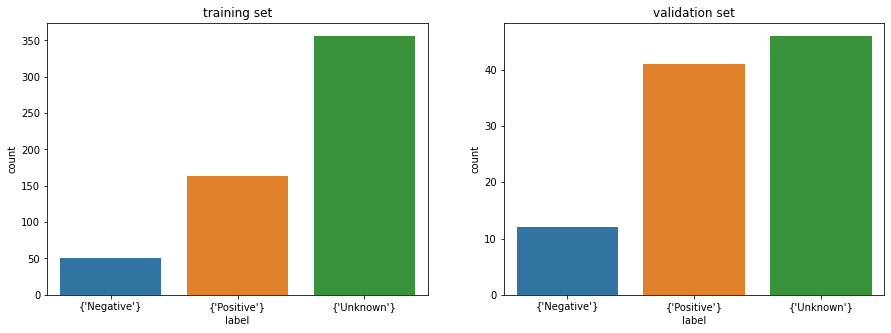

In [49]:
task_name = 'er'
pprint.pprint('TRAINING SET')
df = pd.read_csv(os.path.join(data_dir, 'train_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
df = df.rename(columns={'label_' + task_name: 'label'})
print('Columns: ', df.columns)
print('Size: ', len(df))
print('Labels: ', df['label'].sort_values().unique())

print('------------------------------------------------------------')

pprint.pprint('VALIDATION SET')
dev_set = pd.read_csv(os.path.join(data_dir, 'dev_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
dev_set = dev_set.rename(columns={'label_' + task_name: 'label'})

print('Columns: ', dev_set.columns)
print('Size: ', len(dev_set))
print('Labels: ', dev_set['label'].sort_values().unique())


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.countplot(data = df.sort_values('label'), x='label', ax=axes[0])
axes[0].set_title('training set')
sns.countplot(data = dev_set.sort_values('label'), x='label', ax=axes[1])
axes[1].set_title('validation set')
plt.show()

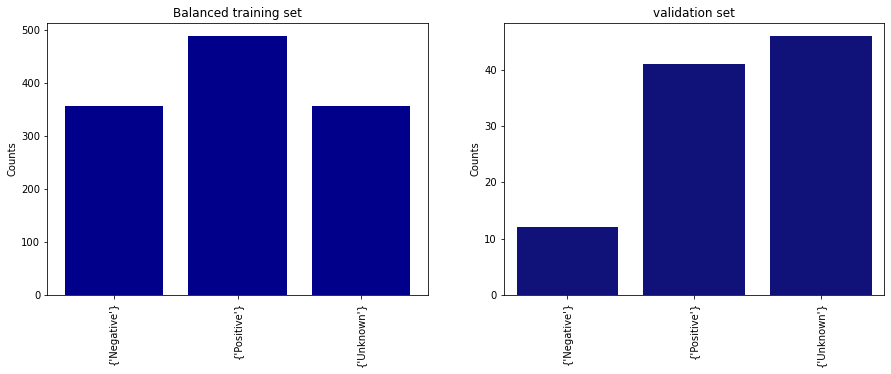

In [50]:
balanced_df = balanced(ohe_df(df, 'full_text')[0])

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.bar(balanced_df.iloc[:,1:].sum().index, balanced_df.iloc[:,1:].sum(), color='darkblue')
plt.xticks(rotation='vertical')
plt.ylabel('Counts')
plt.title('Balanced training set')

plt.subplot(1,2,2)
sns.countplot(data = dev_set.sort_values('label'), x='label', color='darkblue')
plt.title('validation set')
plt.xticks(rotation='vertical')
plt.xlabel('')
plt.ylabel('Counts')
plt.show()

plt.show()

In [51]:
best_params_, best_ngram, best_features, scores_L, results_ = Random_search(df, dev_set, 'full_text', stop_w='english')
dict_results['ER_SW'] = results_
dict_params['ER_SW'] = scores_L

features: 192, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.2s finished


training f1-score: 0.9928658251519401, training accuracy: 0.9964912280701754
validation f1-score: 0.5867300158372926, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 770, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.9913739854916326, training accuracy: 0.9947368421052631
validation f1-score: 0.5769711635410365, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 1348, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.9418271240292452, training accuracy: 0.9631578947368421
validation f1-score: 0.5838178294573643, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 1926, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.8447084155273531, training accuracy: 0.9315789473684211
validation f1-score: 0.5901584091675093, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 2504, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.9923996265172735, training accuracy: 0.9964912280701754
validation f1-score: 0.590466765627577, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 3082, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9834158612320184, training accuracy: 0.9912280701754386
validation f1-score: 0.5916515426497279, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------
features: 3660, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9854608510070695, training accuracy: 0.9929824561403509
validation f1-score: 0.5938984746186546, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 4238, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished


training f1-score: 0.7968661751139092, training accuracy: 0.9210526315789473
validation f1-score: 0.5838178294573643, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 4816, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished


training f1-score: 0.9761753466818827, training accuracy: 0.9859649122807017
validation f1-score: 0.5871073031415749, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 412, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.9769199744355023, training accuracy: 0.980701754385965
validation f1-score: 0.6414404604495605, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 1030, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.9962321617856036, training accuracy: 0.9982456140350877
validation f1-score: 0.6446324349137648, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 1717, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.9635857069915561, training accuracy: 0.9754385964912281
validation f1-score: 0.6483725003649102, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------
features: 2061, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9608255886982432, training accuracy: 0.9754385964912281
validation f1-score: 0.5970904490828589, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 8246, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.6s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.5s finished


training f1-score: 0.9962321617856036, training accuracy: 0.9982456140350877
validation f1-score: 0.590466765627577, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 14431, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    2.1s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    3.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.8s finished


training f1-score: 0.9894314817175968, training accuracy: 0.9947368421052631
validation f1-score: 0.5984427141268076, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------
features: 20616, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.6s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.8s finished


training f1-score: 0.9928658251519401, training accuracy: 0.9964912280701754
validation f1-score: 0.59501100513573, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------
features: 26801, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.2s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    7.0s finished


training f1-score: 0.9889652830829302, training accuracy: 0.9947368421052631
validation f1-score: 0.5858156028368794, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 32986, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.4s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    7.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.0s finished


training f1-score: 0.9889652830829302, training accuracy: 0.9947368421052631
validation f1-score: 0.592243566509605, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------
features: 39171, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.0s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.2s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.5s finished


training f1-score: 0.9745048896751684, training accuracy: 0.987719298245614
validation f1-score: 0.590466765627577, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 45356, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    7.1s remaining:   11.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.6s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   11.0s finished


training f1-score: 0.9711636974923655, training accuracy: 0.9859649122807017
validation f1-score: 0.5938984746186546, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 1119, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.9685222497056003, training accuracy: 0.9789473684210527
validation f1-score: 0.6516404742211194, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------
features: 2797, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.9450682100836899, training accuracy: 0.9666666666666667
validation f1-score: 0.7323176604500482, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------
features: 4662, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.3s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.0s finished


training f1-score: 0.9962321617856036, training accuracy: 0.9982456140350877
validation f1-score: 0.6888968353298767, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------
features: 5595, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.3s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.3s finished


training f1-score: 0.9674775173227186, training accuracy: 0.9771929824561404
validation f1-score: 0.6923285443209543, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------
features: 22383, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.6s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.5s finished


training f1-score: 0.9928658251519401, training accuracy: 0.9964912280701754
validation f1-score: 0.5873481698866878, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 39171, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.3s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.6s finished


training f1-score: 0.9928658251519401, training accuracy: 0.9964912280701754
validation f1-score: 0.5994519664732431, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------
features: 55959, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.3s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   11.3s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.6s finished


training f1-score: 0.9928658251519401, training accuracy: 0.9964912280701754
validation f1-score: 0.5843004513217279, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 72747, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   11.4s remaining:   18.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   15.0s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   19.4s finished


training f1-score: 0.9823503612344145, training accuracy: 0.9912280701754386
validation f1-score: 0.5966547192353644, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------
features: 89535, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   14.6s remaining:   24.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   22.5s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   25.6s finished


training f1-score: 0.988962660310975, training accuracy: 0.9929824561403509
validation f1-score: 0.5938984746186546, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 106323, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   21.4s remaining:   35.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   26.9s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   31.5s finished


training f1-score: 0.9777641421224872, training accuracy: 0.987719298245614
validation f1-score: 0.5888118575185274, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------
features: 123111, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   26.1s remaining:   43.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   33.5s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   36.2s finished


training f1-score: 0.9749710883098349, training accuracy: 0.987719298245614
validation f1-score: 0.5953079178885631, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------
Best Score:  0.7323176604500482
Best ngram: 3
Best feature: 2797
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_leaf_nodes': 28, 'max_depth': 8}


In [52]:
max_score_6, best_report_6 = Train_test(df=df,
                                        dev_set=dev_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w='english',
                                        enable_balance=True)

best accuracy score: 0.85
best f1 score:  0.78
best n_grams / number of features:  [3, 2797]
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.42      0.53        12
           1       0.84      0.88      0.86        41
           2       0.98      0.93      0.96        46

   micro avg       0.89      0.85      0.87        99
   macro avg       0.84      0.74      0.78        99
weighted avg       0.89      0.85      0.86        99
 samples avg       0.85      0.85      0.85        99

["{'Negative'}", "{'Positive'}", "{'Unknown'}"]


In [53]:
best_params_, best_ngram, best_features, scores_L, results_ = Random_search(df, dev_set, 'full_text', stop_w=None)
dict_results['ER_'] = results_
dict_params['ER_'] = scores_L

features: 201, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.9700050803520641, training accuracy: 0.9789473684210527
validation f1-score: 0.5833745670460168, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 805, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.956302369906858, training accuracy: 0.9736842105263158
validation f1-score: 0.5824561403508772, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 1409, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.9408679709803306, training accuracy: 0.9666666666666667
validation f1-score: 0.59501100513573, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------
features: 2013, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.9320766911829446, training accuracy: 0.9614035087719298
validation f1-score: 0.5824561403508772, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 2617, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.6798333114812731, training accuracy: 0.8947368421052632
validation f1-score: 0.5871073031415749, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 3221, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.9889652830829302, training accuracy: 0.9947368421052631
validation f1-score: 0.5800897592819257, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 3825, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9889652830829302, training accuracy: 0.9947368421052631
validation f1-score: 0.5871073031415749, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 4429, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.9793742782421551, training accuracy: 0.9894736842105263
validation f1-score: 0.5871073031415749, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 438, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.9512739434478564, training accuracy: 0.9701754385964912
validation f1-score: 0.5856307435254804, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 1096, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.9962321617856036, training accuracy: 0.9982456140350877
validation f1-score: 0.7332983652417169, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------
features: 1827, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9962321617856036, training accuracy: 0.9982456140350877
validation f1-score: 0.7367267585719336, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------
features: 2193, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9962321617856036, training accuracy: 0.9982456140350877
validation f1-score: 0.7370351150320014, validation accuracy: 0.8383838383838383
----------------------------------------------------------------------------------------------------
features: 8774, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.7s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.9s finished


training f1-score: 0.9608255886982432, training accuracy: 0.9754385964912281
validation f1-score: 0.5899219903014968, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 15355, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    2.3s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    3.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.8s finished


training f1-score: 0.9962321617856036, training accuracy: 0.9982456140350877
validation f1-score: 0.5871073031415749, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 21936, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.8s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.0s finished


training f1-score: 0.9928658251519401, training accuracy: 0.9964912280701754
validation f1-score: 0.59501100513573, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------
features: 28517, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.5s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    7.0s finished


training f1-score: 0.9928658251519401, training accuracy: 0.9964912280701754
validation f1-score: 0.590466765627577, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 35098, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.5s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    7.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.4s finished


training f1-score: 0.9923996265172735, training accuracy: 0.9964912280701754
validation f1-score: 0.5871073031415749, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 41679, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.4s remaining:   10.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.0s finished


training f1-score: 0.9889652830829302, training accuracy: 0.9947368421052631
validation f1-score: 0.589247311827957, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 48260, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    7.4s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.6s finished


training f1-score: 0.9923996265172735, training accuracy: 0.9964912280701754
validation f1-score: 0.5858156028368794, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 54841, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.0s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   11.3s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   13.1s finished


training f1-score: 0.9923996265172735, training accuracy: 0.9964912280701754
validation f1-score: 0.5793553651570787, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 1268, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.7962010125826007, validation accuracy: 0.8484848484848485
----------------------------------------------------------------------------------------------------
features: 3171, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.1s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.8286099865047234, validation accuracy: 0.8585858585858586
----------------------------------------------------------------------------------------------------
features: 5285, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.3s finished


training f1-score: 0.970656286253528, training accuracy: 0.9789473684210527
validation f1-score: 0.7656509937833814, validation accuracy: 0.8383838383838383
----------------------------------------------------------------------------------------------------
features: 6343, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.5s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.4s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.7691489361702128, validation accuracy: 0.8383838383838383
----------------------------------------------------------------------------------------------------
features: 25372, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.1s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.8s finished


training f1-score: 0.9592315550707323, training accuracy: 0.9736842105263158
validation f1-score: 0.6967418546365914, validation accuracy: 0.8383838383838383
----------------------------------------------------------------------------------------------------
features: 44401, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.8s remaining:   11.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.1s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   11.0s finished


training f1-score: 0.9435391547923517, training accuracy: 0.9631578947368421
validation f1-score: 0.5870098039215687, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 63430, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    9.0s remaining:   14.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   13.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   16.4s finished


training f1-score: 0.9928658251519401, training accuracy: 0.9964912280701754
validation f1-score: 0.5839887074006856, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 82459, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   13.0s remaining:   21.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   19.1s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   23.7s finished


training f1-score: 0.899623787136687, training accuracy: 0.9456140350877194
validation f1-score: 0.5873481698866878, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 101488, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   15.8s remaining:   26.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   22.4s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   26.9s finished


training f1-score: 0.9894314817175968, training accuracy: 0.9947368421052631
validation f1-score: 0.5839887074006856, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 120517, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   25.3s remaining:   41.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   31.1s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   38.3s finished


training f1-score: 0.9923996265172735, training accuracy: 0.9964912280701754
validation f1-score: 0.5997342032137248, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------
features: 139546, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   28.1s remaining:   46.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   37.6s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   41.2s finished


training f1-score: 0.8981000749116691, training accuracy: 0.9438596491228071
validation f1-score: 0.589247311827957, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
Best Score:  0.8286099865047234
Best ngram: 3
Best feature: 3171
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': 40, 'max_depth': 25}


In [54]:
max_score_6b, best_report_6b = Train_test(df=df,
                                        dev_set=dev_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w=None,
                                        enable_balance=True)

best accuracy score: 0.82
best f1 score:  0.78
best n_grams / number of features:  [3, 3171]
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.50      0.57        12
           1       0.86      0.76      0.81        41
           2       0.96      0.96      0.96        46

   micro avg       0.89      0.82      0.85        99
   macro avg       0.83      0.74      0.78        99
weighted avg       0.88      0.82      0.85        99
 samples avg       0.82      0.82      0.82        99

["{'Negative'}", "{'Positive'}", "{'Unknown'}"]


In [55]:
pprint.pprint('TEST SET')
test_set = pd.read_csv(os.path.join(data_dir, 'test_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
test_set = test_set.rename(columns={'label_' + task_name: 'label'})
print('Columns: ', test_set.columns)
print('Size: ', len(test_set))
print('Labels: ', test_set['label'].sort_values().unique())

test_score_6, test_report_6 = Train_test(df=df,
                                        dev_set=test_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w=None,
                                        enable_balance=True)

'TEST SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  100
Labels:  ["{'Negative'}" "{'Positive'}" "{'Unknown'}"]
best accuracy score: 0.79
best f1 score:  0.76
best n_grams / number of features:  [3, 3171]
------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.90      0.56      0.69        34
           2       0.92      0.95      0.93        60

   micro avg       0.92      0.79      0.85       100
   macro avg       0.94      0.67      0.76       100
weighted avg       0.92      0.79      0.84       100
 samples avg       0.79      0.79      0.79       100

["{'Negative'}", "{'Positive'}", "{'Unknown'}"]


## LVI

'TRAINING SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  570
Labels:  ["{'Absent'}" "{'Present'}" "{'Unknown'}"]
------------------------------------------------------------
'VALIDATION SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  99
Labels:  ["{'Absent'}" "{'Present'}" "{'Unknown'}"]


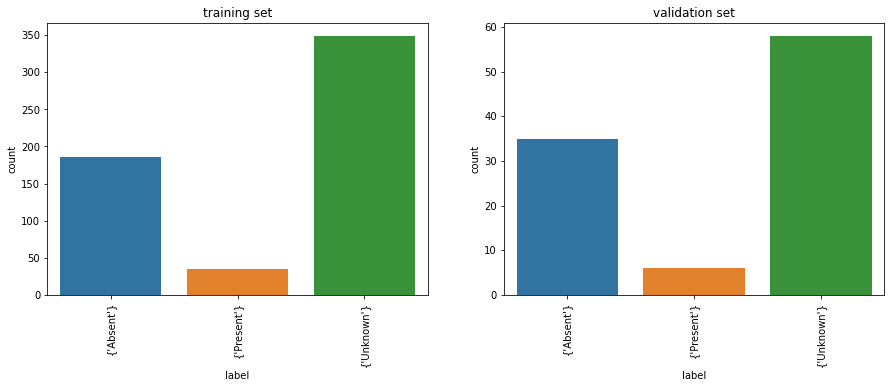

In [56]:
task_name = 'lvi'
pprint.pprint('TRAINING SET')
df = pd.read_csv(os.path.join(data_dir, 'train_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
df = df.rename(columns={'label_' + task_name: 'label'})
print('Columns: ', df.columns)
print('Size: ', len(df))
print('Labels: ', df['label'].sort_values().unique())

print('------------------------------------------------------------')

pprint.pprint('VALIDATION SET')
dev_set = pd.read_csv(os.path.join(data_dir, 'dev_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
dev_set = dev_set.rename(columns={'label_' + task_name: 'label'})

print('Columns: ', dev_set.columns)
print('Size: ', len(dev_set))
print('Labels: ', dev_set['label'].sort_values().unique())


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.countplot(data = df.sort_values('label'), x='label', ax=axes[0])
axes[0].set_title('training set')
axes[0].set_xticklabels(df['label'].sort_values().unique(), rotation='90')
sns.countplot(data = dev_set.sort_values('label'), x='label', ax=axes[1])
axes[1].set_title('validation set')
axes[1].set_xticklabels(dev_set['label'].sort_values().unique(), rotation='90')
plt.xticks(rotation='vertical')
plt.show()

In [57]:
# Duplicate cell?

# pprint.pprint('TRAINING SET')
# df = pd.read_csv(os.path.join(data_dir, 'train_lvi.csv'))
# print('Columns: ', df.columns)
# print('Size: ', len(df))
# print('Labels: ', df['label'].sort_values().unique())

# print('------------------------------------------------------------')

# pprint.pprint('VALIDATION SET')
# dev_set = pd.read_csv(os.path.join(data_dir, 'dev_lvi.csv'))
# print('Columns: ', dev_set.columns)
# print('Size: ', len(dev_set))
# print('Labels: ', dev_set['label'].sort_values().unique())


# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
# sns.countplot(data = df.sort_values('label'), x='label', ax=axes[0])
# axes[0].set_title('training set')
# axes[0].set_xticklabels(df['label'].sort_values().unique(), rotation='90')
# sns.countplot(data = dev_set.sort_values('label'), x='label', ax=axes[1])
# axes[1].set_title('validation set')
# axes[1].set_xticklabels(dev_set['label'].sort_values().unique(), rotation='90')
# plt.xticks(rotation='vertical')
# plt.show()

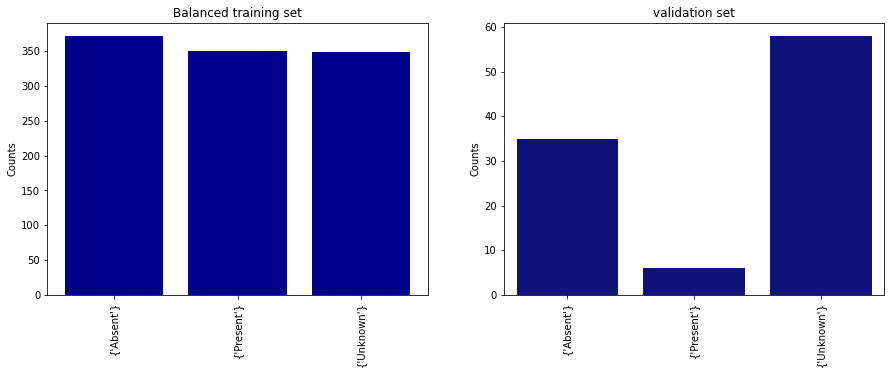

In [58]:
balanced_df = balanced(ohe_df(df, 'full_text')[0])

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.bar(balanced_df.iloc[:,1:].sum().index, balanced_df.iloc[:,1:].sum(), color='darkblue')
plt.xticks(rotation='vertical')
plt.ylabel('Counts')
plt.title('Balanced training set')

plt.subplot(1,2,2)
sns.countplot(data = dev_set.sort_values('label'), x='label', color='darkblue')
plt.title('validation set')
plt.xticks(rotation='vertical')
plt.xlabel('')
plt.ylabel('Counts')
plt.show()

plt.show()

In [59]:
best_params_, best_ngram, best_features, scores_L, results_ = Random_search(df, dev_set, 'full_text', stop_w='english')
dict_results['LVI_SW'] = results_
dict_params['LVI_SW'] = scores_L

features: 192, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.2s finished


training f1-score: 0.6270788912579958, training accuracy: 0.9210526315789473
validation f1-score: 0.6316552250190695, validation accuracy: 0.9191919191919192
----------------------------------------------------------------------------------------------------
features: 770, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.1s finished


training f1-score: 0.6260711908100681, training accuracy: 0.9210526315789473
validation f1-score: 0.6386973180076628, validation accuracy: 0.9292929292929293
----------------------------------------------------------------------------------------------------
features: 1348, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.6280203566693752, training accuracy: 0.9210526315789473
validation f1-score: 0.6346037507562009, validation accuracy: 0.9292929292929293
----------------------------------------------------------------------------------------------------
features: 1926, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.9162446559967122, training accuracy: 0.9701754385964912
validation f1-score: 0.6386973180076628, validation accuracy: 0.9292929292929293
----------------------------------------------------------------------------------------------------
features: 2504, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.6308384310903202, training accuracy: 0.9210526315789473
validation f1-score: 0.6386973180076628, validation accuracy: 0.9292929292929293
----------------------------------------------------------------------------------------------------
features: 3082, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.6327151813336847, training accuracy: 0.9263157894736842
validation f1-score: 0.6386973180076628, validation accuracy: 0.9292929292929293
----------------------------------------------------------------------------------------------------
features: 3660, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.6278096544693662, training accuracy: 0.9192982456140351
validation f1-score: 0.6386973180076628, validation accuracy: 0.9292929292929293
----------------------------------------------------------------------------------------------------
features: 4238, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9937937378075111, training accuracy: 0.9964912280701754
validation f1-score: 0.6346037507562009, validation accuracy: 0.9292929292929293
----------------------------------------------------------------------------------------------------
features: 4816, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.6282535818760276, training accuracy: 0.9210526315789473
validation f1-score: 0.6346037507562009, validation accuracy: 0.9292929292929293
----------------------------------------------------------------------------------------------------
features: 412, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.6266101731002619, training accuracy: 0.9210526315789473
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 1030, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.6316017316017315, training accuracy: 0.9210526315789473
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 1717, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.6254205164652925, training accuracy: 0.9192982456140351
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 2061, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.6308384310903202, training accuracy: 0.9210526315789473
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 8246, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.4s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.5s finished


training f1-score: 0.9334938803167355, training accuracy: 0.9701754385964912
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 14431, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.9s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    3.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.4s finished


training f1-score: 0.6348320038675368, training accuracy: 0.9228070175438596
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 20616, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.3s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    4.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.4s finished


training f1-score: 0.6299558685546506, training accuracy: 0.9228070175438596
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 26801, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.2s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.5s finished


training f1-score: 0.6284624969381996, training accuracy: 0.9228070175438596
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 32986, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.9s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    7.5s finished


training f1-score: 0.6275489505263382, training accuracy: 0.9210526315789473
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 39171, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.8s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    7.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.5s finished


training f1-score: 0.7401252886002593, training accuracy: 0.9350877192982456
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 45356, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.8s remaining:   11.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.0s finished


training f1-score: 0.6927841778982508, training accuracy: 0.9298245614035088
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 1119, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.6251324133839918, training accuracy: 0.9210526315789473
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 2797, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.6533505223860554, training accuracy: 0.9245614035087719
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 4662, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished


training f1-score: 0.627992437669857, training accuracy: 0.9228070175438596
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 5595, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.0s finished


training f1-score: 0.7994583412687267, training accuracy: 0.9421052631578948
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 22383, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.6s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.5s finished


training f1-score: 0.6263245335248293, training accuracy: 0.9192982456140351
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 39171, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.8s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.3s finished


training f1-score: 0.8955036075036076, training accuracy: 0.9614035087719298
validation f1-score: 0.6386973180076628, validation accuracy: 0.9292929292929293
----------------------------------------------------------------------------------------------------
features: 55959, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    7.7s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   11.0s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   13.5s finished


training f1-score: 0.6307081545064378, training accuracy: 0.9228070175438596
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 72747, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   10.0s remaining:   16.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   15.8s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   19.0s finished


training f1-score: 0.6260936695831189, training accuracy: 0.9157894736842105
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 89535, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   13.6s remaining:   22.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   18.7s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   22.8s finished


training f1-score: 0.6268082372194237, training accuracy: 0.9210526315789473
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 106323, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   19.4s remaining:   32.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   25.5s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   30.5s finished


training f1-score: 0.6286299652060262, training accuracy: 0.9245614035087719
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 123111, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   23.9s remaining:   39.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   31.4s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   36.2s finished


training f1-score: 0.8260515873015873, training accuracy: 0.9491228070175438
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
Best Score:  0.6415954415954416
Best ngram: 2
Best feature: 412
Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_leaf_nodes': 24, 'max_depth': None}


In [60]:
max_score_7, best_report_7 = Train_test(df=df,
                                        dev_set=dev_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w='english',
                                        enable_balance=True)

best accuracy score: 0.92
best f1 score:  0.63
best n_grams / number of features:  [2, 412]
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.97      0.92        35
           1       0.00      0.00      0.00         6
           2       0.98      0.98      0.98        58

   micro avg       0.94      0.92      0.93        99
   macro avg       0.62      0.65      0.63        99
weighted avg       0.88      0.92      0.90        99
 samples avg       0.92      0.92      0.92        99

["{'Absent'}", "{'Present'}", "{'Unknown'}"]


In [61]:
pprint.pprint('TEST SET')
test_set = pd.read_csv(os.path.join(data_dir, 'test_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
test_set = test_set.rename(columns={'label_' + task_name: 'label'})
print('Columns: ', test_set.columns)
print('Size: ', len(test_set))
print('Labels: ', test_set['label'].sort_values().unique())

test_score_7, test_report_7 = Train_test(df=df,
                                        dev_set=test_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w='english',
                                        enable_balance=True)

'TEST SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  100
Labels:  ["{'Absent'}" "{'Present'}" "{'Unknown'}"]
best accuracy score: 0.92
best f1 score:  0.7
best n_grams / number of features:  [2, 412]
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        31
           1       1.00      0.11      0.20         9
           2       1.00      1.00      1.00        60

   micro avg       0.93      0.92      0.92       100
   macro avg       0.94      0.70      0.70       100
weighted avg       0.94      0.92      0.90       100
 samples avg       0.92      0.92      0.92       100

["{'Absent'}", "{'Present'}", "{'Unknown'}"]


In [62]:
best_params_, best_ngram, best_features, scores_L, results_ = Random_search(df, dev_set, 'full_text', stop_w=None)
dict_results['LVI_'] = results_
dict_params['LVI_'] = scores_L

features: 201, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.2s finished


training f1-score: 0.6893653744794471, training accuracy: 0.9263157894736842
validation f1-score: 0.6316552250190695, validation accuracy: 0.9191919191919192
----------------------------------------------------------------------------------------------------
features: 805, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.6348564054331897, training accuracy: 0.9210526315789473
validation f1-score: 0.6386973180076628, validation accuracy: 0.9292929292929293
----------------------------------------------------------------------------------------------------
features: 1409, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.6261265103056148, training accuracy: 0.9192982456140351
validation f1-score: 0.6346037507562009, validation accuracy: 0.9292929292929293
----------------------------------------------------------------------------------------------------
features: 2013, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.6266101731002619, training accuracy: 0.9210526315789473
validation f1-score: 0.6386973180076628, validation accuracy: 0.9292929292929293
----------------------------------------------------------------------------------------------------
features: 2617, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.6258544937764099, training accuracy: 0.9192982456140351
validation f1-score: 0.6357487922705314, validation accuracy: 0.9191919191919192
----------------------------------------------------------------------------------------------------
features: 3221, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.6302380952380952, training accuracy: 0.9228070175438596
validation f1-score: 0.6346037507562009, validation accuracy: 0.9292929292929293
----------------------------------------------------------------------------------------------------
features: 3825, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.9986246556819073, training accuracy: 0.9982456140350877
validation f1-score: 0.6346037507562009, validation accuracy: 0.9292929292929293
----------------------------------------------------------------------------------------------------
features: 4429, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.7143290965640535, training accuracy: 0.9385964912280702
validation f1-score: 0.6386973180076628, validation accuracy: 0.9292929292929293
----------------------------------------------------------------------------------------------------
features: 438, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.6287647643069975, training accuracy: 0.9210526315789473
validation f1-score: 0.6346037507562009, validation accuracy: 0.9292929292929293
----------------------------------------------------------------------------------------------------
features: 1096, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.6263381779510812, training accuracy: 0.9210526315789473
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 1827, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.6272512965582272, training accuracy: 0.9228070175438596
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 2193, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.6263381779510812, training accuracy: 0.9210526315789473
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 8774, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.6s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.4s finished


training f1-score: 0.6265952070833244, training accuracy: 0.9192982456140351
validation f1-score: 0.6386973180076628, validation accuracy: 0.9292929292929293
----------------------------------------------------------------------------------------------------
features: 15355, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    2.1s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.4s finished


training f1-score: 0.6258544937764099, training accuracy: 0.9192982456140351
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 21936, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.5s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    4.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.3s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.6386973180076628, validation accuracy: 0.9292929292929293
----------------------------------------------------------------------------------------------------
features: 28517, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.1s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.0s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.8s finished


training f1-score: 0.6322240674042602, training accuracy: 0.9228070175438596
validation f1-score: 0.6386973180076628, validation accuracy: 0.9292929292929293
----------------------------------------------------------------------------------------------------
features: 35098, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.9s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.8s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.2s finished


training f1-score: 0.8606059849388127, training accuracy: 0.9543859649122807
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 41679, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.3s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.5s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.6s finished


training f1-score: 0.6308657001117446, training accuracy: 0.9245614035087719
validation f1-score: 0.6386973180076628, validation accuracy: 0.9292929292929293
----------------------------------------------------------------------------------------------------
features: 48260, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    7.0s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   10.0s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.9s finished


training f1-score: 0.63189111747851, training accuracy: 0.9228070175438596
validation f1-score: 0.6386973180076628, validation accuracy: 0.9292929292929293
----------------------------------------------------------------------------------------------------
features: 54841, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.2s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   10.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.4s finished


training f1-score: 0.6292073253190414, training accuracy: 0.9228070175438596
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 1268, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.6251324133839918, training accuracy: 0.9210526315789473
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 3171, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.6487566137566138, training accuracy: 0.9245614035087719
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 5285, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.3s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.0s finished


training f1-score: 0.6272512965582272, training accuracy: 0.9228070175438596
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 6343, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.3s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.3s finished


training f1-score: 0.7640690591655922, training accuracy: 0.9368421052631579
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 25372, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.3s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.2s finished


training f1-score: 0.6345267199072816, training accuracy: 0.9228070175438596
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 44401, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.1s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.5s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.2s finished


training f1-score: 0.8567816089597415, training accuracy: 0.956140350877193
validation f1-score: 0.6386973180076628, validation accuracy: 0.9292929292929293
----------------------------------------------------------------------------------------------------
features: 63430, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.5s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   12.4s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   15.6s finished


training f1-score: 0.8908502092937, training accuracy: 0.9631578947368421
validation f1-score: 0.6386973180076628, validation accuracy: 0.9292929292929293
----------------------------------------------------------------------------------------------------
features: 82459, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   11.5s remaining:   18.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   16.7s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   20.8s finished


training f1-score: 0.6301167566569754, training accuracy: 0.9245614035087719
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 101488, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   16.6s remaining:   27.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   22.0s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   27.3s finished


training f1-score: 0.7835139729380566, training accuracy: 0.9421052631578948
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 120517, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   23.9s remaining:   39.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   31.1s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   35.9s finished


training f1-score: 0.7549699810839706, training accuracy: 0.9385964912280702
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
features: 139546, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   27.6s remaining:   45.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   37.4s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   39.7s finished


training f1-score: 0.630438190238689, training accuracy: 0.9245614035087719
validation f1-score: 0.6415954415954416, validation accuracy: 0.9393939393939394
----------------------------------------------------------------------------------------------------
Best Score:  0.6415954415954416
Best ngram: 2
Best feature: 1096
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_leaf_nodes': 16, 'max_depth': None}


In [63]:
max_score_7b, best_report_7b = Train_test(df=df,
                                        dev_set=dev_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w= None,
                                        enable_balance=True)

best accuracy score: 0.91
best f1 score:  0.63
best n_grams / number of features:  [2, 1096]
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.94      0.90        35
           1       0.00      0.00      0.00         6
           2       0.98      0.98      0.98        58

   micro avg       0.93      0.91      0.92        99
   macro avg       0.62      0.64      0.63        99
weighted avg       0.88      0.91      0.90        99
 samples avg       0.91      0.91      0.91        99

["{'Absent'}", "{'Present'}", "{'Unknown'}"]


## DCIS_margins

'TRAINING SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  570
Labels:  ["{'Less than 2mm'}" "{'More than/eq to 2mm'}" "{'Positive margin'}"
 "{'Unknown'}"]
------------------------------------------------------------
'VALIDATION SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  99
Labels:  ["{'Less than 2mm'}" "{'More than/eq to 2mm'}" "{'Positive margin'}"
 "{'Unknown'}"]


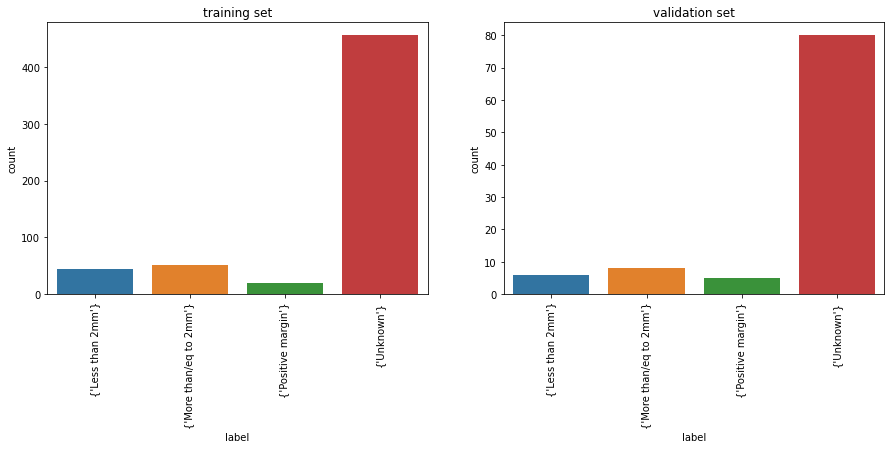

In [64]:
task_name = 'dcis_margins'
pprint.pprint('TRAINING SET')
df = pd.read_csv(os.path.join(data_dir, 'train_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
df = df.rename(columns={'label_' + task_name: 'label'})
df.dropna(inplace=True)

print('Columns: ', df.columns)
print('Size: ', len(df))
print('Labels: ', df['label'].sort_values().unique())

print('------------------------------------------------------------')

pprint.pprint('VALIDATION SET')
dev_set = pd.read_csv(os.path.join(data_dir, 'dev_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
dev_set = dev_set.rename(columns={'label_' + task_name: 'label'})

print('Columns: ', dev_set.columns)
print('Size: ', len(dev_set))
print('Labels: ', dev_set['label'].sort_values().unique())


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.countplot(data = df.sort_values('label'), x='label', ax=axes[0])
axes[0].set_title('training set')
axes[0].set_xticklabels(df['label'].sort_values().unique(), rotation='90')
sns.countplot(data = dev_set.sort_values('label'), x='label', ax=axes[1])
axes[1].set_title('validation set')
axes[1].set_xticklabels(dev_set['label'].sort_values().unique(), rotation='90')
plt.xticks(rotation='vertical')
plt.show()

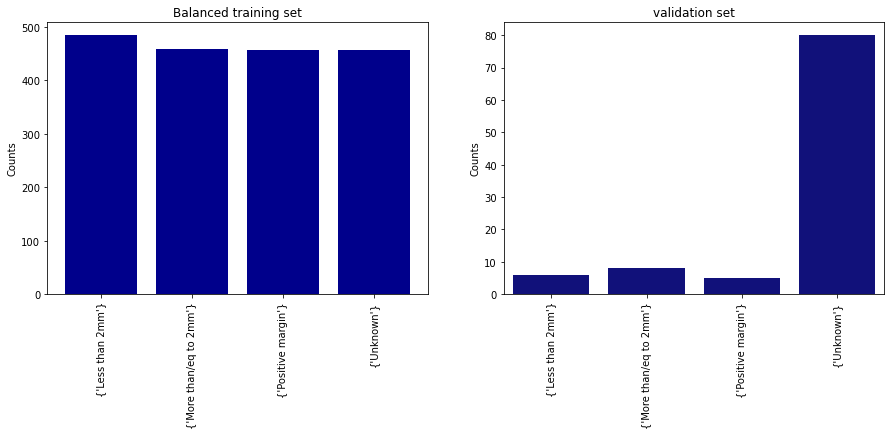

In [65]:
balanced_df = balanced(ohe_df(df, 'full_text')[0])

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.bar(balanced_df.iloc[:,1:].sum().index, balanced_df.iloc[:,1:].sum(), color='darkblue')
plt.xticks(rotation='vertical')
plt.ylabel('Counts')
plt.title('Balanced training set')

plt.subplot(1,2,2)
sns.countplot(data = dev_set.sort_values('label'), x='label', color='darkblue')
plt.title('validation set')
plt.xticks(rotation='vertical')
plt.xlabel('')
plt.ylabel('Counts')
plt.show()

plt.show()

In [66]:
best_params_, best_ngram, best_features, scores_L, results_ = Random_search(df, dev_set, 'full_text', stop_w='english')
dict_results['DCIS_MARGINS_SW'] = results_
dict_params['DCIS_MARGINS_SW'] = scores_L

features: 192, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.1s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.24683544303797467, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 770, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.2s finished


training f1-score: 0.8817418213969938, training accuracy: 0.9771929824561404
validation f1-score: 0.30083857442348005, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 1348, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.825383922239634, training accuracy: 0.9666666666666667
validation f1-score: 0.24683544303797467, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 1926, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.48620852693665684, training accuracy: 0.8491228070175438
validation f1-score: 0.24528301886792453, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 2504, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.8040844662070743, training accuracy: 0.9631578947368421
validation f1-score: 0.24528301886792453, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 3082, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.7328214155322589, training accuracy: 0.956140350877193
validation f1-score: 0.24528301886792453, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 3660, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.24528301886792453, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 4238, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.9861111111111112, training accuracy: 0.9964912280701754
validation f1-score: 0.24528301886792453, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 4816, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.9861111111111112, training accuracy: 0.9964912280701754
validation f1-score: 0.24528301886792453, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 412, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.2s finished


training f1-score: 0.8950001612195487, training accuracy: 0.9771929824561404
validation f1-score: 0.37381957002210164, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 1030, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.8953990780604164, training accuracy: 0.9789473684210527
validation f1-score: 0.30239099859353025, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 1717, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.34683544303797464, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 2061, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.7356282249742002, training accuracy: 0.956140350877193
validation f1-score: 0.31826401446654606, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 8246, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.5s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.5s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.34683544303797464, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 14431, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.9s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.0s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.24683544303797467, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 20616, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.3s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    4.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.2s finished


training f1-score: 0.7353461680075064, training accuracy: 0.9578947368421052
validation f1-score: 0.24528301886792453, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 26801, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.2s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.6s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.4s finished


training f1-score: 0.6638894443555697, training accuracy: 0.9192982456140351
validation f1-score: 0.24528301886792453, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 32986, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.8s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    7.5s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.24683544303797467, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 39171, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.7s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    7.8s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.1s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.24528301886792453, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 45356, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.0s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.0s finished


training f1-score: 0.6327850877192982, training accuracy: 0.9052631578947369
validation f1-score: 0.24528301886792453, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 1119, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.30239099859353025, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 2797, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.8787183282582062, training accuracy: 0.9736842105263158
validation f1-score: 0.40933544303797464, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------
features: 4662, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.30933544303797467, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 5595, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished


training f1-score: 0.7610620433218352, training accuracy: 0.9578947368421052
validation f1-score: 0.31826401446654606, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 22383, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.4s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    4.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.6s finished


training f1-score: 0.7197261774370207, training accuracy: 0.9491228070175438
validation f1-score: 0.24683544303797467, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 39171, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.7s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    7.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.5s finished


training f1-score: 0.7664369764238963, training accuracy: 0.9631578947368421
validation f1-score: 0.24683544303797467, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 55959, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    7.9s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   10.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.6s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.24683544303797467, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 72747, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   11.4s remaining:   18.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   16.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   20.4s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.24683544303797467, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 89535, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   13.6s remaining:   22.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   18.2s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   22.4s finished


training f1-score: 0.7171504198612633, training accuracy: 0.9473684210526315
validation f1-score: 0.24683544303797467, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 106323, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   19.0s remaining:   31.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   27.2s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   29.6s finished


training f1-score: 0.7145220958043678, training accuracy: 0.9456140350877194
validation f1-score: 0.24842767295597484, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 123111, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   24.4s remaining:   40.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   32.2s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   35.8s finished


training f1-score: 0.26983073348821773, training accuracy: 0.8017543859649123
validation f1-score: 0.2453416149068323, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
Best Score:  0.40933544303797464
Best ngram: 3
Best feature: 2797
Best Hyperparameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_leaf_nodes': 32, 'max_depth': 15}


In [67]:
max_score_8, best_report_8 = Train_test(df=df,
                                        dev_set=dev_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w='english',
                                        enable_balance=True)

best accuracy score: 0.83
best f1 score:  0.49
best n_grams / number of features:  [3, 2797]
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         6
           1       0.67      0.50      0.57         8
           2       0.00      0.00      0.00         5
           3       1.00      0.95      0.97        80

   micro avg       0.95      0.83      0.89        99
   macro avg       0.54      0.45      0.49        99
weighted avg       0.89      0.83      0.86        99
 samples avg       0.83      0.83      0.83        99

["{'Less than 2mm'}", "{'More than/eq to 2mm'}", "{'Positive margin'}", "{'Unknown'}"]


In [68]:
pprint.pprint('TEST SET')
test_set = pd.read_csv(os.path.join(data_dir, 'test_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
test_set = test_set.rename(columns={'label_' + task_name: 'label'})
print('Columns: ', test_set.columns)
print('Size: ', len(test_set))
print('Labels: ', test_set['label'].sort_values().unique())

test_score_8, test_report_8 = Train_test(df=df,
                                        dev_set=test_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w='english',
                                        enable_balance=True)

'TEST SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  100
Labels:  ["{'Less than 2mm'}" "{'More than/eq to 2mm'}" "{'Positive margin'}"
 "{'Unknown'}"]
best accuracy score: 0.7
best f1 score:  0.3
best n_grams / number of features:  [3, 2797]
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.50      0.18      0.27        11
           2       0.00      0.00      0.00         4
           3       0.99      0.86      0.92        79

   micro avg       0.92      0.70      0.80       100
   macro avg       0.37      0.26      0.30       100
weighted avg       0.83      0.70      0.76       100
 samples avg       0.70      0.70      0.70       100

["{'Less than 2mm'}", "{'More than/eq to 2mm'}", "{'Positive margin'}", "{'Unknown'}"]


In [69]:
best_params_, best_ngram, best_features, scores_L, results_ = Random_search(df, dev_set, 'full_text', stop_w=None)
dict_results['DCIS_MARGINS_'] = results_
dict_params['DCIS_MARGINS_'] = scores_L

features: 201, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.2s finished


training f1-score: 0.8614363752766668, training accuracy: 0.9701754385964912
validation f1-score: 0.29842767295597483, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 805, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.8488178559235233, training accuracy: 0.9719298245614035
validation f1-score: 0.30239099859353025, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 1409, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.4691285613644183, training accuracy: 0.8456140350877193
validation f1-score: 0.24683544303797467, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 2013, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.8261425682507584, training accuracy: 0.9666666666666667
validation f1-score: 0.31826401446654606, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 2617, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.4090841926884209, training accuracy: 0.8298245614035088
validation f1-score: 0.24528301886792453, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 3221, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.24528301886792453, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 3825, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.24528301886792453, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 4429, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.6700892857142857, training accuracy: 0.9245614035087719
validation f1-score: 0.24528301886792453, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 438, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.8978737244379396, training accuracy: 0.9789473684210527
validation f1-score: 0.30239099859353025, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 1096, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.30239099859353025, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 1827, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.9076907925754981, training accuracy: 0.9789473684210527
validation f1-score: 0.24683544303797467, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 2193, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.35794655414908577, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 8774, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.4s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.4s finished


training f1-score: 0.8643773666938774, training accuracy: 0.9736842105263158
validation f1-score: 0.24683544303797467, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 15355, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    2.0s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.0s finished


training f1-score: 0.4917630509534229, training accuracy: 0.8526315789473684
validation f1-score: 0.24528301886792453, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 21936, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.6s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    4.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.4s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.30239099859353025, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 28517, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.2s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.7s finished


training f1-score: 0.4504684080962801, training accuracy: 0.8403508771929824
validation f1-score: 0.24528301886792453, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 35098, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.2s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    7.1s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    7.8s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.24683544303797467, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 41679, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.1s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.0s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.7s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.24683544303797467, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 48260, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.9s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.3s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.3s finished


training f1-score: 0.37873138473981965, training accuracy: 0.8210526315789474
validation f1-score: 0.24528301886792453, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 54841, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    7.3s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   10.5s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   11.8s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.24683544303797467, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 1268, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.9330589096231248, training accuracy: 0.9842105263157894
validation f1-score: 0.34683544303797464, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 3171, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9104404631513066, training accuracy: 0.9824561403508771
validation f1-score: 0.383199079401611, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------
features: 5285, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.0s finished


training f1-score: 0.8953990780604164, training accuracy: 0.9789473684210527
validation f1-score: 0.34683544303797464, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 6343, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.3s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.1s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.29683544303797466, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 25372, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.1s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.9s finished


training f1-score: 0.7268157558463519, training accuracy: 0.9508771929824561
validation f1-score: 0.24683544303797467, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 44401, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    7.2s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.3s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.5s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.24683544303797467, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 63430, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.6s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   11.5s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   13.2s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.24683544303797467, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 82459, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   12.4s remaining:   20.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   17.0s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   20.4s finished


training f1-score: 0.7795353135164046, training accuracy: 0.9578947368421052
validation f1-score: 0.24683544303797467, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 101488, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   16.2s remaining:   26.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   21.9s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   26.8s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.24683544303797467, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 120517, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   23.5s remaining:   38.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   31.3s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   33.9s finished


training f1-score: 0.7231212391654158, training accuracy: 0.9508771929824561
validation f1-score: 0.24683544303797467, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 139546, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   26.4s remaining:   43.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   36.8s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   39.0s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.24683544303797467, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
Best Score:  0.383199079401611
Best ngram: 3
Best feature: 3171
Best Hyperparameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_leaf_nodes': 32, 'max_depth': 15}


In [70]:
max_score_8b, best_report_8b = Train_test(df=df,
                                        dev_set=dev_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w=None,
                                        enable_balance=True)

best accuracy score: 0.83
best f1 score:  0.5
best n_grams / number of features:  [3, 3171]
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.33      0.44         6
           1       0.67      0.50      0.57         8
           2       0.00      0.00      0.00         5
           3       1.00      0.95      0.97        80

   micro avg       0.96      0.83      0.89        99
   macro avg       0.58      0.45      0.50        99
weighted avg       0.90      0.83      0.86        99
 samples avg       0.83      0.83      0.83        99

["{'Less than 2mm'}", "{'More than/eq to 2mm'}", "{'Positive margin'}", "{'Unknown'}"]


## Margins

'TRAINING SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  570
Labels:  ["{'Less than 2mm'}" "{'More than/eq to 2mm'}" "{'Positive margin'}"
 "{'Unknown'}"]
------------------------------------------------------------
'VALIDATION SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  99
Labels:  ["{'Less than 2mm'}" "{'More than/eq to 2mm'}" "{'Positive margin'}"
 "{'Unknown'}"]


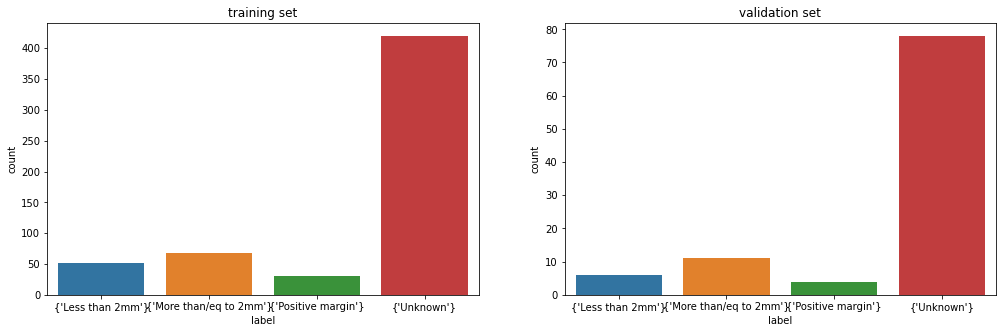

In [71]:
task_name = 'margins'
pprint.pprint('TRAINING SET')
df = pd.read_csv(os.path.join(data_dir, 'train_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
df = df.rename(columns={'label_' + task_name: 'label'})

df.dropna(inplace=True)
print('Columns: ', df.columns)
print('Size: ', len(df))
print('Labels: ', df['label'].sort_values().unique())

print('------------------------------------------------------------')

pprint.pprint('VALIDATION SET')
dev_set = pd.read_csv(os.path.join(data_dir, 'dev_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
dev_set = dev_set.rename(columns={'label_' + task_name: 'label'})
print('Columns: ', dev_set.columns)
print('Size: ', len(dev_set))
print('Labels: ', dev_set['label'].sort_values().unique())


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,5))
sns.countplot(data = df.sort_values('label'), x='label', ax=axes[0])
axes[0].set_title('training set')
sns.countplot(data = dev_set.sort_values('label'), x='label', ax=axes[1])
axes[1].set_title('validation set')
plt.show()

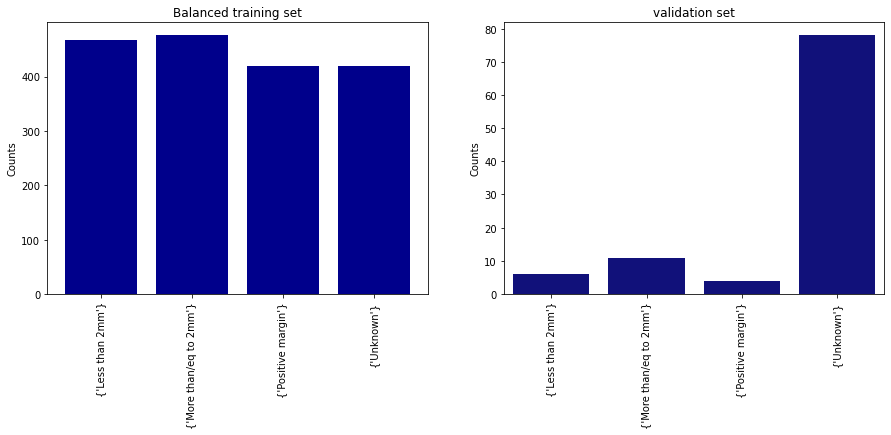

In [72]:
balanced_df = balanced(ohe_df(df, 'full_text')[0])

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.bar(balanced_df.iloc[:,1:].sum().index, balanced_df.iloc[:,1:].sum(), color='darkblue')
plt.xticks(rotation='vertical')
plt.ylabel('Counts')
plt.title('Balanced training set')

plt.subplot(1,2,2)
sns.countplot(data = dev_set.sort_values('label'), x='label', color='darkblue')
plt.title('validation set')
plt.xticks(rotation='vertical')
plt.xlabel('')
plt.ylabel('Counts')
plt.show()

plt.show()

In [73]:
best_params_, best_ngram, best_features, scores_L, results_ = Random_search(df, dev_set, 'full_text', stop_w='english')
dict_results['MARGINS_SW'] = results_
dict_params['MARGINS_SW'] = scores_L

features: 192, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.1s finished


training f1-score: 0.5276666248992133, training accuracy: 0.8192982456140351
validation f1-score: 0.3150537634408602, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 770, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.985220782595226, training accuracy: 0.9912280701754386
validation f1-score: 0.31981566820276497, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 1348, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.2s finished


training f1-score: 0.9908607510800931, training accuracy: 0.9947368421052631
validation f1-score: 0.3421370967741935, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 1926, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.7198854992468038, training accuracy: 0.9175438596491228
validation f1-score: 0.34838709677419355, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 2504, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.7538153590695208, training accuracy: 0.9228070175438596
validation f1-score: 0.286848635235732, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 3082, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.8570364145419281, training accuracy: 0.9473684210526315
validation f1-score: 0.31981566820276497, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 3660, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.9775665556644627, training accuracy: 0.9894736842105263
validation f1-score: 0.31981566820276497, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 4238, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9776149769672335, training accuracy: 0.987719298245614
validation f1-score: 0.37338709677419357, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------
features: 4816, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9747952202786629, training accuracy: 0.987719298245614
validation f1-score: 0.34838709677419355, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 412, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.2s finished


training f1-score: 0.5341796913253815, training accuracy: 0.8333333333333334
validation f1-score: 0.31981566820276497, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 1030, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.9828134968190526, training accuracy: 0.9912280701754386
validation f1-score: 0.3421370967741935, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 1717, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.9957627118644068, training accuracy: 0.9982456140350877
validation f1-score: 0.34838709677419355, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 2061, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.9444191295766147, training accuracy: 0.9666666666666667
validation f1-score: 0.3421370967741935, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 8246, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.5s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.4s finished


training f1-score: 0.9242471018198353, training accuracy: 0.9631578947368421
validation f1-score: 0.34838709677419355, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 14431, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    2.0s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.2s finished


training f1-score: 0.9981481481481481, training accuracy: 0.9982456140350877
validation f1-score: 0.34838709677419355, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 20616, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.2s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    4.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.2s finished


training f1-score: 0.9939108600125549, training accuracy: 0.9964912280701754
validation f1-score: 0.28410138248847927, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 26801, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.2s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.3s finished


training f1-score: 0.9892294847146682, training accuracy: 0.9929824561403509
validation f1-score: 0.35552995391705067, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 32986, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.5s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    7.1s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.1s finished


training f1-score: 0.975091070728384, training accuracy: 0.9859649122807017
validation f1-score: 0.34838709677419355, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 39171, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.7s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    7.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.9s finished


training f1-score: 0.9825630689452867, training accuracy: 0.9912280701754386
validation f1-score: 0.37338709677419357, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------
features: 45356, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    7.1s remaining:   11.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.5s finished


training f1-score: 0.9819401444788443, training accuracy: 0.9912280701754386
validation f1-score: 0.286848635235732, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 1119, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.9819692447172581, training accuracy: 0.9912280701754386
validation f1-score: 0.34838709677419355, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 2797, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9889521258788082, training accuracy: 0.9947368421052631
validation f1-score: 0.3150537634408602, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 4662, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.0s finished


training f1-score: 0.6427230290985069, training accuracy: 0.868421052631579
validation f1-score: 0.3954459203036053, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------
features: 5595, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.1s finished


training f1-score: 0.9981481481481481, training accuracy: 0.9982456140350877
validation f1-score: 0.34838709677419355, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 22383, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.6s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.6s finished


training f1-score: 0.9981481481481481, training accuracy: 0.9982456140350877
validation f1-score: 0.3872759856630824, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------
features: 39171, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.6s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    7.9s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.7s finished


training f1-score: 0.9981481481481481, training accuracy: 0.9982456140350877
validation f1-score: 0.3421370967741935, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 55959, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.0s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   10.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.1s finished


training f1-score: 0.9981481481481481, training accuracy: 0.9982456140350877
validation f1-score: 0.34838709677419355, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 72747, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   11.7s remaining:   19.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   15.1s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   19.2s finished


training f1-score: 0.9871002740269563, training accuracy: 0.9929824561403509
validation f1-score: 0.31981566820276497, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 89535, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   14.3s remaining:   23.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   19.5s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   24.0s finished


training f1-score: 0.9799930315126977, training accuracy: 0.9894736842105263
validation f1-score: 0.36603415559772295, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------
features: 106323, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   19.9s remaining:   32.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   27.8s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   30.6s finished


training f1-score: 0.984990253411306, training accuracy: 0.9929824561403509
validation f1-score: 0.3150537634408602, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 123111, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   23.8s remaining:   39.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   32.8s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   35.9s finished


training f1-score: 0.972993690954856, training accuracy: 0.987719298245614
validation f1-score: 0.34838709677419355, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
Best Score:  0.3954459203036053
Best ngram: 3
Best feature: 4662
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_leaf_nodes': 14, 'max_depth': 15}


In [74]:
max_score_12, best_report_12 = Train_test(df=df,
                                        dev_set=dev_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w='english',
                                        enable_balance=True)

best accuracy score: 0.78
best f1 score:  0.29
best n_grams / number of features:  [3, 4662]
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.50      0.09      0.15        11
           2       0.00      0.00      0.00         4
           3       1.00      0.97      0.99        78

   micro avg       0.99      0.78      0.87        99
   macro avg       0.38      0.27      0.29        99
weighted avg       0.84      0.78      0.79        99
 samples avg       0.78      0.78      0.78        99

["{'Less than 2mm'}", "{'More than/eq to 2mm'}", "{'Positive margin'}", "{'Unknown'}"]


In [75]:
best_params_, best_ngram, best_features, scores_L, results_ = Random_search(df, dev_set, 'full_text', stop_w=None)
dict_results['MARGINS_'] = results_
dict_params['MARGINS_'] = scores_L

features: 201, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.2s finished


training f1-score: 0.9895274584929757, training accuracy: 0.9947368421052631
validation f1-score: 0.36440030557677616, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 805, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.9149207925100331, training accuracy: 0.9614035087719298
validation f1-score: 0.34838709677419355, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 1409, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.9871002740269563, training accuracy: 0.9929824561403509
validation f1-score: 0.37338709677419357, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------
features: 2013, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.5404930057535516, training accuracy: 0.8350877192982457
validation f1-score: 0.286848635235732, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 2617, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.9914836755465355, training accuracy: 0.9947368421052631
validation f1-score: 0.34838709677419355, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 3221, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.7662932702152722, training accuracy: 0.9245614035087719
validation f1-score: 0.2900537634408602, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 3825, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.9778638208249859, training accuracy: 0.9894736842105263
validation f1-score: 0.36603415559772295, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------
features: 4429, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.9756870642327323, training accuracy: 0.987719298245614
validation f1-score: 0.37338709677419357, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------
features: 438, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.593442577194995, training accuracy: 0.8543859649122807
validation f1-score: 0.286848635235732, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 1096, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.6265939968404424, training accuracy: 0.8666666666666667
validation f1-score: 0.31981566820276497, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 1827, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.9889521258788082, training accuracy: 0.9947368421052631
validation f1-score: 0.3872759856630824, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------
features: 2193, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.9889521258788082, training accuracy: 0.9947368421052631
validation f1-score: 0.34838709677419355, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 8774, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.4s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.34838709677419355, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 15355, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    2.0s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    3.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.5s finished


training f1-score: 0.7583862815024365, training accuracy: 0.9210526315789473
validation f1-score: 0.31981566820276497, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 21936, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.6s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    4.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.5s finished


training f1-score: 1.0, training accuracy: 1.0
validation f1-score: 0.34838709677419355, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 28517, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.5s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.8s finished


training f1-score: 0.9939108600125549, training accuracy: 0.9964912280701754
validation f1-score: 0.34838709677419355, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 35098, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.1s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.9s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.0s finished


training f1-score: 0.8209802137204273, training accuracy: 0.9385964912280702
validation f1-score: 0.31981566820276497, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 41679, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.2s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.2s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.1s finished


training f1-score: 0.9871002740269563, training accuracy: 0.9929824561403509
validation f1-score: 0.34838709677419355, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 48260, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    7.4s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.9s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.9s finished


training f1-score: 0.9895274584929757, training accuracy: 0.9947368421052631
validation f1-score: 0.37338709677419357, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------
features: 54841, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    7.9s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   11.0s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.3s finished


training f1-score: 0.984990253411306, training accuracy: 0.9929824561403509
validation f1-score: 0.31981566820276497, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 1268, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.939357551300376, training accuracy: 0.9666666666666667
validation f1-score: 0.40463709677419357, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------
features: 3171, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished


training f1-score: 0.9447192191092093, training accuracy: 0.968421052631579
validation f1-score: 0.3150537634408602, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 5285, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.1s finished


training f1-score: 0.8837426547043459, training accuracy: 0.9491228070175438
validation f1-score: 0.31981566820276497, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 6343, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.3s finished


training f1-score: 0.9510508607557178, training accuracy: 0.9719298245614035
validation f1-score: 0.36603415559772295, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------
features: 25372, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.8s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.6s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.4s finished


training f1-score: 0.7940016883077381, training accuracy: 0.9298245614035088
validation f1-score: 0.31981566820276497, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 44401, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.4s remaining:   10.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.7s finished


training f1-score: 0.8823470714627851, training accuracy: 0.9508771929824561
validation f1-score: 0.3954459203036053, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------
features: 63430, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.1s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   13.2s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   16.1s finished


training f1-score: 0.7127325606905716, training accuracy: 0.9070175438596492
validation f1-score: 0.286848635235732, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------
features: 82459, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   12.0s remaining:   19.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   17.2s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   22.0s finished


training f1-score: 0.9895274584929757, training accuracy: 0.9947368421052631
validation f1-score: 0.3421370967741935, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 101488, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   14.3s remaining:   23.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   21.1s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   25.6s finished


training f1-score: 0.9939108600125549, training accuracy: 0.9964912280701754
validation f1-score: 0.34838709677419355, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 120517, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   24.8s remaining:   40.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   33.3s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   35.2s finished


training f1-score: 0.9865441314848504, training accuracy: 0.9929824561403509
validation f1-score: 0.34838709677419355, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 139546, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   27.4s remaining:   45.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   37.5s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   38.5s finished


training f1-score: 0.9895274584929757, training accuracy: 0.9947368421052631
validation f1-score: 0.3150537634408602, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
Best Score:  0.40463709677419357
Best ngram: 3
Best feature: 1268
Best Hyperparameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_leaf_nodes': 32, 'max_depth': 15}


In [76]:
max_score_12b, best_report_12b = Train_test(df=df,
                                        dev_set=dev_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w=None,
                                        enable_balance=True)

best accuracy score: 0.82
best f1 score:  0.37
best n_grams / number of features:  [3, 1268]
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.80      0.36      0.50        11
           2       0.00      0.00      0.00         4
           3       1.00      0.99      0.99        78

   micro avg       0.98      0.82      0.89        99
   macro avg       0.45      0.34      0.37        99
weighted avg       0.88      0.82      0.84        99
 samples avg       0.82      0.82      0.82        99

["{'Less than 2mm'}", "{'More than/eq to 2mm'}", "{'Positive margin'}", "{'Unknown'}"]


In [77]:
pprint.pprint('TEST SET')
test_set = pd.read_csv(os.path.join(data_dir, 'test_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
test_set = test_set.rename(columns={'label_' + task_name: 'label'})
print('Columns: ', test_set.columns)
print('Size: ', len(test_set))
print('Labels: ', test_set['label'].sort_values().unique())

test_score_12, test_report_12 = Train_test(df=df,
                                        dev_set=test_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w=None,
                                        enable_balance=True)

'TEST SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  100
Labels:  ["{'Less than 2mm'}" "{'More than/eq to 2mm'}" "{'Positive margin'}"
 "{'Unknown'}"]
best accuracy score: 0.68
best f1 score:  0.36
best n_grams / number of features:  [3, 1268]
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.33      0.12      0.18         8
           1       0.50      0.24      0.32        17
           2       0.00      0.00      0.00         5
           3       0.98      0.90      0.94        70

   micro avg       0.91      0.68      0.78       100
   macro avg       0.45      0.32      0.36       100
weighted avg       0.80      0.68      0.73       100
 samples avg       0.68      0.68      0.68       100

["{'Less than 2mm'}", "{'More than/eq to 2mm'}", "{'Positive margin'}", "{'Unknown'}"]


## Lymph Node Involvement

'TRAINING SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  570
Labels:  ["{'0 involved'}" "{'1-3 involved'}" "{'10+ involved'}" "{'4-9 involved'}"
 "{'Unknown'}"]
------------------------------------------------------------
'VALIDATION SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  99
Labels:  ["{'0 involved'}" "{'1-3 involved'}" "{'Unknown'}"]


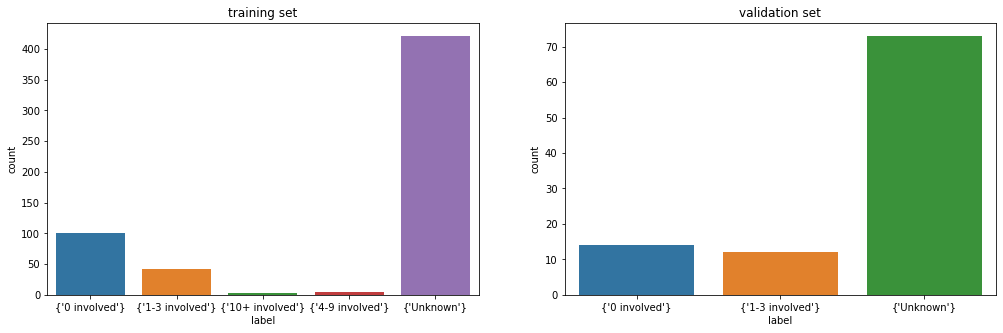

In [78]:
task_name = 'ln_involvement'
pprint.pprint('TRAINING SET')
df = pd.read_csv(os.path.join(data_dir, 'train_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
df = df.rename(columns={'label_' + task_name: 'label'})

df.dropna(inplace=True)
print('Columns: ', df.columns)
print('Size: ', len(df))
print('Labels: ', df['label'].sort_values().unique())

print('------------------------------------------------------------')

pprint.pprint('VALIDATION SET')
dev_set = pd.read_csv(os.path.join(data_dir, 'dev_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
dev_set = dev_set.rename(columns={'label_' + task_name: 'label'})
print('Columns: ', dev_set.columns)
print('Size: ', len(dev_set))
print('Labels: ', dev_set['label'].sort_values().unique())


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,5))
sns.countplot(data = df.sort_values('label'), x='label', ax=axes[0])
axes[0].set_title('training set')
sns.countplot(data = dev_set.sort_values('label'), x='label', ax=axes[1])
axes[1].set_title('validation set')
plt.show()

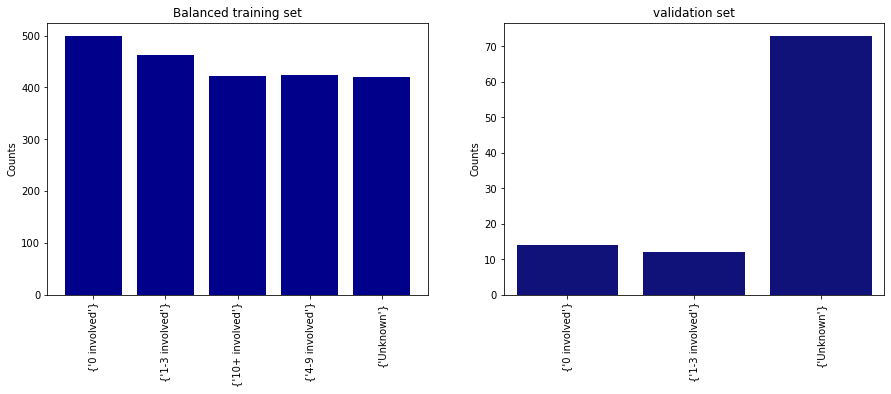

In [79]:
enc_df, enc, all_labels = ohe_df(df, 'full_text')
balanced_df = balanced(enc_df)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.bar(balanced_df.iloc[:,1:].sum().index, balanced_df.iloc[:,1:].sum(), color='darkblue')
plt.xticks(rotation='vertical')
plt.ylabel('Counts')
plt.title('Balanced training set')

plt.subplot(1,2,2)
sns.countplot(data = dev_set.sort_values('label'), x='label', color='darkblue')
plt.title('validation set')
plt.xticks(rotation='vertical')
plt.xlabel('')
plt.ylabel('Counts')
plt.show()

plt.show()

In [80]:
best_params_, best_ngram, best_features, scores_L, results_ = Random_search(df, dev_set, 'full_text', stop_w='english', all_labels=range(len(all_labels)))
dict_results['LN_INVOLVEMENT_SW'] = results_
dict_params['LN_INVOLVEMENT_SW'] = scores_L

features: 192, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.2s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.3679876838111762, training accuracy: 0.875438596491228
validation f1-score: 0.33516113516113516, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------
features: 770, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.5700444835885462, training accuracy: 0.9614035087719298
validation f1-score: 0.3254745254745255, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------
features: 1348, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.558706150953532, training accuracy: 0.9508771929824561
validation f1-score: 0.33516113516113516, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------
features: 1926, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.5561269289822427, training accuracy: 0.9526315789473684
validation f1-score: 0.32987012987012987, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------
features: 2504, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.9197948411977024, training accuracy: 0.9859649122807017
validation f1-score: 0.34997594997594994, validation accuracy: 0.8383838383838383
----------------------------------------------------------------------------------------------------
features: 3082, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.9132736165877862, training accuracy: 0.980701754385965
validation f1-score: 0.3024731182795699, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 3660, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.5218831801726538, training accuracy: 0.9298245614035088
validation f1-score: 0.31241558441558437, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 4238, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.9095006565761283, training accuracy: 0.9771929824561404
validation f1-score: 0.3138064516129032, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 4816, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.8469379105742743, training accuracy: 0.9736842105263158
validation f1-score: 0.30749250749250745, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 412, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.991130639462783, training accuracy: 0.9912280701754386
validation f1-score: 0.3399594320486815, validation accuracy: 0.8383838383838383
----------------------------------------------------------------------------------------------------
features: 1030, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.5828776471563988, training accuracy: 0.9719298245614035
validation f1-score: 0.34415584415584416, validation accuracy: 0.8383838383838383
----------------------------------------------------------------------------------------------------
features: 1717, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.993599049689054, training accuracy: 0.9929824561403509
validation f1-score: 0.3574660633484163, validation accuracy: 0.8383838383838383
----------------------------------------------------------------------------------------------------
features: 2061, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.5679186983925343, training accuracy: 0.956140350877193
validation f1-score: 0.35624375624375626, validation accuracy: 0.8383838383838383
----------------------------------------------------------------------------------------------------
features: 8246, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.7s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.5s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.9200298522644349, training accuracy: 0.9859649122807017
validation f1-score: 0.33126099706744866, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 14431, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.9s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    3.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.4s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.8564013122979688, training accuracy: 0.980701754385965
validation f1-score: 0.337012987012987, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------
features: 20616, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.5s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    4.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.7s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.7537430844498676, training accuracy: 0.9771929824561404
validation f1-score: 0.3228771228771229, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 26801, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.2s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.7s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training f1-score: 0.8185416415086744, training accuracy: 0.9789473684210527
validation f1-score: 0.34580645161290324, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------


/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


features: 32986, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.8s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    7.9s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training f1-score: 0.8785416415086745, training accuracy: 0.980701754385965
validation f1-score: 0.3177489177489178, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------


/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


features: 39171, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.9s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.2s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.1s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training f1-score: 0.6623145130212962, training accuracy: 0.9736842105263158
validation f1-score: 0.3382617382617382, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------


/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


features: 45356, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.7s remaining:   11.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.4s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.0s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training f1-score: 0.6857736771765383, training accuracy: 0.9771929824561404
validation f1-score: 0.3344155844155844, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------


/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


features: 1119, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.5682704829600573, training accuracy: 0.9614035087719298
validation f1-score: 0.3399594320486815, validation accuracy: 0.8383838383838383
----------------------------------------------------------------------------------------------------
features: 2797, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.5771196039770106, training accuracy: 0.968421052631579
validation f1-score: 0.3536796536796537, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------
features: 4662, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.3s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.2s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.47747751583204723, training accuracy: 0.9017543859649123
validation f1-score: 0.35247311827956984, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------
features: 5595, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.3s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.2s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.993599049689054, training accuracy: 0.9929824561403509
validation f1-score: 0.38225108225108223, validation accuracy: 0.8383838383838383
----------------------------------------------------------------------------------------------------
features: 22383, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.7s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.7s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.5568275867667623, training accuracy: 0.9526315789473684
validation f1-score: 0.35247311827956984, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------
features: 39171, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.3s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.2s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.0s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training f1-score: 0.8257250233610458, training accuracy: 0.9859649122807017
validation f1-score: 0.3456209150326798, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------


/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


features: 55959, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.0s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   10.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   13.7s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training f1-score: 0.5444588020674977, training accuracy: 0.9473684210526315
validation f1-score: 0.2987012987012987, validation accuracy: 0.7777777777777778
----------------------------------------------------------------------------------------------------


/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


features: 72747, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   12.6s remaining:   20.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   16.9s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   19.8s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training f1-score: 0.6723916900277126, training accuracy: 0.9824561403508771
validation f1-score: 0.32987012987012987, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------


/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


features: 89535, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   13.7s remaining:   22.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   19.8s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   25.0s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training f1-score: 0.5862442555492146, training accuracy: 0.9754385964912281
validation f1-score: 0.3116883116883117, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------


/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


features: 106323, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   20.4s remaining:   33.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   25.2s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   30.6s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training f1-score: 0.5846115109600991, training accuracy: 0.9754385964912281
validation f1-score: 0.3116883116883117, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------


/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


features: 123111, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   25.0s remaining:   41.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   32.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   35.3s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training f1-score: 0.6623145130212962, training accuracy: 0.9736842105263158
validation f1-score: 0.3235460191981931, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
Best Score:  0.38225108225108223
Best ngram: 3
Best feature: 5595
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': 40, 'max_depth': 25}


/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


In [81]:
max_score_13, best_report_13 = Train_test(df=df,
                                        dev_set=dev_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w='english',
                                        enable_balance=True,
                                        all_labels=range(len(all_labels)))

best accuracy score: 0.82
best f1 score:  0.39
best n_grams / number of features:  [3, 5595]
------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.79      0.88        14
           1       0.50      0.08      0.14        12
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.90      0.95      0.92        73

   micro avg       0.90      0.82      0.86        99
   macro avg       0.48      0.36      0.39        99
weighted avg       0.86      0.82      0.82        99
 samples avg       0.82      0.82      0.82        99

["{'0 involved'}", "{'1-3 involved'}", "{'10+ involved'}", "{'4-9 involved'}", "{'Unknown'}"]


/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


In [82]:
pprint.pprint('TEST SET')
test_set = pd.read_csv(os.path.join(data_dir, 'test_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
test_set = test_set.rename(columns={'label_' + task_name: 'label'})
print('Columns: ', test_set.columns)
print('Size: ', len(test_set))
print('Labels: ', test_set['label'].sort_values().unique())

test_score_13, test_report_13 = Train_test(df=df,
                                        dev_set=test_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w='english',
                                        enable_balance=True,
                                        all_labels=range(len(all_labels)))

'TEST SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  100
Labels:  ["{'0 involved'}" "{'1-3 involved'}" "{'10+ involved'}" "{'4-9 involved'}"
 "{'Unknown'}"]
best accuracy score: 0.79
best f1 score:  0.44
best n_grams / number of features:  [3, 5595]
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.84      0.87        25
           1       0.57      0.29      0.38        14
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.92      0.93      0.92        58

   micro avg       0.89      0.79      0.84       100
   macro avg       0.48      0.41      0.44       100
weighted avg       0.84      0.79      0.81       100
 samples avg       0.79      0.79      0.79       100

["{'0 involved'}", "{'1-3 involved'}", "{'10+ involved'}", "{'4-9 involved'}", "{'Unknown'}"]


In [83]:
best_params_, best_ngram, best_features, scores_L, results_ = Random_search(df, dev_set, 'full_text', stop_w=None, all_labels=range(len(all_labels)))
dict_results['LN_INVOLVEMENT_'] = results_
dict_params['LN_INVOLVEMENT_'] = scores_L

features: 201, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.5771156918052662, training accuracy: 0.9666666666666667
validation f1-score: 0.3525302283922974, validation accuracy: 0.8484848484848485
----------------------------------------------------------------------------------------------------
features: 805, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.4479725531039674, training accuracy: 0.8982456140350877
validation f1-score: 0.33516113516113516, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------
features: 1409, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.991130639462783, training accuracy: 0.9912280701754386
validation f1-score: 0.33516113516113516, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------
features: 2013, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.5646722473257659, training accuracy: 0.9596491228070175
validation f1-score: 0.34415584415584416, validation accuracy: 0.8383838383838383
----------------------------------------------------------------------------------------------------
features: 2617, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.9110166969133535, training accuracy: 0.9789473684210527
validation f1-score: 0.31895424836601305, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 3221, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.9132736165877862, training accuracy: 0.980701754385965
validation f1-score: 0.3339545997610514, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------
features: 3825, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.9189939048905614, training accuracy: 0.9842105263157894
validation f1-score: 0.3284780578898226, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------
features: 4429, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.8551197287560924, training accuracy: 0.9789473684210527
validation f1-score: 0.31362091503267975, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
features: 438, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.5771156918052662, training accuracy: 0.9666666666666667
validation f1-score: 0.33873712494402153, validation accuracy: 0.8383838383838383
----------------------------------------------------------------------------------------------------
features: 1096, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.47258719761897006, training accuracy: 0.9122807017543859
validation f1-score: 0.32987012987012987, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------
features: 1827, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.993599049689054, training accuracy: 0.9929824561403509
validation f1-score: 0.315012987012987, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------
features: 2193, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.993599049689054, training accuracy: 0.9929824561403509
validation f1-score: 0.3408591408591408, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------
features: 8774, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.8s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.7s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.9250276211176255, training accuracy: 0.9894736842105263
validation f1-score: 0.34580645161290324, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------
features: 15355, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    2.2s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    3.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.6s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.5505357444651006, training accuracy: 0.9508771929824561
validation f1-score: 0.3382617382617382, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------
features: 21936, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.5s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.9s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training f1-score: 0.7612909028293644, training accuracy: 0.9842105263157894
validation f1-score: 0.3284780578898226, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------


/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


features: 28517, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.6s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.7s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training f1-score: 0.858462742930828, training accuracy: 0.9842105263157894
validation f1-score: 0.3138064516129032, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------


/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


features: 35098, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.2s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    7.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.2s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training f1-score: 0.8586983102367718, training accuracy: 0.9842105263157894
validation f1-score: 0.3177489177489178, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------


/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


features: 41679, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.1s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.1s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training f1-score: 0.7185416415086745, training accuracy: 0.9771929824561404
validation f1-score: 0.31100653594771244, validation accuracy: 0.7878787878787878
----------------------------------------------------------------------------------------------------


/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


features: 48260, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    7.4s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.9s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.7s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training f1-score: 0.8206030721415336, training accuracy: 0.9824561403508771
validation f1-score: 0.3177489177489178, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------


/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


features: 54841, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    7.7s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   10.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.2s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training f1-score: 0.5835860277011132, training accuracy: 0.9736842105263158
validation f1-score: 0.3075455820476859, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------


/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


features: 1268, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.4850757718746005, training accuracy: 0.9175438596491228
validation f1-score: 0.34415584415584416, validation accuracy: 0.8383838383838383
----------------------------------------------------------------------------------------------------
features: 3171, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.0s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.5653689662463516, training accuracy: 0.9578947368421052
validation f1-score: 0.33516113516113516, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------
features: 5285, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.5s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.4s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.5715392203811895, training accuracy: 0.9666666666666667
validation f1-score: 0.33101298701298704, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------
features: 6343, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.5s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

training f1-score: 0.993599049689054, training accuracy: 0.9929824561403509
validation f1-score: 0.363012987012987, validation accuracy: 0.8383838383838383
----------------------------------------------------------------------------------------------------
features: 25372, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.4s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.6s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training f1-score: 0.9523916900277125, training accuracy: 0.9912280701754386
validation f1-score: 0.3447570332480819, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------


/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


features: 44401, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.6s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.3s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.9s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training f1-score: 0.8257250233610458, training accuracy: 0.9859649122807017
validation f1-score: 0.35485168426344893, validation accuracy: 0.8282828282828283
----------------------------------------------------------------------------------------------------


/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


features: 63430, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.5s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   12.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   15.5s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training f1-score: 0.5566024762066553, training accuracy: 0.9543859649122807
validation f1-score: 0.34093732354601924, validation accuracy: 0.8080808080808081
----------------------------------------------------------------------------------------------------


/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


features: 82459, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   11.7s remaining:   19.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   17.9s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   22.1s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training f1-score: 0.6713662067687267, training accuracy: 0.980701754385965
validation f1-score: 0.33580645161290323, validation accuracy: 0.8181818181818182
----------------------------------------------------------------------------------------------------


/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


features: 101488, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   14.7s remaining:   24.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   21.6s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   26.1s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training f1-score: 0.6672697388082004, training accuracy: 0.9789473684210527
validation f1-score: 0.30749250749250745, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------


/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


features: 120517, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   24.5s remaining:   40.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   31.4s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   34.0s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training f1-score: 0.5888368481418071, training accuracy: 0.9771929824561404
validation f1-score: 0.3177489177489178, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------


/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


features: 139546, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   28.1s remaining:   46.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   36.2s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   41.6s finished
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training f1-score: 0.5835860277011132, training accuracy: 0.9736842105263158
validation f1-score: 0.3235460191981931, validation accuracy: 0.797979797979798
----------------------------------------------------------------------------------------------------
Best Score:  0.363012987012987
Best ngram: 3
Best feature: 6343
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': 40, 'max_depth': 25}


/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


In [84]:
max_score_13b, best_report_13b = Train_test(df=df,
                                        dev_set=dev_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w=None,
                                        enable_balance=True,
                                        all_labels=range(len(all_labels)))

best accuracy score: 0.84
best f1 score:  0.42
best n_grams / number of features:  [3, 6343]
------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.79      0.88        14
           1       1.00      0.17      0.29        12
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.90      0.96      0.93        73

   micro avg       0.91      0.84      0.87        99
   macro avg       0.58      0.38      0.42        99
weighted avg       0.92      0.84      0.84        99
 samples avg       0.84      0.84      0.84        99

["{'0 involved'}", "{'1-3 involved'}", "{'10+ involved'}", "{'4-9 involved'}", "{'Unknown'}"]


/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


## SITES EXAMINED

'TRAINING SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  570
Labels:  ["{ 'Right Breast'}" "{'Left Breast', 'Left LN'}"
 "{'Left Breast', 'Other tissues', 'Left LN'}"
 "{'Left Breast', 'Other tissues', 'Right Breast', 'Left LN'}"
 "{'Left Breast', 'Other tissues', 'Right Breast'}"
 "{'Left Breast', 'Other tissues'}"
 "{'Left Breast', 'Right Breast', 'Left LN', 'Right LN'}"
 "{'Left Breast', 'Right Breast', 'Left LN'}"
 "{'Left Breast', 'Right Breast', 'Right LN'}"
 "{'Left Breast', 'Right Breast'}" "{'Left Breast'}" "{'Left LN'}"
 "{'Other tissues', 'Right Breast', 'Right LN'}"
 "{'Other tissues', 'Right Breast'}" "{'Other tissues'}"
 "{'Right Breast', 'Right LN'}" "{'Right Breast'}" "{'Right LN'}"
 "{'Unknown'}"]
------------------------------------------------------------
'VALIDATION SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  99
Labels:  ["{'Left Breast', 'Right Breast', 'Right LN'}"
 "{'Left Breast', 'Right Breast'}" "{'Lef

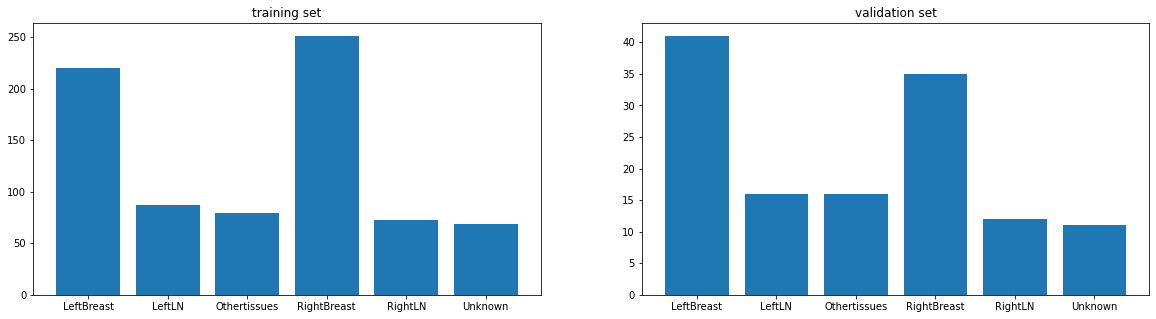

In [85]:
task_name = 'site_examined'
pprint.pprint('TRAINING SET')
df = pd.read_csv(os.path.join(data_dir, 'train_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
df = df.rename(columns={'label_' + task_name: 'label'})

print('Columns: ', df.columns)
print('Size: ', len(df))
print('Labels: ', df['label'].sort_values().unique())

print('------------------------------------------------------------')

pprint.pprint('VALIDATION SET')
dev_set = pd.read_csv(os.path.join(data_dir, 'dev_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
dev_set = dev_set.rename(columns={'label_' + task_name: 'label'})
print('Columns: ', dev_set.columns)
print('Size: ', len(dev_set))
print('Labels: ', dev_set['label'].sort_values().unique())



dfa, enc, labels = ohe_df(df, 'full_text', multi_label=True)
dfa_test = ohe_transform(dev_set, 'full_text', enc, multi_label=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
plt.subplot(1,2,1)
plt.bar(x = dfa.iloc[:, 1:].columns, height=dfa.iloc[:, 1:].sum())
plt.title('training set')

plt.subplot(1,2,2)
plt.bar(x = dfa_test.iloc[:, 1:].columns, height=dfa_test.iloc[:, 1:].sum())
plt.title('validation set')
plt.show()


In [86]:
# balanced_df = balanced(ohe_df(df, 'full_text', multi_label=True)[0])

# plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
# plt.bar(balanced_df.iloc[:,1:].sum().index, balanced_df.iloc[:,1:].sum(), color='darkblue')
# plt.xticks(rotation='vertical')
# plt.ylabel('Counts')
# plt.title('Balanced training set')

# plt.subplot(1,2,2)
# plt.bar(dfa_test.iloc[:,1:].sum().index, dfa_test.iloc[:,1:].sum(), color='darkblue')
# plt.title('validation set')
# plt.xticks(rotation='vertical')
# plt.xlabel('')
# plt.ylabel('Counts')
# plt.show()

# plt.show()

In [87]:
best_params_, best_ngram, best_features, scores_L, results_ = Random_search(df,
                                                                            dev_set,
                                                                            'full_text',
                                                                            stop_w='english', multi_label=True)
dict_results['SITES_EX_SW'] = results_
dict_params['SITES_EX_SW'] = scores_L

features: 192, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


training f1-score: 0.8530927129547305, training accuracy: 0.7964912280701755
validation f1-score: 0.5941412706257035, validation accuracy: 0.5454545454545454
----------------------------------------------------------------------------------------------------
features: 770, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.8299767726946093, training accuracy: 0.7526315789473684
validation f1-score: 0.525246371275783, validation accuracy: 0.5050505050505051
----------------------------------------------------------------------------------------------------
features: 1348, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.8167800893484337, training accuracy: 0.7175438596491228
validation f1-score: 0.48175573697178214, validation accuracy: 0.41414141414141414
----------------------------------------------------------------------------------------------------
features: 1926, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.79494453221026, training accuracy: 0.6736842105263158
validation f1-score: 0.443106254725973, validation accuracy: 0.3838383838383838
----------------------------------------------------------------------------------------------------
features: 2504, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.7833842344013057, training accuracy: 0.6666666666666666
validation f1-score: 0.44414890593918727, validation accuracy: 0.37373737373737376
----------------------------------------------------------------------------------------------------
features: 3082, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.7633720412716986, training accuracy: 0.624561403508772
validation f1-score: 0.41892766636136286, validation accuracy: 0.3434343434343434
----------------------------------------------------------------------------------------------------
features: 3660, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.7511330844581017, training accuracy: 0.6228070175438597
validation f1-score: 0.3967678858983206, validation accuracy: 0.30303030303030304
----------------------------------------------------------------------------------------------------
features: 4238, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.3s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished


training f1-score: 0.7452038371284443, training accuracy: 0.624561403508772
validation f1-score: 0.4269535639398652, validation accuracy: 0.31313131313131315
----------------------------------------------------------------------------------------------------
features: 4816, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished


training f1-score: 0.7153595996327459, training accuracy: 0.5912280701754385
validation f1-score: 0.3597471022128557, validation accuracy: 0.25252525252525254
----------------------------------------------------------------------------------------------------
features: 412, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.8790296757062559, training accuracy: 0.8263157894736842
validation f1-score: 0.6559180404704702, validation accuracy: 0.6060606060606061
----------------------------------------------------------------------------------------------------
features: 1030, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.8684249269274048, training accuracy: 0.8122807017543859
validation f1-score: 0.6513052238439235, validation accuracy: 0.5959595959595959
----------------------------------------------------------------------------------------------------
features: 1717, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.8487006187118432, training accuracy: 0.7912280701754386
validation f1-score: 0.5973646236804132, validation accuracy: 0.5757575757575758
----------------------------------------------------------------------------------------------------
features: 2061, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.847871515058857, training accuracy: 0.7894736842105263
validation f1-score: 0.5793167332809276, validation accuracy: 0.5555555555555556
----------------------------------------------------------------------------------------------------
features: 8246, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.7s finished


training f1-score: 0.8055309207962414, training accuracy: 0.7035087719298245
validation f1-score: 0.5607992053887576, validation accuracy: 0.5050505050505051
----------------------------------------------------------------------------------------------------
features: 14431, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    2.1s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    3.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.6s finished


training f1-score: 0.7680350221241246, training accuracy: 0.643859649122807
validation f1-score: 0.49054122716094545, validation accuracy: 0.37373737373737376
----------------------------------------------------------------------------------------------------
features: 20616, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.6s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    4.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.2s finished


training f1-score: 0.7407883736893726, training accuracy: 0.6210526315789474
validation f1-score: 0.44271642709142717, validation accuracy: 0.36363636363636365
----------------------------------------------------------------------------------------------------
features: 26801, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.4s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    7.2s finished


training f1-score: 0.7286308071745919, training accuracy: 0.5947368421052631
validation f1-score: 0.39914529914529906, validation accuracy: 0.2727272727272727
----------------------------------------------------------------------------------------------------
features: 32986, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.9s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    7.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.0s finished


training f1-score: 0.7069472722650478, training accuracy: 0.5771929824561404
validation f1-score: 0.44326793582302804, validation accuracy: 0.31313131313131315
----------------------------------------------------------------------------------------------------
features: 39171, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.8s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.2s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.0s finished


training f1-score: 0.6996740377336521, training accuracy: 0.5754385964912281
validation f1-score: 0.40143921260079596, validation accuracy: 0.30303030303030304
----------------------------------------------------------------------------------------------------
features: 45356, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.7s remaining:   11.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.4s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.8s finished


training f1-score: 0.6872309788976456, training accuracy: 0.5456140350877193
validation f1-score: 0.34624646079754434, validation accuracy: 0.25252525252525254
----------------------------------------------------------------------------------------------------
features: 1119, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.8727856284046096, training accuracy: 0.8263157894736842
validation f1-score: 0.6085045948203843, validation accuracy: 0.5656565656565656
----------------------------------------------------------------------------------------------------
features: 2797, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.0s finished


training f1-score: 0.8313071627924491, training accuracy: 0.7578947368421053
validation f1-score: 0.5995098299446124, validation accuracy: 0.5757575757575758
----------------------------------------------------------------------------------------------------
features: 4662, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.4s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.2s finished


training f1-score: 0.8327262817198647, training accuracy: 0.7543859649122807
validation f1-score: 0.5682004830917874, validation accuracy: 0.5252525252525253
----------------------------------------------------------------------------------------------------
features: 5595, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.4s finished


training f1-score: 0.8286546469106734, training accuracy: 0.7421052631578947
validation f1-score: 0.5704280904280904, validation accuracy: 0.5050505050505051
----------------------------------------------------------------------------------------------------
features: 22383, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.5s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.1s finished


training f1-score: 0.7818355769180494, training accuracy: 0.656140350877193
validation f1-score: 0.5316468253968254, validation accuracy: 0.4444444444444444
----------------------------------------------------------------------------------------------------
features: 39171, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.8s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.2s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.3s finished


training f1-score: 0.7636898502418904, training accuracy: 0.6473684210526316
validation f1-score: 0.5202193149987268, validation accuracy: 0.41414141414141414
----------------------------------------------------------------------------------------------------
features: 55959, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.2s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   11.7s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.6s finished


training f1-score: 0.7206661015449795, training accuracy: 0.5807017543859649
validation f1-score: 0.4658549900600517, validation accuracy: 0.32323232323232326
----------------------------------------------------------------------------------------------------
features: 72747, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   11.1s remaining:   18.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   15.7s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   19.1s finished


training f1-score: 0.6987818792957811, training accuracy: 0.5631578947368421
validation f1-score: 0.4263986936621207, validation accuracy: 0.29292929292929293
----------------------------------------------------------------------------------------------------
features: 89535, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   15.5s remaining:   25.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   20.4s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   25.2s finished


training f1-score: 0.6745595512097293, training accuracy: 0.5368421052631579
validation f1-score: 0.40029088558500314, validation accuracy: 0.25252525252525254
----------------------------------------------------------------------------------------------------
features: 106323, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   19.1s remaining:   31.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   27.9s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   30.3s finished


training f1-score: 0.6715685451035273, training accuracy: 0.5333333333333333
validation f1-score: 0.40480904813652846, validation accuracy: 0.2727272727272727
----------------------------------------------------------------------------------------------------
features: 123111, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   24.6s remaining:   40.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   31.8s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   35.6s finished


training f1-score: 0.6453387897342391, training accuracy: 0.5087719298245614
validation f1-score: 0.3522139308210803, validation accuracy: 0.2727272727272727
----------------------------------------------------------------------------------------------------
Best Score:  0.6559180404704702
Best ngram: 2
Best feature: 412
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': 40, 'max_depth': 25}


In [88]:
max_score_9, best_report_9 = Train_test(df=df,
                                        dev_set=dev_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w='english',
                                        enable_balance=False,
                                        multi_label = True)

best accuracy score: 0.66
best f1 score:  0.7
best n_grams / number of features:  [2, 412]
------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        41
           1       0.89      0.50      0.64        16
           2       1.00      0.44      0.61        16
           3       0.95      1.00      0.97        35
           4       0.80      0.33      0.47        12
           5       1.00      0.36      0.53        11

   micro avg       0.96      0.73      0.83       131
   macro avg       0.94      0.59      0.70       131
weighted avg       0.95      0.73      0.80       131
 samples avg       0.74      0.72      0.72       131

['LeftBreast', 'LeftLN', 'Othertissues', 'RightBreast', 'RightLN', 'Unknown']


In [89]:
best_params_, best_ngram, best_features, scores_L, results_ = Random_search(df,
                                                                            dev_set,
                                                                            'full_text',
                                                                            stop_w=None, multi_label=True)
dict_results['SITES_EX'] = results_
dict_params['SITES_EX'] = scores_L

features: 201, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.8653045291852345, training accuracy: 0.8122807017543859
validation f1-score: 0.5853623228623229, validation accuracy: 0.5454545454545454
----------------------------------------------------------------------------------------------------
features: 805, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.8286189382863, training accuracy: 0.7543859649122807
validation f1-score: 0.4792356766040977, validation accuracy: 0.45454545454545453
----------------------------------------------------------------------------------------------------
features: 1409, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.8224542799805982, training accuracy: 0.7333333333333333
validation f1-score: 0.4773723718736506, validation accuracy: 0.4444444444444444
----------------------------------------------------------------------------------------------------
features: 2013, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.7924506953646047, training accuracy: 0.6736842105263158
validation f1-score: 0.4573271249472622, validation accuracy: 0.40404040404040403
----------------------------------------------------------------------------------------------------
features: 2617, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.7790301745202278, training accuracy: 0.6649122807017543
validation f1-score: 0.3514589115302987, validation accuracy: 0.2828282828282828
----------------------------------------------------------------------------------------------------
features: 3221, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.768520689362623, training accuracy: 0.6543859649122807
validation f1-score: 0.3945961848135761, validation accuracy: 0.30303030303030304
----------------------------------------------------------------------------------------------------
features: 3825, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.7631109963086433, training accuracy: 0.6298245614035087
validation f1-score: 0.36624338624338626, validation accuracy: 0.30303030303030304
----------------------------------------------------------------------------------------------------
features: 4429, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished


training f1-score: 0.7493353048740404, training accuracy: 0.624561403508772
validation f1-score: 0.38976526693917996, validation accuracy: 0.2727272727272727
----------------------------------------------------------------------------------------------------
features: 438, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.8770948149481024, training accuracy: 0.8245614035087719
validation f1-score: 0.6290830016217013, validation accuracy: 0.5858585858585859
----------------------------------------------------------------------------------------------------
features: 1096, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.8250611897149164, training accuracy: 0.756140350877193
validation f1-score: 0.6032753452258096, validation accuracy: 0.5656565656565656
----------------------------------------------------------------------------------------------------
features: 1827, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished


training f1-score: 0.8536898251826944, training accuracy: 0.7929824561403509
validation f1-score: 0.5276171285378446, validation accuracy: 0.5252525252525253
----------------------------------------------------------------------------------------------------
features: 2193, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.1s finished


training f1-score: 0.8460998069361007, training accuracy: 0.7824561403508772
validation f1-score: 0.5532936507936508, validation accuracy: 0.5353535353535354
----------------------------------------------------------------------------------------------------
features: 8774, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.7s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.8s finished


training f1-score: 0.8238571063835303, training accuracy: 0.7368421052631579
validation f1-score: 0.49754844189626796, validation accuracy: 0.45454545454545453
----------------------------------------------------------------------------------------------------
features: 15355, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    2.3s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    3.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.5s finished


training f1-score: 0.7284737952537292, training accuracy: 0.6087719298245614
validation f1-score: 0.5117585117585117, validation accuracy: 0.4444444444444444
----------------------------------------------------------------------------------------------------
features: 21936, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.5s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.8s finished


training f1-score: 0.7597827833498559, training accuracy: 0.6298245614035087
validation f1-score: 0.4451858030880725, validation accuracy: 0.3434343434343434
----------------------------------------------------------------------------------------------------
features: 28517, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.2s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    7.3s finished


training f1-score: 0.7334532755634598, training accuracy: 0.5947368421052631
validation f1-score: 0.48274901936873765, validation accuracy: 0.35353535353535354
----------------------------------------------------------------------------------------------------
features: 35098, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.3s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    7.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.5s finished


training f1-score: 0.7271578591677476, training accuracy: 0.5894736842105263
validation f1-score: 0.4482443884617797, validation accuracy: 0.3434343434343434
----------------------------------------------------------------------------------------------------
features: 41679, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.0s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.7s finished


training f1-score: 0.7073642999607429, training accuracy: 0.5789473684210527
validation f1-score: 0.3792046733223204, validation accuracy: 0.25252525252525254
----------------------------------------------------------------------------------------------------
features: 48260, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    7.0s remaining:   11.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.5s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.4s finished


training f1-score: 0.6179877947648563, training accuracy: 0.4789473684210526
validation f1-score: 0.36889499389499386, validation accuracy: 0.2727272727272727
----------------------------------------------------------------------------------------------------
features: 54841, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.4s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   10.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.3s finished


training f1-score: 0.6777832926652246, training accuracy: 0.5491228070175439
validation f1-score: 0.3970288970288971, validation accuracy: 0.2828282828282828
----------------------------------------------------------------------------------------------------
features: 1268, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.8507584547523157, training accuracy: 0.7912280701754386
validation f1-score: 0.6277560881860363, validation accuracy: 0.5656565656565656
----------------------------------------------------------------------------------------------------
features: 3171, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.1s finished


training f1-score: 0.8465733688117089, training accuracy: 0.7807017543859649
validation f1-score: 0.574894649445188, validation accuracy: 0.5555555555555556
----------------------------------------------------------------------------------------------------
features: 5285, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.4s finished


training f1-score: 0.8287388355607392, training accuracy: 0.7456140350877193
validation f1-score: 0.5353509088720356, validation accuracy: 0.5252525252525253
----------------------------------------------------------------------------------------------------
features: 6343, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.4s finished


training f1-score: 0.7763851986276729, training accuracy: 0.6789473684210526
validation f1-score: 0.5651634955934436, validation accuracy: 0.5454545454545454
----------------------------------------------------------------------------------------------------
features: 25372, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.9s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.7s finished


training f1-score: 0.7790404994532513, training accuracy: 0.656140350877193
validation f1-score: 0.50679790129918, validation accuracy: 0.4444444444444444
----------------------------------------------------------------------------------------------------
features: 44401, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.4s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.3s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.5s finished


training f1-score: 0.7505803181755512, training accuracy: 0.6157894736842106
validation f1-score: 0.4937602614776528, validation accuracy: 0.42424242424242425
----------------------------------------------------------------------------------------------------
features: 63430, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.3s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   13.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   14.6s finished


training f1-score: 0.7263320204173142, training accuracy: 0.5736842105263158
validation f1-score: 0.47425625693795714, validation accuracy: 0.3434343434343434
----------------------------------------------------------------------------------------------------
features: 82459, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   12.5s remaining:   20.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   17.7s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   21.3s finished


training f1-score: 0.726072219112262, training accuracy: 0.5824561403508772
validation f1-score: 0.4159646096571999, validation accuracy: 0.32323232323232326
----------------------------------------------------------------------------------------------------
features: 101488, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   15.8s remaining:   26.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   24.7s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   26.6s finished


training f1-score: 0.6917309201824383, training accuracy: 0.5578947368421052
validation f1-score: 0.38330253011280346, validation accuracy: 0.29292929292929293
----------------------------------------------------------------------------------------------------
features: 120517, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   23.8s remaining:   39.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   32.2s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   35.4s finished


training f1-score: 0.6663043110039694, training accuracy: 0.5263157894736842
validation f1-score: 0.36571859513035987, validation accuracy: 0.24242424242424243
----------------------------------------------------------------------------------------------------
features: 139546, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   28.0s remaining:   46.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   37.5s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   40.2s finished


training f1-score: 0.6731798388550977, training accuracy: 0.5157894736842106
validation f1-score: 0.3657875779473672, validation accuracy: 0.2222222222222222
----------------------------------------------------------------------------------------------------
Best Score:  0.6290830016217013
Best ngram: 2
Best feature: 438
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': 40, 'max_depth': 25}


In [90]:
max_score_9b, best_report_9b = Train_test(df=df,
                                        dev_set=dev_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w=None,
                                        enable_balance=False,
                                        multi_label = True)

best accuracy score: 0.59
best f1 score:  0.61
best n_grams / number of features:  [2, 438]
------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.88      0.94        41
           1       0.89      0.50      0.64        16
           2       1.00      0.19      0.32        16
           3       0.92      0.94      0.93        35
           4       1.00      0.25      0.40        12
           5       1.00      0.27      0.43        11

   micro avg       0.96      0.66      0.78       131
   macro avg       0.97      0.51      0.61       131
weighted avg       0.96      0.66      0.73       131
 samples avg       0.67      0.64      0.65       131

['LeftBreast', 'LeftLN', 'Othertissues', 'RightBreast', 'RightLN', 'Unknown']


In [91]:
pprint.pprint('TEST SET')
test_set = pd.read_csv(os.path.join(data_dir, 'test_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
test_set = test_set.rename(columns={'label_' + task_name: 'label'})
print('Columns: ', test_set.columns)
print('Size: ', len(test_set))
print('Labels: ', test_set['label'].sort_values().unique())

test_score_9, test_report_9 = Train_test(df=df,
                                        dev_set=test_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w=None,
                                        enable_balance=False,
                                        multi_label = True)

'TEST SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  100
Labels:  ["{'Left Breast', 'Other tissues'}"
 "{'Left Breast', 'Right Breast', 'Other tissues', 'Right LN'}"
 "{'Left Breast', 'Right Breast', 'Other tissues'}"
 "{'Left Breast', 'Right Breast', 'Right LN'}"
 "{'Left Breast', 'Right Breast'}" "{'Left Breast'}"
 "{'Left LN', 'Left Breast', 'Right Breast', 'Right LN'}"
 "{'Left LN', 'Left Breast', 'Right Breast'}" "{'Left LN', 'Left Breast'}"
 "{'Left LN'}" "{'Other tissues'}" "{'Right Breast', 'Right LN'}"
 "{'Right Breast'}" "{'Right LN'}" "{'Unknown'}"]
best accuracy score: 0.61
best f1 score:  0.69
best n_grams / number of features:  [2, 438]
------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        46
           1       0.93      0.62      0.74        21
           2       1.00      0.07      0.13        14
           3       1.00      0.93      0.

## HISTO

'TRAINING SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  570
Labels:  ["{ 'Invasive lobular','Invasive ductal'}" "{'DCIS', 'Invasive lobular'}"
 "{'DCIS'}" "{'Invasive ductal', 'DCIS', 'Invasive lobular'}"
 "{'Invasive ductal', 'DCIS', 'Unknown'}" "{'Invasive ductal', 'DCIS'}"
 "{'Invasive ductal', 'Invasive lobular'}"
 "{'Invasive ductal', 'Others', 'DCIS', 'Invasive lobular'}"
 "{'Invasive ductal', 'Others', 'DCIS'}"
 "{'Invasive ductal', 'Others', 'Invasive lobular'}"
 "{'Invasive ductal', 'Others'}" "{'Invasive ductal', 'Unknown'}"
 "{'Invasive ductal'}" "{'Invasive lobular'}"
 "{'No malignancy', 'DCIS', 'Invasive ductal'}"
 "{'No malignancy', 'DCIS'}" "{'No malignancy', 'Invasive ductal'}"
 "{'No malignancy', 'Invasive lobular'}"
 "{'No malignancy', 'Others', 'Invasive lobular'}" "{'No malignancy'}"
 "{'Others', 'DCIS', 'Invasive lobular'}" "{'Others', 'DCIS'}"
 "{'Others', 'Invasive lobular'}" "{'Others'}" "{'Unknown', 'Others'}"
 "{'Unknown'}"]
------

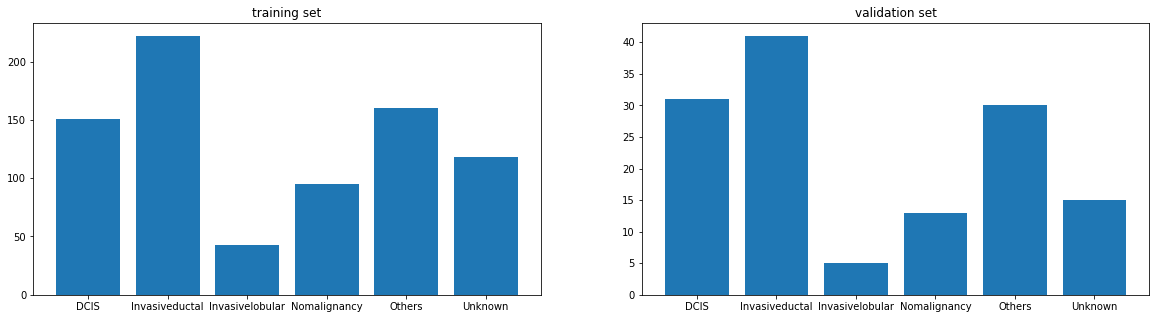

In [92]:
task_name = 'histo'
pprint.pprint('TRAINING SET')
df = pd.read_csv(os.path.join(data_dir, 'train_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
df = df.rename(columns={'label_' + task_name: 'label'})

print('Columns: ', df.columns)
print('Size: ', len(df))
print('Labels: ', df['label'].sort_values().unique())

print('------------------------------------------------------------')

pprint.pprint('VALIDATION SET')
dev_set = pd.read_csv(os.path.join(data_dir, 'dev_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
dev_set = dev_set.rename(columns={'label_' + task_name: 'label'})
print('Columns: ', dev_set.columns)
print('Size: ', len(dev_set))
print('Labels: ', dev_set['label'].sort_values().unique())



dfa, enc, labels = ohe_df(df, 'full_text', multi_label=True)
dfa_test = ohe_transform(dev_set, 'full_text', enc, multi_label=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
plt.subplot(1,2,1)
plt.bar(x = dfa.iloc[:, 1:].columns, height=dfa.iloc[:, 1:].sum())
plt.title('training set')

plt.subplot(1,2,2)
plt.bar(x = dfa_test.iloc[:, 1:].columns, height=dfa_test.iloc[:, 1:].sum())
plt.title('validation set')
plt.show()


In [93]:
a,b,c = ohe_df(df, 'full_text', multi_label=True)

In [94]:
ohe_transform(dev_set, 'full_text', b, multi_label=True)

,full_text,DCIS,Invasiveductal,Invasivelobular,Nomalignancy,Others,Unknown
0,"Anatomic Site:Left breast, core needle biopsy ...",0,1,0,0,0,0
1,Anatomic Site:T9 tumor (FS) \nT9 laminae \nC...,0,0,0,0,1,0
2,Anatomic Site:Right Breast Wire Localized Part...,1,1,0,0,0,0
3,"Anatomic Site:Right breast partial mastectomy,...",0,0,0,1,0,0
4,"Anatomic Site:L3, Soft Tissue, Fine Needle Asp...",0,0,0,0,1,0
...,...,...,...,...,...,...,...
94,UNIVERSITY OF CALIFORNIA ***** ***** \nDEPARTM...,1,1,0,0,1,0
95,UNIVERSITY OF CALIFORNIA ***** ***** \nDEPARTM...,0,0,0,0,1,0
96,UNIVERSITY OF CALIFORNIA ***** ***** \nDEPARTM...,0,0,0,0,1,0
97,UNIVERSITY OF CALIFORNIA ***** ***** \nDEPARTM...,0,0,0,0,1,0


In [95]:
best_params_, best_ngram, best_features, scores_L, results_ = Random_search(df,
                                                                            dev_set,
                                                                            'full_text',
                                                                            stop_w='english', multi_label=True)
dict_results['HISTO_SW'] = results_
dict_params['HISTO_SW'] = scores_L

features: 192, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.8078370258711552, training accuracy: 0.6929824561403509
validation f1-score: 0.6196844233708516, validation accuracy: 0.5757575757575758
----------------------------------------------------------------------------------------------------
features: 770, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.8007264835123492, training accuracy: 0.6912280701754386
validation f1-score: 0.6236459055931672, validation accuracy: 0.5656565656565656
----------------------------------------------------------------------------------------------------
features: 1348, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.7928417215355786, training accuracy: 0.6754385964912281
validation f1-score: 0.6188624068764026, validation accuracy: 0.5656565656565656
----------------------------------------------------------------------------------------------------
features: 1926, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.7766990681085164, training accuracy: 0.6596491228070176
validation f1-score: 0.5862963215254168, validation accuracy: 0.5252525252525253
----------------------------------------------------------------------------------------------------
features: 2504, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.7641629603741595, training accuracy: 0.6456140350877193
validation f1-score: 0.6104026017186536, validation accuracy: 0.5454545454545454
----------------------------------------------------------------------------------------------------
features: 3082, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.7445018923519536, training accuracy: 0.6421052631578947
validation f1-score: 0.6090243202819269, validation accuracy: 0.5454545454545454
----------------------------------------------------------------------------------------------------
features: 3660, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.7593593555031503, training accuracy: 0.6385964912280702
validation f1-score: 0.609488625624281, validation accuracy: 0.5454545454545454
----------------------------------------------------------------------------------------------------
features: 4238, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished


training f1-score: 0.7210765206095062, training accuracy: 0.6228070175438597
validation f1-score: 0.5835368878177501, validation accuracy: 0.5252525252525253
----------------------------------------------------------------------------------------------------
features: 4816, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.0s finished


training f1-score: 0.723335771232625, training accuracy: 0.6140350877192983
validation f1-score: 0.58921814339771, validation accuracy: 0.5252525252525253
----------------------------------------------------------------------------------------------------
features: 412, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.8223787350052355, training accuracy: 0.7087719298245614
validation f1-score: 0.6310860619073179, validation accuracy: 0.6161616161616161
----------------------------------------------------------------------------------------------------
features: 1030, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.8239696561132517, training accuracy: 0.7105263157894737
validation f1-score: 0.6164953084036197, validation accuracy: 0.5959595959595959
----------------------------------------------------------------------------------------------------
features: 1717, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.835814290041546, training accuracy: 0.7192982456140351
validation f1-score: 0.6367560134488145, validation accuracy: 0.6060606060606061
----------------------------------------------------------------------------------------------------
features: 2061, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.825154741456455, training accuracy: 0.7087719298245614
validation f1-score: 0.6510328396821625, validation accuracy: 0.6262626262626263
----------------------------------------------------------------------------------------------------
features: 8246, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.7s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.8s finished


training f1-score: 0.7917370385777582, training accuracy: 0.6649122807017543
validation f1-score: 0.6087974172719935, validation accuracy: 0.5656565656565656
----------------------------------------------------------------------------------------------------
features: 14431, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    2.0s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    3.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.4s finished


training f1-score: 0.7669543316746239, training accuracy: 0.6385964912280702
validation f1-score: 0.6177185649599443, validation accuracy: 0.5757575757575758
----------------------------------------------------------------------------------------------------
features: 20616, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.3s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    4.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.9s finished


training f1-score: 0.7372127101792425, training accuracy: 0.6192982456140351
validation f1-score: 0.6055829228243023, validation accuracy: 0.5555555555555556
----------------------------------------------------------------------------------------------------
features: 26801, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.3s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.7s finished


training f1-score: 0.7431500030157113, training accuracy: 0.612280701754386
validation f1-score: 0.6076984126984127, validation accuracy: 0.5454545454545454
----------------------------------------------------------------------------------------------------
features: 32986, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.1s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.9s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    7.5s finished


training f1-score: 0.7021227496173306, training accuracy: 0.5754385964912281
validation f1-score: 0.5952380952380953, validation accuracy: 0.5252525252525253
----------------------------------------------------------------------------------------------------
features: 39171, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.0s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.0s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.1s finished


training f1-score: 0.7059632499131863, training accuracy: 0.5736842105263158
validation f1-score: 0.5999021779254338, validation accuracy: 0.5454545454545454
----------------------------------------------------------------------------------------------------
features: 45356, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.7s remaining:   11.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.2s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.0s finished


training f1-score: 0.6831220333948244, training accuracy: 0.5649122807017544
validation f1-score: 0.6065291433712486, validation accuracy: 0.5555555555555556
----------------------------------------------------------------------------------------------------
features: 1119, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.8348173505868671, training accuracy: 0.724561403508772
validation f1-score: 0.5929194886283009, validation accuracy: 0.5858585858585859
----------------------------------------------------------------------------------------------------
features: 2797, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.1s finished


training f1-score: 0.8228491593112573, training accuracy: 0.7
validation f1-score: 0.6333445698199797, validation accuracy: 0.5959595959595959
----------------------------------------------------------------------------------------------------
features: 4662, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.3s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.2s finished


training f1-score: 0.8217335327700859, training accuracy: 0.7017543859649122
validation f1-score: 0.6441905825528215, validation accuracy: 0.6161616161616161
----------------------------------------------------------------------------------------------------
features: 5595, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.4s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.2s finished


training f1-score: 0.8181675753361807, training accuracy: 0.6912280701754386
validation f1-score: 0.6559745715107234, validation accuracy: 0.6363636363636364
----------------------------------------------------------------------------------------------------
features: 22383, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.5s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.9s finished


training f1-score: 0.7756929349369815, training accuracy: 0.6333333333333333
validation f1-score: 0.6072053120726458, validation accuracy: 0.5757575757575758
----------------------------------------------------------------------------------------------------
features: 39171, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.1s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.0s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.8s finished


training f1-score: 0.7406737139363836, training accuracy: 0.6
validation f1-score: 0.625710985975621, validation accuracy: 0.5858585858585859
----------------------------------------------------------------------------------------------------
features: 55959, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    7.7s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   11.2s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.5s finished


training f1-score: 0.7361654242461784, training accuracy: 0.5929824561403508
validation f1-score: 0.6184210526315789, validation accuracy: 0.5858585858585859
----------------------------------------------------------------------------------------------------
features: 72747, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   12.1s remaining:   20.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   15.9s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   19.3s finished


training f1-score: 0.7259762608193455, training accuracy: 0.5807017543859649
validation f1-score: 0.5997757218951499, validation accuracy: 0.5656565656565656
----------------------------------------------------------------------------------------------------
features: 89535, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   13.4s remaining:   22.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   19.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   23.8s finished


training f1-score: 0.6772792812688192, training accuracy: 0.5403508771929825
validation f1-score: 0.6046862351740402, validation accuracy: 0.5454545454545454
----------------------------------------------------------------------------------------------------
features: 106323, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   20.0s remaining:   32.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   27.4s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   29.3s finished


training f1-score: 0.6759868595341022, training accuracy: 0.5491228070175439
validation f1-score: 0.6087604288232137, validation accuracy: 0.5454545454545454
----------------------------------------------------------------------------------------------------
features: 123111, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   24.6s remaining:   40.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   33.3s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   34.2s finished


training f1-score: 0.6602198542140565, training accuracy: 0.5280701754385965
validation f1-score: 0.5854047389888904, validation accuracy: 0.5252525252525253
----------------------------------------------------------------------------------------------------
Best Score:  0.6559745715107234
Best ngram: 3
Best feature: 5595
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': 40, 'max_depth': 25}


In [96]:
max_score_10, best_report_10 = Train_test(df=df,
                                        dev_set=dev_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w='english',
                                        enable_balance=False,
                                        multi_label = True)

best accuracy score: 0.65
best f1 score:  0.66
best n_grams / number of features:  [3, 5595]
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.87      0.92        31
           1       0.81      0.85      0.83        41
           2       0.00      0.00      0.00         5
           3       0.90      0.69      0.78        13
           4       1.00      0.47      0.64        30
           5       0.91      0.67      0.77        15

   micro avg       0.90      0.70      0.79       135
   macro avg       0.76      0.59      0.66       135
weighted avg       0.88      0.70      0.77       135
 samples avg       0.71      0.69      0.69       135

['DCIS', 'Invasiveductal', 'Invasivelobular', 'Nomalignancy', 'Others', 'Unknown']


In [97]:
pprint.pprint('TEST SET')
test_set = pd.read_csv(os.path.join(data_dir, 'test_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
test_set = test_set.rename(columns={'label_' + task_name: 'label'})
print('Columns: ', test_set.columns)
print('Size: ', len(test_set))
print('Labels: ', test_set['label'].sort_values().unique())

test_score_10, test_report_10 = Train_test(df=df,
                                        dev_set=test_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w='english',
                                        enable_balance=False,
                                        multi_label = True)

'TEST SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  100
Labels:  ["{'DCIS', 'Others'}" "{'DCIS', 'Unknown', 'Others'}" "{'DCIS'}"
 "{'Invasive ductal', 'DCIS', 'Others'}" "{'Invasive ductal', 'DCIS'}"
 "{'Invasive ductal', 'Invasive lobular', 'Others'}"
 "{'Invasive ductal', 'Others'}" "{'Invasive ductal'}"
 "{'Invasive lobular', 'Others'}" "{'Invasive lobular'}"
 "{'No malignancy'}" "{'Others'}" "{'Unknown'}"]
best accuracy score: 0.58
best f1 score:  0.57
best n_grams / number of features:  [3, 5595]
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        28
           1       0.80      0.92      0.85        38
           2       0.00      0.00      0.00         4
           3       1.00      0.41      0.58        17
           4       1.00      0.36      0.53        33
           5       0.60      0.56      0.58        16

   micro avg       0.83     

In [98]:
best_params_, best_ngram, best_features, scores_L, results_ = Random_search(df,
                                                                            dev_set,
                                                                            'full_text',
                                                                            stop_w=None, multi_label=True)
dict_results['HISTO_'] = results_
dict_params['HISTO_'] = scores_L

features: 201, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.8224983555012414, training accuracy: 0.7087719298245614
validation f1-score: 0.6129857043704271, validation accuracy: 0.5959595959595959
----------------------------------------------------------------------------------------------------
features: 805, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.7462185159264633, training accuracy: 0.6368421052631579
validation f1-score: 0.6131820386430697, validation accuracy: 0.5555555555555556
----------------------------------------------------------------------------------------------------
features: 1409, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.7977569503143086, training accuracy: 0.6807017543859649
validation f1-score: 0.6174808906613493, validation accuracy: 0.5656565656565656
----------------------------------------------------------------------------------------------------
features: 2013, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.7810839516898317, training accuracy: 0.6631578947368421
validation f1-score: 0.5925454271242677, validation accuracy: 0.5353535353535354
----------------------------------------------------------------------------------------------------
features: 2617, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.7546086371633862, training accuracy: 0.6368421052631579
validation f1-score: 0.5724442337018402, validation accuracy: 0.5050505050505051
----------------------------------------------------------------------------------------------------
features: 3221, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.7381096682976126, training accuracy: 0.6298245614035087
validation f1-score: 0.5948144512404876, validation accuracy: 0.5252525252525253
----------------------------------------------------------------------------------------------------
features: 3825, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.7417208796373703, training accuracy: 0.6263157894736842
validation f1-score: 0.5860446761518202, validation accuracy: 0.5151515151515151
----------------------------------------------------------------------------------------------------
features: 4429, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.7202275251243035, training accuracy: 0.624561403508772
validation f1-score: 0.5700533836723095, validation accuracy: 0.5050505050505051
----------------------------------------------------------------------------------------------------
features: 438, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.8262329228609225, training accuracy: 0.7140350877192982
validation f1-score: 0.6298161222845463, validation accuracy: 0.6161616161616161
----------------------------------------------------------------------------------------------------
features: 1096, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.8365690059999181, training accuracy: 0.7175438596491228
validation f1-score: 0.6225024114647927, validation accuracy: 0.6060606060606061
----------------------------------------------------------------------------------------------------
features: 1827, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished


training f1-score: 0.8246894983175527, training accuracy: 0.7087719298245614
validation f1-score: 0.6252417279274894, validation accuracy: 0.5959595959595959
----------------------------------------------------------------------------------------------------
features: 2193, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.0s finished


training f1-score: 0.8245693970164115, training accuracy: 0.7070175438596491
validation f1-score: 0.64411452047929, validation accuracy: 0.6161616161616161
----------------------------------------------------------------------------------------------------
features: 8774, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.7s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.9s finished


training f1-score: 0.7966313926995133, training accuracy: 0.6736842105263158
validation f1-score: 0.6284240663551008, validation accuracy: 0.5959595959595959
----------------------------------------------------------------------------------------------------
features: 15355, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    2.3s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    3.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.6s finished


training f1-score: 0.7637108596041341, training accuracy: 0.6385964912280702
validation f1-score: 0.6101217223338619, validation accuracy: 0.5555555555555556
----------------------------------------------------------------------------------------------------
features: 21936, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.9s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.8s finished


training f1-score: 0.7270648229535727, training accuracy: 0.6087719298245614
validation f1-score: 0.6165270661109973, validation accuracy: 0.5656565656565656
----------------------------------------------------------------------------------------------------
features: 28517, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.5s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.8s finished


training f1-score: 0.7360380452009009, training accuracy: 0.6070175438596491
validation f1-score: 0.5908521303258145, validation accuracy: 0.5353535353535354
----------------------------------------------------------------------------------------------------
features: 35098, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.7s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    7.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.3s finished


training f1-score: 0.7223344908885583, training accuracy: 0.6017543859649123
validation f1-score: 0.6112734311463893, validation accuracy: 0.5656565656565656
----------------------------------------------------------------------------------------------------
features: 41679, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.3s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.8s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.7s finished


training f1-score: 0.7178614763073244, training accuracy: 0.5929824561403508
validation f1-score: 0.5994651483781919, validation accuracy: 0.5353535353535354
----------------------------------------------------------------------------------------------------
features: 48260, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    7.2s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   10.0s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.6s finished


training f1-score: 0.7201877669428102, training accuracy: 0.6070175438596491
validation f1-score: 0.6231353484111887, validation accuracy: 0.5656565656565656
----------------------------------------------------------------------------------------------------
features: 54841, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.2s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   10.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   11.9s finished


training f1-score: 0.6922819617376973, training accuracy: 0.5701754385964912
validation f1-score: 0.563591698570056, validation accuracy: 0.5050505050505051
----------------------------------------------------------------------------------------------------
features: 1268, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.8313032285633648, training accuracy: 0.7210526315789474
validation f1-score: 0.6000187055742612, validation accuracy: 0.5858585858585859
----------------------------------------------------------------------------------------------------
features: 3171, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.3s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.0s finished


training f1-score: 0.825979970052504, training accuracy: 0.7017543859649122
validation f1-score: 0.6588555041944872, validation accuracy: 0.6363636363636364
----------------------------------------------------------------------------------------------------
features: 5285, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.5s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.3s finished


training f1-score: 0.816856653809332, training accuracy: 0.6964912280701754
validation f1-score: 0.6329712735338869, validation accuracy: 0.5959595959595959
----------------------------------------------------------------------------------------------------
features: 6343, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.7s finished


training f1-score: 0.7942105338613236, training accuracy: 0.6614035087719298
validation f1-score: 0.6167356797791581, validation accuracy: 0.5959595959595959
----------------------------------------------------------------------------------------------------
features: 25372, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.3s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.5s finished


training f1-score: 0.7747981107290566, training accuracy: 0.6526315789473685
validation f1-score: 0.6387415266725612, validation accuracy: 0.6060606060606061
----------------------------------------------------------------------------------------------------
features: 44401, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.4s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.4s finished


training f1-score: 0.7329657960406742, training accuracy: 0.6017543859649123
validation f1-score: 0.6416548923766245, validation accuracy: 0.6060606060606061
----------------------------------------------------------------------------------------------------
features: 63430, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.1s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   12.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   16.0s finished


training f1-score: 0.7195073689601322, training accuracy: 0.5964912280701754
validation f1-score: 0.623968253968254, validation accuracy: 0.5757575757575758
----------------------------------------------------------------------------------------------------
features: 82459, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   11.0s remaining:   18.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   18.1s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   21.7s finished


training f1-score: 0.7071892839430288, training accuracy: 0.5842105263157895
validation f1-score: 0.6214619883040936, validation accuracy: 0.5656565656565656
----------------------------------------------------------------------------------------------------
features: 101488, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   15.6s remaining:   25.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   21.6s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   26.7s finished


training f1-score: 0.6951113076322711, training accuracy: 0.5701754385964912
validation f1-score: 0.603319783197832, validation accuracy: 0.5555555555555556
----------------------------------------------------------------------------------------------------
features: 120517, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   24.0s remaining:   39.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   31.3s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   36.0s finished


training f1-score: 0.6810802513228004, training accuracy: 0.5543859649122806
validation f1-score: 0.6065698956584707, validation accuracy: 0.5656565656565656
----------------------------------------------------------------------------------------------------
features: 139546, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   27.3s remaining:   45.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   38.3s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   40.0s finished


training f1-score: 0.6680404308417316, training accuracy: 0.5578947368421052
validation f1-score: 0.6306974753958067, validation accuracy: 0.5858585858585859
----------------------------------------------------------------------------------------------------
Best Score:  0.6588555041944872
Best ngram: 3
Best feature: 3171
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': 40, 'max_depth': 25}


In [99]:
max_score_10b, best_report_10b = Train_test(df=df,
                                        dev_set=dev_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w=None,
                                        enable_balance=False,
                                        multi_label=True)

best accuracy score: 0.64
best f1 score:  0.66
best n_grams / number of features:  [3, 3171]
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.90      0.93        31
           1       0.81      0.85      0.83        41
           2       0.00      0.00      0.00         5
           3       1.00      0.69      0.82        13
           4       1.00      0.43      0.60        30
           5       0.91      0.67      0.77        15

   micro avg       0.90      0.70      0.79       135
   macro avg       0.78      0.59      0.66       135
weighted avg       0.89      0.70      0.77       135
 samples avg       0.70      0.68      0.69       135

['DCIS', 'Invasiveductal', 'Invasivelobular', 'Nomalignancy', 'Others', 'Unknown']


## SITE DISEASE

'TRAINING SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  570
Labels:  ["{'Left Breast', 'Left LN'}" "{'Left Breast', 'Other tissues'}"
 "{'Left Breast', 'Right Breast'}" "{'Left Breast', 'Unknown'}"
 "{'Left Breast'}" "{'Left LN', 'Right Breast'}" "{'Left LN'}" "{'None'}"
 "{'Other tissues', 'Right Breast', 'Right LN'}"
 "{'Other tissues', 'Right Breast'}" "{'Other tissues'}"
 "{'Right Breast', 'Right LN'}" "{'Right Breast'}" "{'Right LN'}"
 "{'Unknown'}"]
------------------------------------------------------------
'VALIDATION SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  99
Labels:  ["{'Left Breast', 'Right Breast', 'Right LN'}"
 "{'Left Breast', 'Right Breast'}" "{'Left Breast'}"
 "{'Left LN', 'Left Breast'}" "{'Left LN'}" "{'None'}" "{'Other tissues'}"
 "{'Right Breast', 'Right LN'}" "{'Right Breast'}" "{'Right LN'}"
 "{'Unknown'}"]


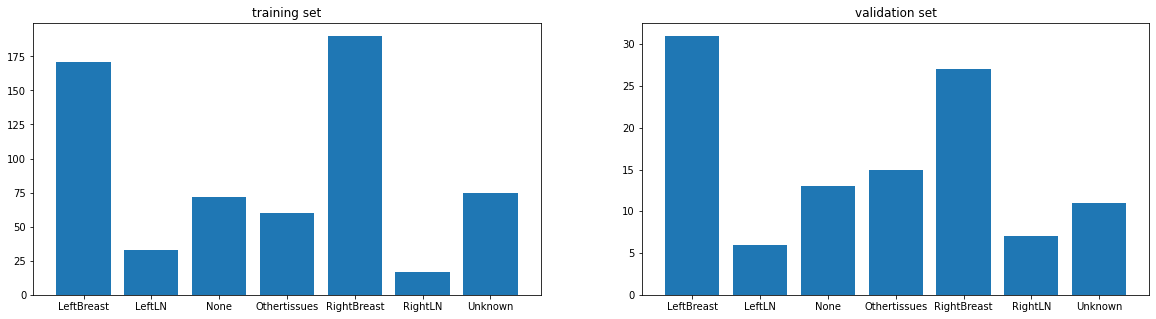

In [100]:
task_name = 'site_disease'
pprint.pprint('TRAINING SET')
df = pd.read_csv(os.path.join(data_dir, 'train_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
df = df.rename(columns={'label_' + task_name: 'label'})

print('Columns: ', df.columns)
print('Size: ', len(df))
print('Labels: ', df['label'].sort_values().unique())

print('------------------------------------------------------------')

pprint.pprint('VALIDATION SET')
dev_set = pd.read_csv(os.path.join(data_dir, 'dev_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
dev_set = dev_set.rename(columns={'label_' + task_name: 'label'})
print('Columns: ', dev_set.columns)
print('Size: ', len(dev_set))
print('Labels: ', dev_set['label'].sort_values().unique())



dfa, enc, labels = ohe_df(df, 'full_text', multi_label=True)
dfa_test = ohe_transform(dev_set, 'full_text', enc, multi_label=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
plt.subplot(1,2,1)
plt.bar(x = dfa.iloc[:, 1:].columns, height=dfa.iloc[:, 1:].sum())
plt.title('training set')

plt.subplot(1,2,2)
plt.bar(x = dfa_test.iloc[:, 1:].columns, height=dfa_test.iloc[:, 1:].sum())
plt.title('validation set')
plt.show()

In [101]:
best_params_, best_ngram, best_features, scores_L, results_ = Random_search(df,
                                                                            dev_set,
                                                                            'full_text',
                                                                            stop_w='english', multi_label=True)
dict_results['SITES_DIS_SW'] = results_
dict_params['SITES_DIS_SW'] = scores_L

features: 192, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.6144170172563932, training accuracy: 0.7684210526315789
validation f1-score: 0.42347057704200564, validation accuracy: 0.5353535353535354
----------------------------------------------------------------------------------------------------
features: 770, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.611345257287348, training accuracy: 0.7491228070175439
validation f1-score: 0.38319662793347004, validation accuracy: 0.45454545454545453
----------------------------------------------------------------------------------------------------
features: 1348, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.5892836609320921, training accuracy: 0.7087719298245614
validation f1-score: 0.41548749825744835, validation accuracy: 0.47474747474747475
----------------------------------------------------------------------------------------------------
features: 1926, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.5745563343067737, training accuracy: 0.6666666666666666
validation f1-score: 0.3747800831609519, validation accuracy: 0.40404040404040403
----------------------------------------------------------------------------------------------------
features: 2504, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.5653992516109172, training accuracy: 0.6666666666666666
validation f1-score: 0.3599253034547152, validation accuracy: 0.37373737373737376
----------------------------------------------------------------------------------------------------
features: 3082, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.5408685374771443, training accuracy: 0.6298245614035087
validation f1-score: 0.3587980646804176, validation accuracy: 0.3838383838383838
----------------------------------------------------------------------------------------------------
features: 3660, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.544837204574948, training accuracy: 0.6298245614035087
validation f1-score: 0.3603892839186957, validation accuracy: 0.3838383838383838
----------------------------------------------------------------------------------------------------
features: 4238, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.1s finished


training f1-score: 0.5181056252759942, training accuracy: 0.5964912280701754
validation f1-score: 0.3334078711985689, validation accuracy: 0.35353535353535354
----------------------------------------------------------------------------------------------------
features: 4816, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.3s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished


training f1-score: 0.5271499123450969, training accuracy: 0.6017543859649123
validation f1-score: 0.24676369936179054, validation accuracy: 0.26262626262626265
----------------------------------------------------------------------------------------------------
features: 412, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


training f1-score: 0.6403269114691723, training accuracy: 0.8
validation f1-score: 0.4793639914736509, validation accuracy: 0.5858585858585859
----------------------------------------------------------------------------------------------------
features: 1030, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.6180437707920945, training accuracy: 0.7631578947368421
validation f1-score: 0.47211819379307063, validation accuracy: 0.5656565656565656
----------------------------------------------------------------------------------------------------
features: 1717, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.6245373322280727, training accuracy: 0.756140350877193
validation f1-score: 0.42158054711246196, validation accuracy: 0.5151515151515151
----------------------------------------------------------------------------------------------------
features: 2061, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.63874697621431, training accuracy: 0.7684210526315789
validation f1-score: 0.4236398675693037, validation accuracy: 0.5151515151515151
----------------------------------------------------------------------------------------------------
features: 8246, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.6s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.8s finished


training f1-score: 0.5070532164975537, training accuracy: 0.5877192982456141
validation f1-score: 0.29561549561549566, validation accuracy: 0.37373737373737376
----------------------------------------------------------------------------------------------------
features: 14431, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    2.1s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    3.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.6s finished


training f1-score: 0.5555688129848989, training accuracy: 0.643859649122807
validation f1-score: 0.3433673469387754, validation accuracy: 0.3838383838383838
----------------------------------------------------------------------------------------------------
features: 20616, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.4s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.5s finished


training f1-score: 0.5221043919121064, training accuracy: 0.6017543859649123
validation f1-score: 0.3511228005414052, validation accuracy: 0.37373737373737376
----------------------------------------------------------------------------------------------------
features: 26801, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.4s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    7.2s finished


training f1-score: 0.488842311915452, training accuracy: 0.5543859649122806
validation f1-score: 0.3033633387888707, validation accuracy: 0.32323232323232326
----------------------------------------------------------------------------------------------------
features: 32986, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.0s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    7.1s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.2s finished


training f1-score: 0.48418230510595045, training accuracy: 0.5578947368421052
validation f1-score: 0.2585761577358216, validation accuracy: 0.29292929292929293
----------------------------------------------------------------------------------------------------
features: 39171, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.0s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.0s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.7s finished


training f1-score: 0.4744621648747241, training accuracy: 0.5403508771929825
validation f1-score: 0.25724933451641524, validation accuracy: 0.2828282828282828
----------------------------------------------------------------------------------------------------
features: 45356, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    7.3s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.5s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.4s finished


training f1-score: 0.4487678329845508, training accuracy: 0.5228070175438596
validation f1-score: 0.25611023896738183, validation accuracy: 0.2828282828282828
----------------------------------------------------------------------------------------------------
features: 1119, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.6228647486284119, training accuracy: 0.7736842105263158
validation f1-score: 0.47049030960947386, validation accuracy: 0.5757575757575758
----------------------------------------------------------------------------------------------------
features: 2797, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.0s finished


training f1-score: 0.6039251604531529, training accuracy: 0.7263157894736842
validation f1-score: 0.39514278824623655, validation accuracy: 0.47474747474747475
----------------------------------------------------------------------------------------------------
features: 4662, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.3s finished


training f1-score: 0.6274457767709576, training accuracy: 0.7263157894736842
validation f1-score: 0.393877472215283, validation accuracy: 0.46464646464646464
----------------------------------------------------------------------------------------------------
features: 5595, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.5s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.4s finished


training f1-score: 0.6052902171167176, training accuracy: 0.6964912280701754
validation f1-score: 0.4033895529096297, validation accuracy: 0.45454545454545453
----------------------------------------------------------------------------------------------------
features: 22383, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.5s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.4s finished


training f1-score: 0.5360474572473165, training accuracy: 0.6087719298245614
validation f1-score: 0.34885762385762387, validation accuracy: 0.37373737373737376
----------------------------------------------------------------------------------------------------
features: 39171, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.1s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.5s finished


training f1-score: 0.5215701286856379, training accuracy: 0.5929824561403508
validation f1-score: 0.3273850363473005, validation accuracy: 0.3333333333333333
----------------------------------------------------------------------------------------------------
features: 55959, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.2s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   11.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   13.4s finished


training f1-score: 0.4796277279594136, training accuracy: 0.5508771929824562
validation f1-score: 0.24329618372171563, validation accuracy: 0.25252525252525254
----------------------------------------------------------------------------------------------------
features: 72747, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   12.1s remaining:   19.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   16.5s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   20.9s finished


training f1-score: 0.4697219114616508, training accuracy: 0.531578947368421
validation f1-score: 0.2474012860958337, validation accuracy: 0.26262626262626265
----------------------------------------------------------------------------------------------------
features: 89535, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   14.1s remaining:   23.3s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   22.7s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   25.7s finished


training f1-score: 0.4445985150146538, training accuracy: 0.5140350877192983
validation f1-score: 0.26814529798630415, validation accuracy: 0.26262626262626265
----------------------------------------------------------------------------------------------------
features: 106323, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   20.6s remaining:   33.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   27.6s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   30.2s finished


training f1-score: 0.41422058564055947, training accuracy: 0.5035087719298246
validation f1-score: 0.21927188457800703, validation accuracy: 0.24242424242424243
----------------------------------------------------------------------------------------------------
features: 123111, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   24.9s remaining:   41.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   31.5s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   36.6s finished


training f1-score: 0.4017697063205429, training accuracy: 0.48596491228070177
validation f1-score: 0.25062251315620593, validation accuracy: 0.2828282828282828
----------------------------------------------------------------------------------------------------
Best Score:  0.4793639914736509
Best ngram: 2
Best feature: 412
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': 40, 'max_depth': 25}


In [102]:
max_score_11, best_report_11 = Train_test(df=df,
                                        dev_set=dev_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w='english',
                                        enable_balance=False,
                                        multi_label = True)

best accuracy score: 0.6
best f1 score:  0.49
best n_grams / number of features:  [2, 412]
------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        31
           1       0.00      0.00      0.00         6
           2       0.92      0.85      0.88        13
           3       1.00      0.20      0.33        15
           4       0.92      0.81      0.86        27
           5       0.00      0.00      0.00         7
           6       1.00      0.27      0.43        11

   micro avg       0.96      0.61      0.74       110
   macro avg       0.69      0.43      0.49       110
weighted avg       0.85      0.61      0.67       110
 samples avg       0.68      0.63      0.65       110

['LeftBreast', 'LeftLN', 'None', 'Othertissues', 'RightBreast', 'RightLN', 'Unknown']


In [103]:
pprint.pprint('TEST SET')
test_set = pd.read_csv(os.path.join(data_dir, 'test_all.csv'), usecols=['idx', 'full_text', 'label_'+task_name])
test_set = test_set.rename(columns={'label_' + task_name: 'label'})
print('Columns: ', test_set.columns)
print('Size: ', len(test_set))
print('Labels: ', test_set['label'].sort_values().unique())

test_score_11, test_report_11 = Train_test(df=df,
                                        dev_set=dev_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w='english',
                                        enable_balance=False,
                                        multi_label = True)

'TEST SET'
Columns:  Index(['idx', 'full_text', 'label'], dtype='object')
Size:  100
Labels:  ["{'Left Breast', 'Right Breast'}" "{'Left Breast'}"
 "{'Left LN', 'Left Breast'}" "{'Left LN'}" "{'None'}" "{'Other tissues'}"
 "{'Right Breast', 'Right LN'}" "{'Right Breast'}" "{'Unknown'}"]
best accuracy score: 0.6
best f1 score:  0.49
best n_grams / number of features:  [2, 412]
------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        31
           1       0.00      0.00      0.00         6
           2       0.92      0.85      0.88        13
           3       1.00      0.20      0.33        15
           4       0.92      0.81      0.86        27
           5       0.00      0.00      0.00         7
           6       1.00      0.27      0.43        11

   micro avg       0.96      0.61      0.74       110
   macro avg       0.69      0.43      0.49       110
weighted avg       0.85 

In [104]:
best_params_, best_ngram, best_features, scores_L, results_ = Random_search(df,
                                                                            dev_set,
                                                                            'full_text',
                                                                            stop_w=None, multi_label=True)
dict_results['SITES_DIS_'] = results_
dict_params['SITES_DIS_'] = scores_L

features: 201, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.6269843470575933, training accuracy: 0.7789473684210526
validation f1-score: 0.38613291470434324, validation accuracy: 0.5050505050505051
----------------------------------------------------------------------------------------------------
features: 805, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.609232972364428, training accuracy: 0.7403508771929824
validation f1-score: 0.39443098628029033, validation accuracy: 0.46464646464646464
----------------------------------------------------------------------------------------------------
features: 1409, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


training f1-score: 0.595501953691927, training accuracy: 0.7192982456140351
validation f1-score: 0.3932867883995703, validation accuracy: 0.46464646464646464
----------------------------------------------------------------------------------------------------
features: 2013, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.5761639966937604, training accuracy: 0.6807017543859649
validation f1-score: 0.3693121693121693, validation accuracy: 0.41414141414141414
----------------------------------------------------------------------------------------------------
features: 2617, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.5741389343445373, training accuracy: 0.6789473684210526
validation f1-score: 0.3466999202781888, validation accuracy: 0.36363636363636365
----------------------------------------------------------------------------------------------------
features: 3221, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


training f1-score: 0.5724691748798556, training accuracy: 0.6701754385964912
validation f1-score: 0.32543752543752547, validation accuracy: 0.37373737373737376
----------------------------------------------------------------------------------------------------
features: 3825, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished


training f1-score: 0.556314520646761, training accuracy: 0.6456140350877193
validation f1-score: 0.3335689254056601, validation accuracy: 0.3434343434343434
----------------------------------------------------------------------------------------------------
features: 4429, ngrams: 1
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.0s finished


training f1-score: 0.5377851185216674, training accuracy: 0.624561403508772
validation f1-score: 0.2834798534798535, validation accuracy: 0.32323232323232326
----------------------------------------------------------------------------------------------------
features: 438, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


training f1-score: 0.6411878607236778, training accuracy: 0.8
validation f1-score: 0.47783745076978157, validation accuracy: 0.5656565656565656
----------------------------------------------------------------------------------------------------
features: 1096, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


training f1-score: 0.6240144564871225, training accuracy: 0.7771929824561403
validation f1-score: 0.44908963585434175, validation accuracy: 0.5454545454545454
----------------------------------------------------------------------------------------------------
features: 1827, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished


training f1-score: 0.6281610297096998, training accuracy: 0.7684210526315789
validation f1-score: 0.3922522200369509, validation accuracy: 0.47474747474747475
----------------------------------------------------------------------------------------------------
features: 2193, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.0s finished


training f1-score: 0.6252749259019368, training accuracy: 0.7631578947368421
validation f1-score: 0.44514235914344097, validation accuracy: 0.5151515151515151
----------------------------------------------------------------------------------------------------
features: 8774, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.7s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.8s finished


training f1-score: 0.5877320056082942, training accuracy: 0.7052631578947368
validation f1-score: 0.320020415781094, validation accuracy: 0.40404040404040403
----------------------------------------------------------------------------------------------------
features: 15355, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    2.2s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    3.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.8s finished


training f1-score: 0.5396479321684888, training accuracy: 0.6298245614035087
validation f1-score: 0.30404346056519976, validation accuracy: 0.36363636363636365
----------------------------------------------------------------------------------------------------
features: 21936, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    3.7s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.8s finished


training f1-score: 0.5356742326293762, training accuracy: 0.6228070175438597
validation f1-score: 0.31003124782194547, validation accuracy: 0.35353535353535354
----------------------------------------------------------------------------------------------------
features: 28517, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.5s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    6.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.9s finished


training f1-score: 0.5148816369589875, training accuracy: 0.5912280701754385
validation f1-score: 0.29388905667975435, validation accuracy: 0.3434343434343434
----------------------------------------------------------------------------------------------------
features: 35098, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    5.3s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    7.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.4s finished


training f1-score: 0.4964582950166097, training accuracy: 0.5842105263157895
validation f1-score: 0.2716569145140574, validation accuracy: 0.31313131313131315
----------------------------------------------------------------------------------------------------
features: 41679, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.0s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    8.5s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.4s finished


training f1-score: 0.4846755889263707, training accuracy: 0.5701754385964912
validation f1-score: 0.27033823319537603, validation accuracy: 0.29292929292929293
----------------------------------------------------------------------------------------------------
features: 48260, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.9s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   11.1s finished


training f1-score: 0.4542070708390625, training accuracy: 0.5280701754385965
validation f1-score: 0.21973646065233918, validation accuracy: 0.2222222222222222
----------------------------------------------------------------------------------------------------
features: 54841, ngrams: 2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.4s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   11.0s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.9s finished


training f1-score: 0.4395960662898788, training accuracy: 0.5280701754385965
validation f1-score: 0.22759921918754178, validation accuracy: 0.24242424242424243
----------------------------------------------------------------------------------------------------
features: 1268, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished


training f1-score: 0.6214141694225515, training accuracy: 0.7649122807017544
validation f1-score: 0.39535781009906273, validation accuracy: 0.5050505050505051
----------------------------------------------------------------------------------------------------
features: 3171, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.3s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.4s finished


training f1-score: 0.6289196679809859, training accuracy: 0.7508771929824561
validation f1-score: 0.4127432944062283, validation accuracy: 0.494949494949495
----------------------------------------------------------------------------------------------------
features: 5285, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.5s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.7s finished


training f1-score: 0.6009109822668295, training accuracy: 0.7298245614035088
validation f1-score: 0.39418613118753293, validation accuracy: 0.47474747474747475
----------------------------------------------------------------------------------------------------
features: 6343, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    1.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    2.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.6s finished


training f1-score: 0.5875063919721903, training accuracy: 0.7052631578947368
validation f1-score: 0.36638387412381224, validation accuracy: 0.41414141414141414
----------------------------------------------------------------------------------------------------
features: 25372, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    4.0s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    5.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.6s finished


training f1-score: 0.5456764113033239, training accuracy: 0.6210526315789474
validation f1-score: 0.30876714322092474, validation accuracy: 0.32323232323232326
----------------------------------------------------------------------------------------------------
features: 44401, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    6.5s remaining:   10.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:    9.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.1s finished


training f1-score: 0.5171883846310531, training accuracy: 0.5912280701754385
validation f1-score: 0.27382777501244404, validation accuracy: 0.2727272727272727
----------------------------------------------------------------------------------------------------
features: 63430, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    8.6s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   12.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   16.7s finished


training f1-score: 0.49789908652061693, training accuracy: 0.5666666666666667
validation f1-score: 0.3091597103957862, validation accuracy: 0.31313131313131315
----------------------------------------------------------------------------------------------------
features: 82459, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   13.0s remaining:   21.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   17.3s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   21.1s finished


training f1-score: 0.465952893605427, training accuracy: 0.5368421052631579
validation f1-score: 0.24948584084796707, validation accuracy: 0.26262626262626265
----------------------------------------------------------------------------------------------------
features: 101488, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   17.1s remaining:   28.2s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   21.2s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   27.2s finished


training f1-score: 0.47347527261920064, training accuracy: 0.5368421052631579
validation f1-score: 0.25286341486949393, validation accuracy: 0.23232323232323232
----------------------------------------------------------------------------------------------------
features: 120517, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   24.7s remaining:   40.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   31.8s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   35.4s finished


training f1-score: 0.4280314873051643, training accuracy: 0.5052631578947369
validation f1-score: 0.2015866370146429, validation accuracy: 0.21212121212121213
----------------------------------------------------------------------------------------------------
features: 139546, ngrams: 3
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:   27.7s remaining:   45.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   37.4s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   40.5s finished


training f1-score: 0.4135698425668634, training accuracy: 0.48947368421052634
validation f1-score: 0.18808463514054805, validation accuracy: 0.1919191919191919
----------------------------------------------------------------------------------------------------
Best Score:  0.47783745076978157
Best ngram: 2
Best feature: 438
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': 40, 'max_depth': 25}


In [105]:
max_score_11b, best_report_11b = Train_test(df=df,
                                        dev_set=dev_set,
                                        column='full_text',
                                        best_params_=best_params_,
                                        best_ngram = best_ngram,
                                        best_features= best_features,
                                        stop_w=None,
                                        enable_balance=False,
                                        multi_label = True)

best accuracy score: 0.56
best f1 score:  0.45
best n_grams / number of features:  [2, 438]
------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        31
           1       0.00      0.00      0.00         6
           2       0.67      0.46      0.55        13
           3       1.00      0.27      0.42        15
           4       0.91      0.78      0.84        27
           5       0.00      0.00      0.00         7
           6       0.75      0.27      0.40        11

   micro avg       0.91      0.57      0.70       110
   macro avg       0.62      0.39      0.45       110
weighted avg       0.80      0.57      0.64       110
 samples avg       0.64      0.59      0.61       110

['LeftBreast', 'LeftLN', 'None', 'Othertissues', 'RightBreast', 'RightLN', 'Unknown']


## Compare stopword performance

In [ ]:
scores_names = ['PATH_TYPE', 'GRADE', 'PR', 'HER2', 'BIOPSY', 'ER',
                'LVI', 'DCIS_MARGINS', 'MARGINS', 'LN_INVOLVEMENT', 'SITE_EXAMINED', 'HISTOLOGY', 'SITE_DISEASE']
scores_NOSW = [max_score_1, max_score_2, max_score_3,
               max_score_4, max_score_5, max_score_6,
               max_score_7, max_score_8, max_score_12, max_score_13,
               max_score_9, max_score_10, max_score_11
              ]

scores_SW = [max_score_1b, max_score_2b, max_score_3b,
             max_score_4b, max_score_5b, max_score_6b,
             max_score_7b, max_score_8b, max_score_12b, max_score_13b,
             max_score_9b, max_score_10b, max_score_11b
            ]

x = np.arange(len(scores_names))
f, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,8))
plt.bar(height=scores_NOSW, x = x-0.2, width=0.3, label= 'Without stop words')
plt.bar(height=scores_SW, x = x+0.2, width=0.3, label='With stop words')
plt.xticks(x, rotation='vertical', labels=scores_names, fontsize=15)
plt.ylabel('f1-score "macro" average', fontsize=15)
plt.title('f1-score "macro" results on development set (with and without stopwords)', fontsize=15)
plt.legend()
plt.show()

## Scratch work SCRATCH

IndexError: index 11 is out of bounds for axis 0 with size 11

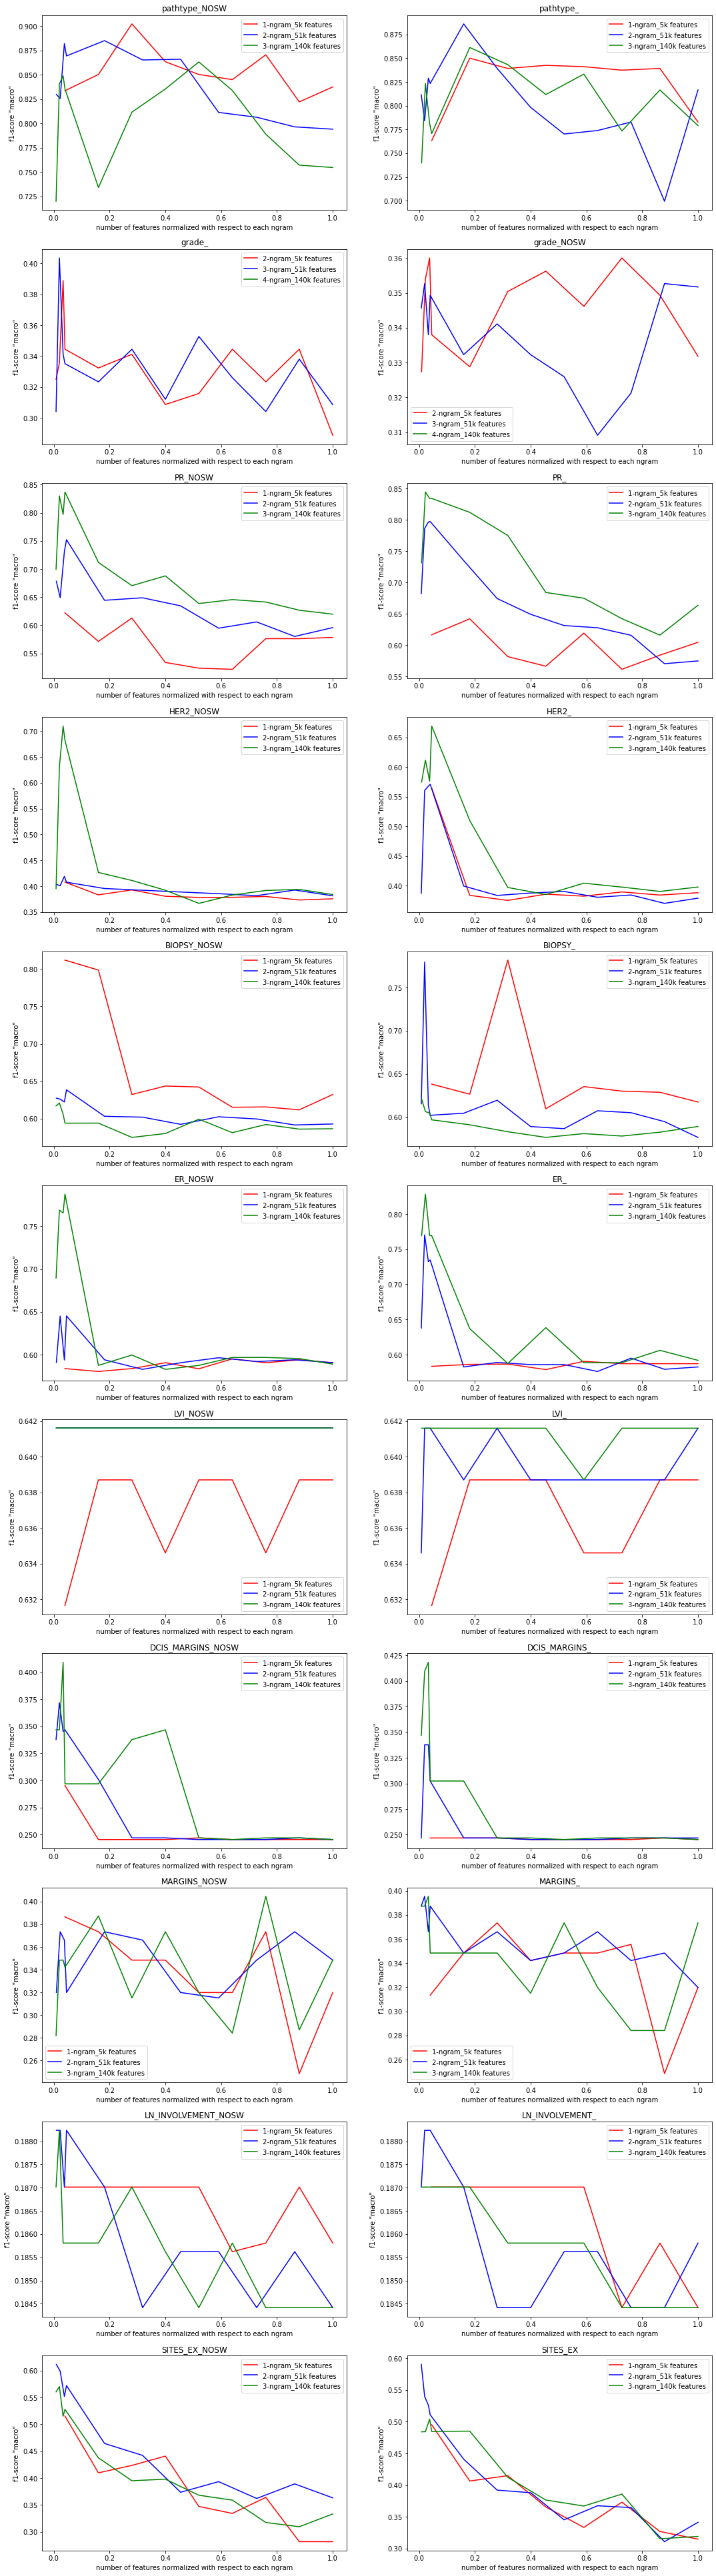

In [141]:
i = 0
k = 0
fig,ax = plt.subplots(nrows=11, ncols=2, figsize=(18,70))
for key in dict_results.keys():
    pathtype_SW_results = dict_results[key]
    L_1_f = []
    L_1_s = []
    L_2_f = []
    L_2_s = []
    L_3_f = []
    L_3_s = []

    if key == 'grade_SW' or key == 'grade_':

        for j in range(len(pathtype_SW_results)):
            if pathtype_SW_results[j][0] == 2:
                L_1_f.append(pathtype_SW_results[j][1])
                L_1_s.append(pathtype_SW_results[j][3])
            elif pathtype_SW_results[j][0] == 3:
                L_2_f.append(pathtype_SW_results[j][1])
                L_2_s.append(pathtype_SW_results[j][3])
            elif pathtype_SW_results[j][0] == 4:
                L_3_f.append(pathtype_SW_results[j][1])
                L_3_s.append(pathtype_SW_results[j][3])
    else:

        for j in range(len(pathtype_SW_results)):
            if pathtype_SW_results[j][0] == 1:
                L_1_f.append(pathtype_SW_results[j][1])
                L_1_s.append(pathtype_SW_results[j][3])
            elif pathtype_SW_results[j][0] == 2:
                L_2_f.append(pathtype_SW_results[j][1])
                L_2_s.append(pathtype_SW_results[j][3])
            elif pathtype_SW_results[j][0] == 3:
                L_3_f.append(pathtype_SW_results[j][1])
                L_3_s.append(pathtype_SW_results[j][3])

    L_1_f = [r/np.max(L_1_f) for r in L_1_f]
    L_2_f = [r/np.max(L_2_f) for r in L_2_f]
    L_3_f = [r/np.max(L_3_f) for r in L_3_f]

    if key == 'grade_SW' or key == 'grade_':

        ax[i,k].plot(L_1_f, L_1_s, c = 'r', label= '2-ngram_5k features')
        ax[i,k].plot(L_2_f, L_2_s, c = 'b', label= '3-ngram_51k features')
        ax[i,k].plot(L_3_f, L_3_s, c = 'g', label= '4-ngram_140k features')
    else:

        ax[i,k].plot(L_1_f, L_1_s, c = 'r', label= '1-ngram_5k features')
        ax[i,k].plot(L_2_f, L_2_s, c = 'b', label= '2-ngram_51k features')
        ax[i,k].plot(L_3_f, L_3_s, c = 'g', label= '3-ngram_140k features')

    ax[i,k].set_xlabel('number of features normalized with respect to each ngram')
    ax[i,k].set_ylabel('f1-score "macro"')
    ax[i,k].legend()
    key = key.replace('SW', 'NOSW')
    ax[i,k].set_title(key)
    extent = ax[i,k].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'{key}.png', bbox_inches=extent.expanded(1.25, 1.15))
    k+=1

    if k == 2:
        i+=1
        k=0

In [ ]:
fig,ax = plt.subplots(nrows=3, ncols=1, figsize=(10,20))
for key in dict_results.keys():
    pathtype_SW_results = dict_results[key]
    L_1_f = []
    L_1_s = []
    L_2_f = []
    L_2_s = []
    L_3_f = []
    L_3_s = []

    if key == 'grade_SW' or key == 'grade_':

        for j in range(len(pathtype_SW_results)):
            if pathtype_SW_results[j][0] == 2:
                L_1_f.append(pathtype_SW_results[j][1])
                L_1_s.append(pathtype_SW_results[j][3])
            elif pathtype_SW_results[j][0] == 3:
                L_2_f.append(pathtype_SW_results[j][1])
                L_2_s.append(pathtype_SW_results[j][3])
            elif pathtype_SW_results[j][0] == 4:
                L_3_f.append(pathtype_SW_results[j][1])
                L_3_s.append(pathtype_SW_results[j][3])
    else:

        for j in range(len(pathtype_SW_results)):
            if pathtype_SW_results[j][0] == 1:
                L_1_f.append(pathtype_SW_results[j][1])
                L_1_s.append(pathtype_SW_results[j][3])
            elif pathtype_SW_results[j][0] == 2:
                L_2_f.append(pathtype_SW_results[j][1])
                L_2_s.append(pathtype_SW_results[j][3])
            elif pathtype_SW_results[j][0] == 3:
                L_3_f.append(pathtype_SW_results[j][1])
                L_3_s.append(pathtype_SW_results[j][3])

    L_1_f = [r/np.max(L_1_f) for r in L_1_f]
    L_2_f = [r/np.max(L_2_f) for r in L_2_f]
    L_3_f = [r/np.max(L_3_f) for r in L_3_f]

    L_1_s = [r/np.max(L_1_s) for r in L_1_s]
    L_2_s = [r/np.max(L_2_s) for r in L_2_s]
    L_3_s = [r/np.max(L_3_s) for r in L_3_s]

    ax[0].plot(L_1_f, L_1_s, label= key)
    ax[1].plot(L_2_f, L_2_s, label= key)
    ax[2].plot(L_3_f, L_3_s, label= key)

    ax[0].legend(bbox_to_anchor = (1.1,1), ncol=2)
    ax[0].set_title('1-ngram validation f1-score vs number of features')
    ax[0].set_xlabel('normalized number of features')
    ax[0].set_ylabel('normalized f-1 scores')
    ax[1].legend(bbox_to_anchor = (1.1,1), ncol=2)
    ax[1].set_title('2-ngram validation f1-score vs number of features')
    ax[1].set_xlabel('normalized number of features')
    ax[1].set_ylabel('normalized f-1 scores')
    ax[2].legend(bbox_to_anchor = (1.1,1), ncol=2)
    ax[2].set_title('3-ngram validation f1-score vs number of features')
    ax[2].set_xlabel('normalized number of features')
    ax[2].set_ylabel('normalized f-1 scores')

    key = key.replace('SW', 'NOSW')


In [ ]:
L_scores_frame = [max_score_1, max_score_1b, max_score_3, max_score_3b,
                  max_score_4, max_score_4b, max_score_5, max_score_5b, max_score_6, max_score_6b,
                  max_score_7, max_score_7b, max_score_12, max_score_12b, max_score_2, max_score_2b,
                  max_score_9, max_score_9b, max_score_10, max_score_10b,
                  max_score_11, max_score_11b ]

In [ ]:
L_name = []
L_ngrams = []
L_features = []
df = pd.DataFrame.from_dict(dict_params, orient='index', dtype='str')
df[0] =  df[0].str.replace(r'\(|\)|\{|\}', '', regex=True)
df[['best_ngrams', 'best_features', 'parameters', 'parameters', 'parameters','parameters','parameters','score',]] = df[0].apply(lambda x: pd.Series(str(x).split(",")))
df[0] =  df[0].str.split(',')
for i in range(len(df[0])):
    df[0][i] = df[0][i][2:]
df.rename(columns={0: 'best_params'}, inplace=True)
df['f1-scores "macro"'] = L_scores_frame
df = df[['best_ngrams', 'best_features', 'f1-scores "macro"', 'best_params']]

df.index = df.index.str.replace('SW', 'NOSW')
df.to_csv('results_params.csv')

In [ ]:
L_name = []
L_ngrams = []
L_features = []
df = pd.DataFrame.from_dict(dict_params, orient='index', dtype='str')
df[0] =  df[0].str.replace(r'\(|\)|\{|\}', '', regex=True)
df[['best_ngrams', 'best_features', 'parameters', 'parameters', 'parameters','parameters','parameters','score',]] = df[0].apply(lambda x: pd.Series(str(x).split(",")))
df[0] =  df[0].str.split(',')
for i in range(len(df[0])):
    df[0][i] = df[0][i][2:]
df.rename(columns={0: 'best_params'}, inplace=True)
df['f1-scores "macro"'] = L_scores_frame
df['stop_words'] = ['N','Y']*11
df = df[['best_ngrams', 'best_features', 'stop_words', 'f1-scores "macro"', 'best_params']]

df.index = df.index.str.replace('SW', 'NOSW')
df.drop(index=['pathtype_', 'PR_','HER2_','BIOPSY_','ER_', 'LVI_NOSW', 'OR_MARGINS_NOSW', 'grade_NOSW', 'SITES_EX_NOSW', 'HISTO_', 'SITES_DIS_']  , inplace=True)
df.index = df.index.str.replace('_NOSW','')
df.index = df.index.str.replace('_',' ')
df

In [ ]:
import csv

my_dict = dict_params

with open('dict_params.csv', 'w') as f:  # You will need 'wb' mode in Python 2.x
    w = csv.DictWriter(f, my_dict.keys())
    w.writeheader()
    w.writerow(my_dict)

In [ ]:
my_dict = dict_results

with open('dict_results.csv', 'w') as f:  # You will need 'wb' mode in Python 2.x
    w = csv.DictWriter(f, my_dict.keys())
    w.writeheader()
    w.writerow(my_dict)

In [ ]:
import pandas as pd
df = pd.read_csv('./results/results_params_simplified.csv')
df.rename(columns= {'Unnamed: 0': 'task'}, inplace=True)
df.index = df['task']
df = df.loc[:, ['best_ngrams', 'stop_words', 'f1-scores "macro"']]
df

In [ ]:
def Train_test_multi(df, dev_set, column, n_grams, stop_w, enable_balance = False):

    ohe_df, enc, labels = ohe_df_multi(df, column)
    ohe_test = ohe_multi_transform(dev_set, column, enc)


    models = []
    reports = []
    vects = []
    scores = []
    ngrams_features = []

    max_score = 0

    for i in range(1, n_grams):

        max_f, min_f, steps = max_features(ohe_df, column, i)

        for j in range(min_f, max_f, steps):

            X_train, Y_train, vectorizer = sample_df_train_nosw(ohe_df, j, column, i, stop_w)
            X_val, Y_val = sample_df_test(ohe_test, vectorizer, column)

            model = MultiOutputClassifier(RandomForestClassifier())

            model.fit(X_train, Y_train)
            predictions = model.predict(X_val)

            reports.append(classification_report(Y_val, predictions, zero_division=0))
            models.append(model)
            vects.append(vectorizer)
            ngrams_features.append(j)

            score = f1_score(Y_val, predictions, average='macro')
            scores.append(score)

            if score > max_score:
                max_score = score
                best_ngrams_features = [best_ngram,j]
                best_model = model
                best_report = classification_report(Y_val, predictions, zero_division=0)
                best_vect = vectorizer
                accuracy1 = accuracy_score(Y_val, predictions)

    print('best accuracy score:', np.round(accuracy1,2))
    print('best f1 score: ', np.round(max_score,2))
    print('best n_grams / number of features: ', best_ngrams_features)
    print('------------------------------------------------------')
    print(best_report)
    print(labels)
    return np.round(max_score,2), best_report

In [ ]:
pprint.pprint('TRAINING SET')
df = pd.read_csv('../../data/train_site_examined.csv')

print('Columns: ', df.columns)
print('Size: ', len(df))
print('Labels: ', df['label'].sort_values().unique())

df['label']= df['label'].str.replace('Right LN', 'Right Breast')
df['label']= df['label'].str.replace('Left LN', 'Left Breast')

print('------------------------------------------------------------')

pprint.pprint('VALIDATION SET')
dev_set = pd.read_csv('../../data/dev_site_examined.csv')
print('Columns: ', dev_set.columns)
print('Size: ', len(dev_set))
print('Labels: ', dev_set['label'].sort_values().unique())
dev_set['label']= dev_set['label'].str.replace('Right LN', 'Right Breast')
dev_set['label']= dev_set['label'].str.replace('Left LN', 'Left Breast')



dfa, enc, labels = ohe_df(df, 'full_text', multi_label=True)
dfa_test = ohe_transform(dev_set, 'full_text', enc, multi_label=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
plt.subplot(1,2,1)
plt.bar(x = dfa.iloc[:, 1:].columns, height=dfa.iloc[:, 1:].sum())
plt.title('training set')

plt.subplot(1,2,2)
plt.bar(x = dfa_test.iloc[:, 1:].columns, height=dfa_test.iloc[:, 1:].sum())
plt.title('validation set')
plt.show()


In [ ]:
import os
L_train = []
L_test = []
filepath = '../../data/'
dir_list = os.listdir(filepath)
for file in dir_list:
    df = pd.read_csv(filepath+file, index_col= 'idx')
    if file[:3] == 'tra':
        L_train.append(df)
    elif file[:3] == 'dev':
        L_test.append(df)